# Analysis of Electric Vehicle Charging Transactions (Users)

In [680]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import itertools
import optuna
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Display all columns
pd.set_option('display.max_columns', None)

# Set visualization style
sns.set_style('darkgrid')

In [2]:
# Read in the file
user_data = pd.read_excel(
    '../Data/Daten_Public.xlsx',
    header=3,
    parse_dates = [4, 5]
)

In [3]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Nutzergruppe                   360 non-null    object        
 1   Kostenstelle                   0 non-null      float64       
 2   Nutzer/Fahrzeug                360 non-null    object        
 3   Ladekarte                      360 non-null    object        
 4   Eingesteckt am                 360 non-null    datetime64[ns]
 5   Ausgesteckt am                 360 non-null    datetime64[ns]
 6   Ladedauer                      360 non-null    object        
 7   Zeit angesteckt                360 non-null    object        
 8   Standort                       360 non-null    object        
 9   Ladestation                    360 non-null    object        
 10  Anschluss                      360 non-null    object        
 11  EVSE-ID            

# Data preprocessing

In [4]:
# Create a function to convert duration to hours
def duration_to_hours(duration):
    parts = duration.split(' ')
    hours = 0
    minutes = 0
    seconds = 0

    for part in parts:
        if 'h' in part:
            hours = int(part[:-1])
        elif 'm' in part:
            minutes = int(part[:-1])
        elif 's' in part:
            seconds = int(part[:-1])
    return (hours + (minutes / 60) + seconds / 3600)

In [5]:
# Convert Charge time to hours only
user_data['Charge time'] = user_data['Ladedauer'].apply(duration_to_hours)

# Convert Blocking time to hours only
user_data['Blocking time'] = user_data['Zeit angesteckt'].apply(duration_to_hours)

In [6]:
# Extract month when vehicles were plugged and unplugged
user_data['Plugged_in_month'] = user_data['Eingesteckt am'].dt.month
user_data['Unplugged_month'] = user_data['Ausgesteckt am'].dt.month

# Extract week when vehicles were plugged and unplugged
user_data['Plugged_in_week'] = user_data['Eingesteckt am'].dt.isocalendar().week.astype('int')
user_data['Unplugged_week'] = user_data['Ausgesteckt am'].dt.isocalendar().week.astype('int')

# Extract day when vehicles were plugged and unplugged
user_data['Plugged_in_day'] = user_data['Eingesteckt am'].dt.day
user_data['Unplugged_day'] = user_data['Ausgesteckt am'].dt.day

# Extract time when vehicles were plugged and unplugged
user_data['Plugged_in_time'] = user_data['Eingesteckt am'].dt.time
user_data['Unplugged_time'] = user_data['Ausgesteckt am'].dt.time

# Extract dayname when vehicles were plugged and unplugged
user_data['Plugged_in_dayname'] = user_data['Eingesteckt am'].dt.day_name()
user_data['Unplugged_dayname'] = user_data['Ausgesteckt am'].dt.day_name()

# # Extract hour when vehicles were plugged and unplugged
# user_data['Plugged_in_hour'] = user_data['Eingesteckt am'].dt.hour
# user_data['Unplugged_hour'] = user_data['Ausgesteckt am'].dt.hour

In [7]:
# Convert month numbers to strings
user_data['Plugged_in_month'] = user_data['Plugged_in_month'].map({
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December',
    1: 'January'
})
user_data['Unplugged_month'] = user_data['Unplugged_month'].map({
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December',
    1: 'January'
})

In [8]:
# Convert to a categorical data in a particular order
user_data['Plugged_in_month'] = pd.Categorical(
    user_data['Plugged_in_month'],
    categories=['September', 'October', 'November', 'December', 'January']
)
user_data['Unplugged_month'] = pd.Categorical(
    user_data['Unplugged_month'],
    categories=['September', 'October', 'November', 'December', 'January']
)
user_data['Plugged_in_dayname'] = pd.Categorical(
    user_data['Plugged_in_dayname'],
    categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
)

In [9]:
# Extract the hour of plug-in and plug-out
user_data['Plugged_in_time_hour'] = user_data['Plugged_in_time'].astype(str).str.split(':').str[0]
user_data['Unplugged_time_hour'] = user_data['Unplugged_time'].astype(str).str.split(':').str[0]

In [10]:
# Obtain daytime and nighttime users
user_data_daytime = user_data.set_index('Ausgesteckt am').between_time('6:00', '18:00').reset_index()
user_data_nighttime = user_data.set_index('Ausgesteckt am').between_time('18:01', '5:59').reset_index()

In [11]:
# Obtain the hogging time
user_data['Hogging time'] = user_data['Blocking time'] - user_data['Charge time']

In [12]:
# Split into each month
user_data_september = user_data[user_data['Plugged_in_month'] == 'September']
user_data_october = user_data[user_data['Plugged_in_month'] == 'October']
user_data_november = user_data[user_data['Plugged_in_month'] == 'November']
user_data_december = user_data[user_data['Plugged_in_month'] == 'December']
user_data_january = user_data[user_data['Plugged_in_month'] == 'January']

# Exploratory Data Analysis

### Distribution of Connection time

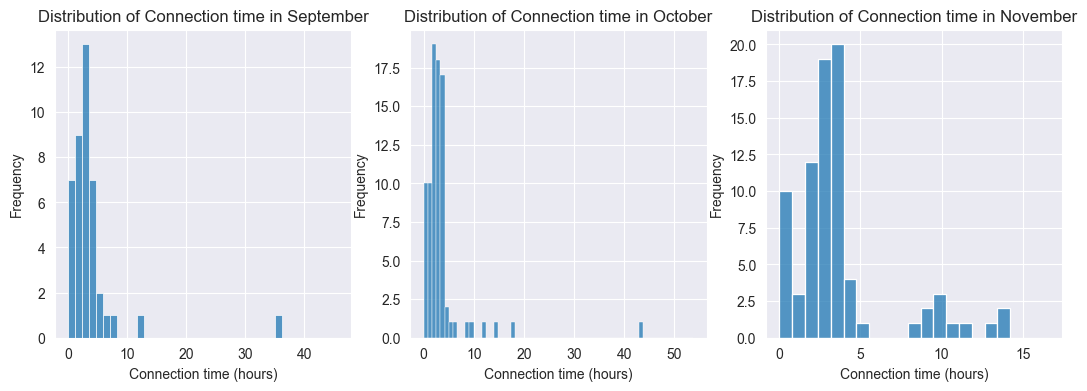

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Blocking time',
    ax=ax[0],
    binrange=(user_data_september['Blocking time'].min(), user_data_september['Blocking time'].max() + 10)
)
ax[0].set_title('Distribution of Connection time in September')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# October
sns.histplot(
    data=user_data_october,
    x='Blocking time',
    ax=ax[1],
    binrange=(user_data_october['Blocking time'].min(), user_data_october['Blocking time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in October')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# November
sns.histplot(
    data=user_data_november,
    x='Blocking time',
    ax=ax[2],
    binrange=(user_data_november['Blocking time'].min(), user_data_november['Blocking time'].max() + 2.5)
)
ax[2].set_title('Distribution of Connection time in November')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Connection time (hours)')

# Save figure
plt.savefig('../Images/Public/Redo/connection-time-distribution-1', bbox_inches='tight')
plt.show()

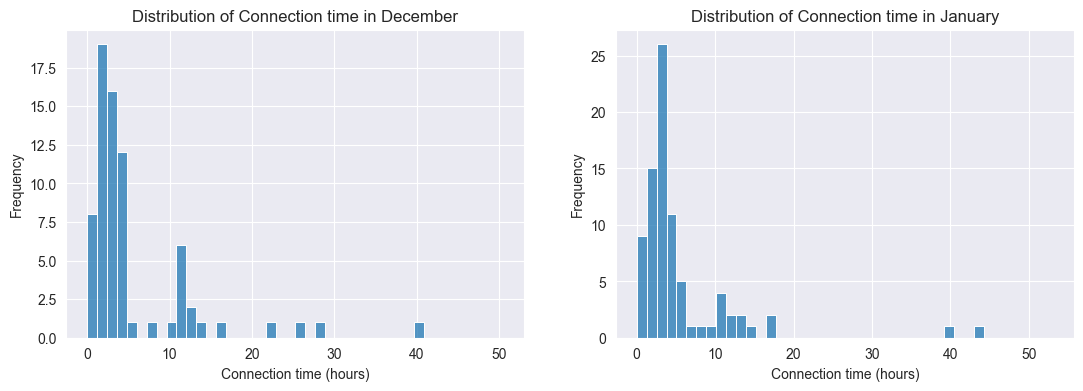

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=user_data_december,
    x='Blocking time',
    ax=ax[0],
    binrange=(user_data_december['Blocking time'].min(), user_data_december['Blocking time'].max() + 10)
)
ax[0].set_title('Distribution of Connection time in December')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# January
sns.histplot(
    data=user_data_january,
    x='Blocking time',
    ax=ax[1],
    binrange=(user_data_january['Blocking time'].min(), user_data_january['Blocking time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in January')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# Save figure
plt.savefig('../Images/Public/Redo/connection-time-distribution-2', bbox_inches='tight')
plt.show()

### Correct outliers

#### September

In [68]:
user_data_september[user_data_september['Blocking time'] > 20]

Nutzergruppe  Kostenstelle  Nutzer/Fahrzeug    Ladekarte  \
6  Öffentliches Laden           NaN  eRoaming Nutzer  <unbekannt>   

           Eingesteckt am          Ausgesteckt am   Ladedauer Zeit angesteckt  \
6 2023-09-04 19:44:28.584 2023-09-06 07:22:07.401  6h 12m 07s     35h 37m 39s   

  Standort   Ladestation    Anschluss       EVSE-ID  Kommentar  Preis pro kWh  \
6  Ulanweg  ABL_10332049  Ladepunkt 4  DE*ONE*EE94A        NaN         0.4952   

   Verbrauch (kWh)  Netto Kosten (kWh)  Steuersatz (kWh)  Steuer Kosten (kWh)  \
6           67.342               28.02                19                 5.33   

   Brutto Kosten (kWh)  Parkgebühr Tarif (pro Minute)  \
6                33.35                              0   

   Netto Kosten (Parkgebühr)  Steuersatz (Parkgebühr)  \
6                          0                       19   

   Steuer Kosten (Parkgebühr)  Brutto Kosten (Parkgebühr)  Kosten gesamt  \
6                           0                           0          33.35   

   Charge time  Blocking time Plugged_in_month Unplugged_month  \
6     6.201944        35.6275        September       September   

   Plugged_in_week  Unplugged_week  Plugged_in_day  Unplugged_day  \
6               36              36               4              6   

   Plugged_in_time   Unplugged_time Plugged_in_dayname Unplugged_dayname  \
6  19:44:28.584000  07:22:07.401000             Monday         Wednesday   

  Plugged_in_time_hour Unplugged_time_hour  Hogging time  
6                   19                  07     29.425556

In [69]:
user_data_september.drop([6], inplace=True)

Consumption cannot be used to obtain blocking time since both are high. It also had the highest charge time for a session in september. The row is dropped since the blocking time cannot be aggregated by any means.

#### October

In [70]:
user_data_october[user_data_october['Blocking time'] > 40]

Nutzergruppe  Kostenstelle  Nutzer/Fahrzeug    Ladekarte  \
107  Öffentliches Laden           NaN  eRoaming Nutzer  <unbekannt>   

             Eingesteckt am          Ausgesteckt am   Ladedauer  \
107 2023-10-23 19:03:09.684 2023-10-25 14:47:55.773  4h 53m 09s   

    Zeit angesteckt Standort   Ladestation    Anschluss       EVSE-ID  \
107     43h 44m 46s  Ulanweg  ABL_10332049  Ladepunkt 1  DE*ONE*E7RVQ   

     Kommentar  Preis pro kWh  Verbrauch (kWh)  Netto Kosten (kWh)  \
107        NaN         0.4952           49.837               20.74   

     Steuersatz (kWh)  Steuer Kosten (kWh)  Brutto Kosten (kWh)  \
107                19                 3.94                24.68   

     Parkgebühr Tarif (pro Minute)  Netto Kosten (Parkgebühr)  \
107                              0                          0   

     Steuersatz (Parkgebühr)  Steuer Kosten (Parkgebühr)  \
107                       19                           0   

     Brutto Kosten (Parkgebühr)  Kosten gesamt  Charge time  Blocking time  \
107                           0          24.68     4.885833      43.746111   

    Plugged_in_month Unplugged_month  Plugged_in_week  Unplugged_week  \
107          October         October               43              43   

     Plugged_in_day  Unplugged_day  Plugged_in_time   Unplugged_time  \
107              23             25  19:03:09.684000  14:47:55.773000   

    Plugged_in_dayname Unplugged_dayname Plugged_in_time_hour  \
107             Monday         Wednesday                   19   

    Unplugged_time_hour  Hogging time  
107                  14     38.860278

In [71]:
# Obtain the mean blocking/connection time for sessions with similar consumption
mean_blocking_time = user_data_october.drop([107])[(user_data_october['Verbrauch (kWh)'] >= 40) & (user_data_october['Verbrauch (kWh)'] <= 50)]['Blocking time'].mean()

# Assign the mean blocking time to the outlier
user_data_october.loc[107, 'Blocking time'] = mean_blocking_time

#### December

In [72]:
user_data_december[user_data_december['Blocking time'] > 40]

Nutzergruppe  Kostenstelle  Nutzer/Fahrzeug    Ladekarte  \
210  Öffentliches Laden           NaN  eRoaming Nutzer  <unbekannt>   

             Eingesteckt am          Ausgesteckt am   Ladedauer  \
210 2023-12-02 14:39:35.278 2023-12-04 07:13:11.382  4h 02m 42s   

    Zeit angesteckt Standort   Ladestation    Anschluss       EVSE-ID  \
210     40h 33m 36s  Ulanweg  ABL_10332049  Ladepunkt 1  DE*ONE*E7RVQ   

     Kommentar  Preis pro kWh  Verbrauch (kWh)  Netto Kosten (kWh)  \
210        NaN         0.4952            43.12               17.94   

     Steuersatz (kWh)  Steuer Kosten (kWh)  Brutto Kosten (kWh)  \
210                19                 3.41                21.35   

     Parkgebühr Tarif (pro Minute)  Netto Kosten (Parkgebühr)  \
210                              0                          0   

     Steuersatz (Parkgebühr)  Steuer Kosten (Parkgebühr)  \
210                       19                           0   

     Brutto Kosten (Parkgebühr)  Kosten gesamt  Charge time  Blocking time  \
210                           0          21.35        4.045          40.56   

    Plugged_in_month Unplugged_month  Plugged_in_week  Unplugged_week  \
210         December        December               48              49   

     Plugged_in_day  Unplugged_day  Plugged_in_time   Unplugged_time  \
210               2              4  14:39:35.278000  07:13:11.382000   

    Plugged_in_dayname Unplugged_dayname Plugged_in_time_hour  \
210           Saturday            Monday                   14   

    Unplugged_time_hour  Hogging time  
210                  07        36.515

In [73]:
# Obtain the mean blocking time for sessions with similar consumption values
mean_blocking_time = user_data_december.drop([210])[(user_data_december['Verbrauch (kWh)'] >= 40) & (user_data_december['Verbrauch (kWh)'] <= 50)]['Blocking time'].mean()

# Assign the mean blocking time to the outlier
user_data_december.loc[210, 'Blocking time'] = mean_blocking_time

#### January

In [74]:
user_data_january[user_data_january['Blocking time'] > 35]

Nutzergruppe  Kostenstelle  Nutzer/Fahrzeug    Ladekarte  \
278  Öffentliches Laden           NaN  eRoaming Nutzer  <unbekannt>   
294  Öffentliches Laden           NaN  eRoaming Nutzer  <unbekannt>   

             Eingesteckt am          Ausgesteckt am   Ladedauer  \
278 2024-01-01 16:03:27.195 2024-01-03 08:08:13.963  6h 12m 59s   
294 2024-01-07 19:35:14.469 2024-01-09 14:40:15.123  7h 26m 29s   

    Zeit angesteckt Standort   Ladestation           Anschluss       EVSE-ID  \
278     40h 04m 47s  Ulanweg  ABL_10332049   Ladepunkt 2 links  DE*ONE*EE94A   
294     43h 05m 01s  Ulanweg  ABL_10332049  Ladepunkt 4 rechts  DE*ONE*E7RVQ   

     Kommentar  Preis pro kWh  Verbrauch (kWh)  Netto Kosten (kWh)  \
278        NaN         0.4952           59.239               24.65   
294        NaN         0.4952           75.688               31.50   

     Steuersatz (kWh)  Steuer Kosten (kWh)  Brutto Kosten (kWh)  \
278                19                 4.69                29.34   
294                19                 5.98                37.48   

     Parkgebühr Tarif (pro Minute)  Netto Kosten (Parkgebühr)  \
278                              0                          0   
294                              0                          0   

     Steuersatz (Parkgebühr)  Steuer Kosten (Parkgebühr)  \
278                       19                           0   
294                       19                           0   

     Brutto Kosten (Parkgebühr)  Kosten gesamt  Charge time  Blocking time  \
278                           0          29.34     6.216389      40.079722   
294                           0          37.48     7.441389      43.083611   

    Plugged_in_month Unplugged_month  Plugged_in_week  Unplugged_week  \
278          January         January                1               1   
294          January         January                1               2   

     Plugged_in_day  Unplugged_day  Plugged_in_time   Unplugged_time  \
278               1              3  16:03:27.195000  08:08:13.963000   
294               7              9  19:35:14.469000  14:40:15.123000   

    Plugged_in_dayname Unplugged_dayname Plugged_in_time_hour  \
278             Monday         Wednesday                   16   
294             Sunday           Tuesday                   19   

    Unplugged_time_hour  Hogging time  
278                  08     33.863333  
294                  14     35.642222

In [75]:
mean_blocking_time = user_data_january.drop([278])[(user_data_january['Verbrauch (kWh)'] >= 50) & (user_data_january['Verbrauch (kWh)'] <= 65)]['Blocking time'].mean()

user_data_december.loc[278, 'Blocking time'] = mean_blocking_time

In [76]:
mean_blocking_time = user_data_january.drop([294])[(user_data_january['Verbrauch (kWh)'] >= 70) & (user_data_january['Verbrauch (kWh)'] <= 80)]['Blocking time'].mean()

user_data_december.loc[278, 'Blocking time'] = mean_blocking_time

Redo the plots without outliers

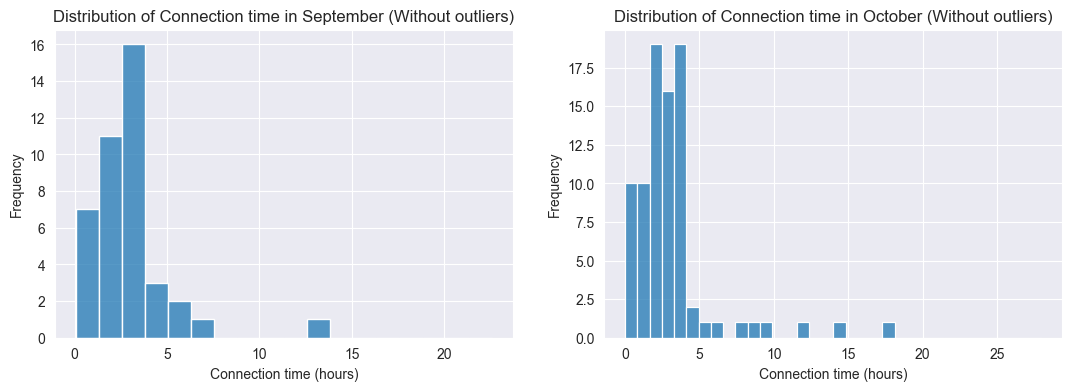

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Blocking time',
    ax=ax[0],
    binrange=(user_data_september['Blocking time'].min(), user_data_september['Blocking time'].max() + 10)
)
ax[0].set_title('Distribution of Connection time in September (Without outliers)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# October
sns.histplot(
    data=user_data_october,
    x='Blocking time',
    ax=ax[1],
    binrange=(user_data_october['Blocking time'].min(), user_data_october['Blocking time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in October (Without outliers)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# Save figure
plt.savefig('../Images/Public/Redo/connection-time-distribution-1-without-outlier', bbox_inches='tight')
plt.show()

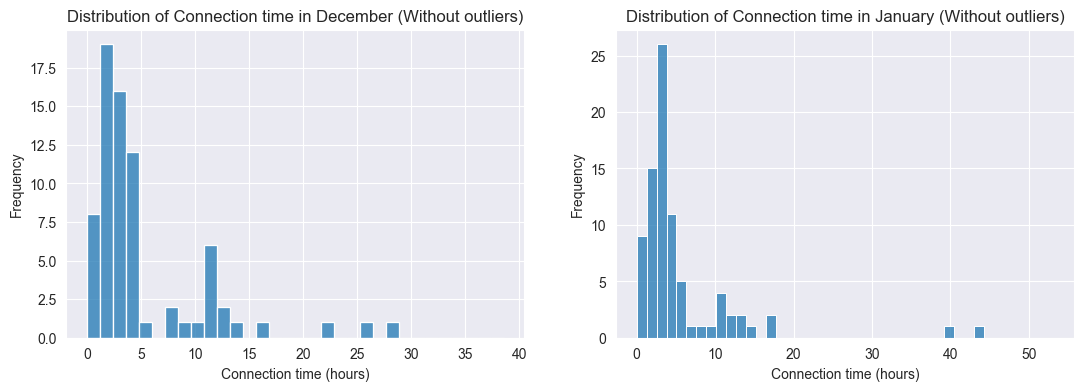

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=user_data_december,
    x='Blocking time',
    ax=ax[0],
    binrange=(user_data_december['Blocking time'].min(), user_data_december['Blocking time'].max() + 10)
)
ax[0].set_title('Distribution of Connection time in December (Without outliers)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Connection time (hours)')

# January
sns.histplot(
    data=user_data_january,
    x='Blocking time',
    ax=ax[1],
    binrange=(user_data_january['Blocking time'].min(), user_data_january['Blocking time'].max() + 10)
)
ax[1].set_title('Distribution of Connection time in January (Without outliers)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Connection time (hours)')

# Save figure
plt.savefig('../Images/Public/Redo/connection-time-distribution-2-without-outlier', bbox_inches='tight')
plt.show()

### Connection time (monthly)

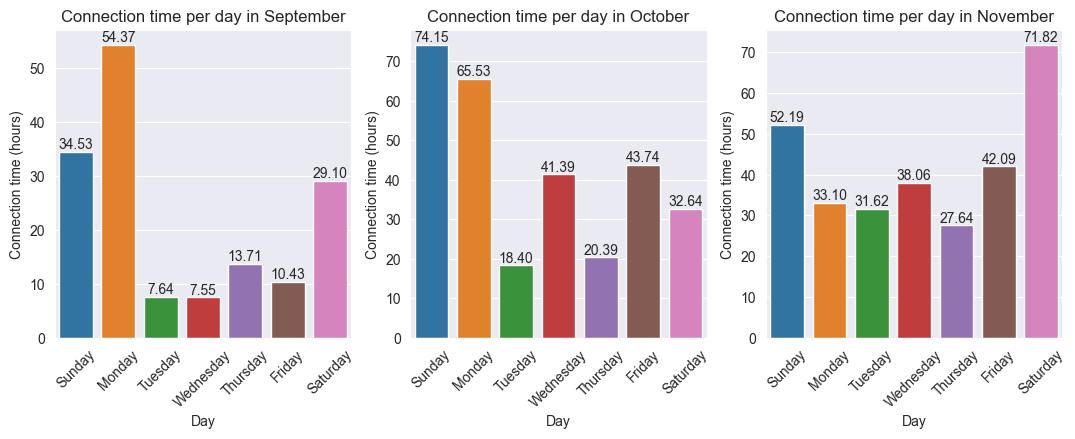

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.barplot(
    data=user_data_september.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Connection time per day in September')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# October
sns.barplot(
    data=user_data_october.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Connection time per day in October')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# December
sns.barplot(
    data=user_data_november.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[2]
)
ax[2].tick_params(axis='x', rotation=45)
ax[2].set_title('Connection time per day in November')
ax[2].set_ylabel('Connection time (hours)')
ax[2].set_xlabel('Day')
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('../Images/Public/Redo/connection-time-per-day-1', bbox_inches='tight')
plt.show()

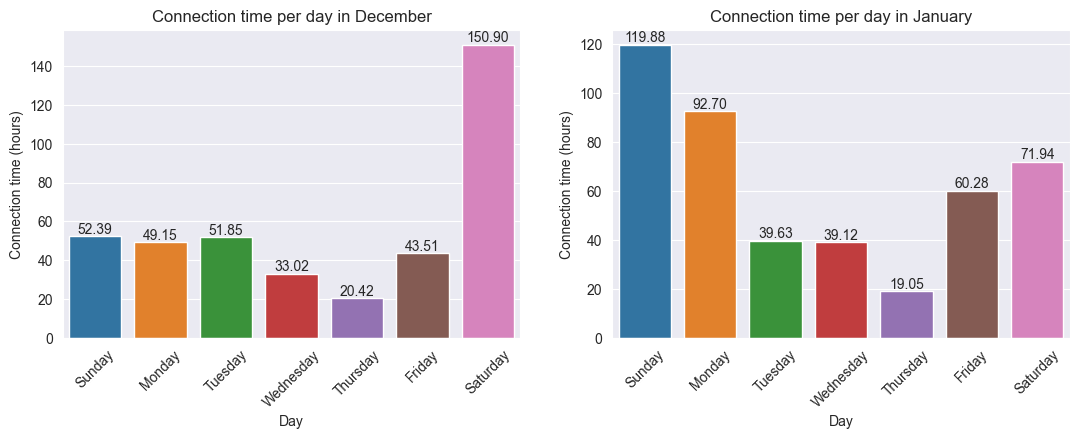

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=user_data_december.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Connection time per day in December')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=user_data_january.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Connection time per day in January')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('../Images/Public/Redo/connection-time-per-day-2', bbox_inches='tight')
plt.show()

#### Without outliers

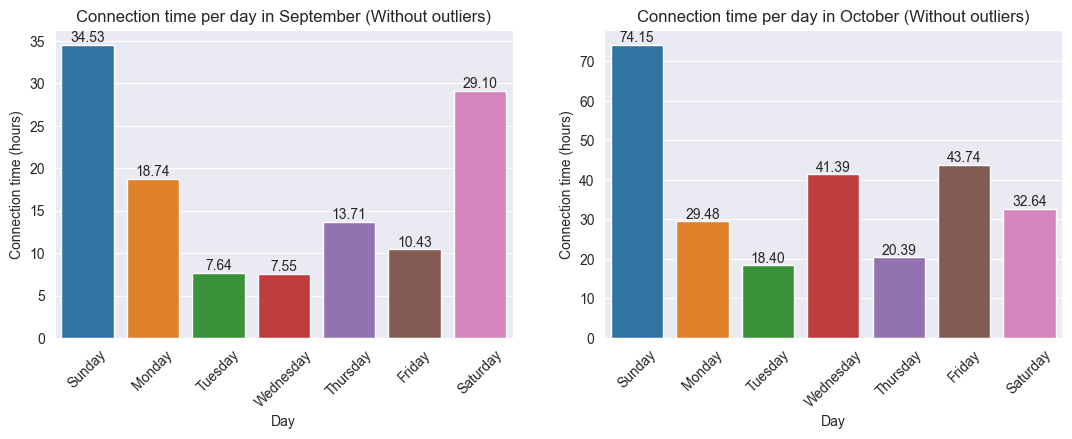

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.barplot(
    data=user_data_september.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Connection time per day in September (Without outliers)')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# October
sns.barplot(
    data=user_data_october.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Connection time per day in October (Without outliers)')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('../Images/Public/Redo/connection-time-per-day-1-without-outlier', bbox_inches='tight')
plt.show()

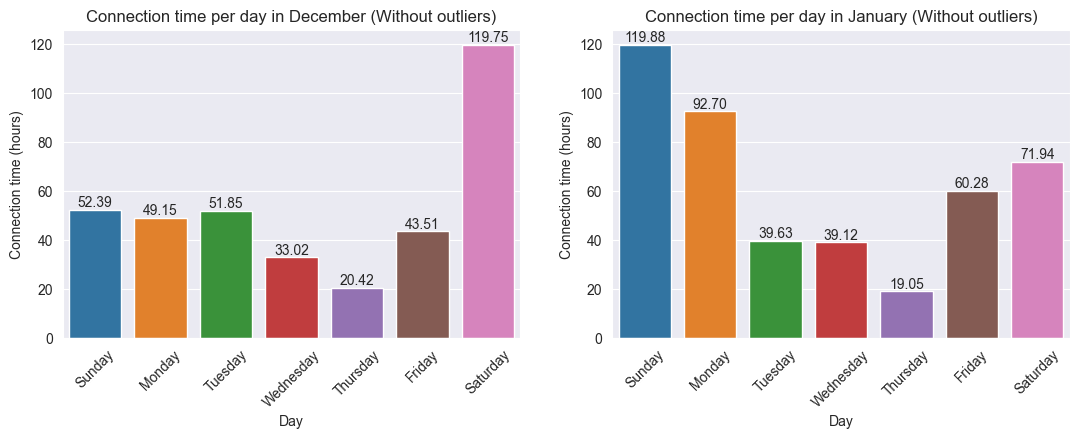

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=user_data_december.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Connection time per day in December (Without outliers)')
ax[0].set_ylabel('Connection time (hours)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=user_data_january.sort_values('Plugged_in_dayname'),
    y='Blocking time',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Connection time per day in January (Without outliers)')
ax[1].set_ylabel('Connection time (hours)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('../Images/Public/Redo/connection-time-per-day-2-without-outliers', bbox_inches='tight')
plt.show()

### Distribution of Charge time

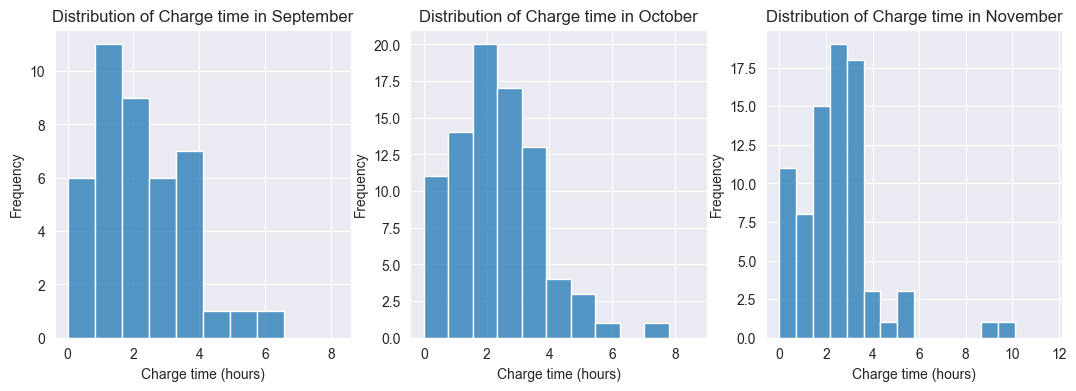

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Charge time',
    ax=ax[0],
    binrange=(user_data_september['Charge time'].min(), user_data_september['Charge time'].max() + 2)
)
ax[0].set_title('Distribution of Charge time in September')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Charge time (hours)')

# October
sns.histplot(
    data=user_data_october,
    x='Charge time',
    ax=ax[1],
    binrange=(user_data_october['Charge time'].min(), user_data_october['Charge time'].max() + 1)
)
ax[1].set_title('Distribution of Charge time in October')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Charge time (hours)')

# November
sns.histplot(
    data=user_data_november,
    x='Charge time',
    ax=ax[2],
    binrange=(user_data_november['Charge time'].min(), user_data_november['Charge time'].max() + 2)
)
ax[2].set_title('Distribution of Charge time in November')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Charge time (hours)')

# Save figure
plt.savefig('../Images/Public/Redo/charge-time-distribution-1', bbox_inches='tight')
plt.show()

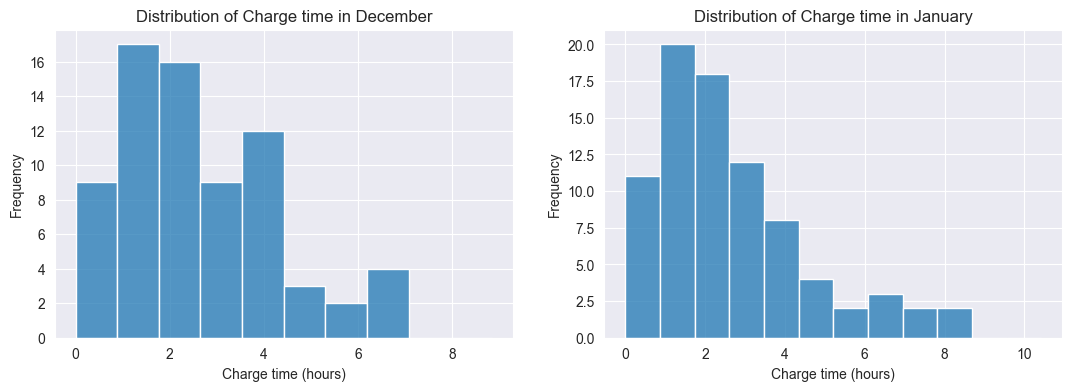

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=user_data_december,
    x='Charge time',
    ax=ax[0],
    binrange=(user_data_december['Charge time'].min(), user_data_december['Charge time'].max() + 2)
)
ax[0].set_title('Distribution of Charge time in December')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Charge time (hours)')

# January
sns.histplot(
    data=user_data_january,
    x='Charge time',
    ax=ax[1],
    binrange=(user_data_january['Charge time'].min(), user_data_january['Charge time'].max() + 2)
)
ax[1].set_title('Distribution of Charge time in January')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Charge time (hours)')

# Save figure
plt.savefig('../Images/Public/Redo/charge-time-distribution-2', bbox_inches='tight')
plt.show()

### Distribution of Consumption

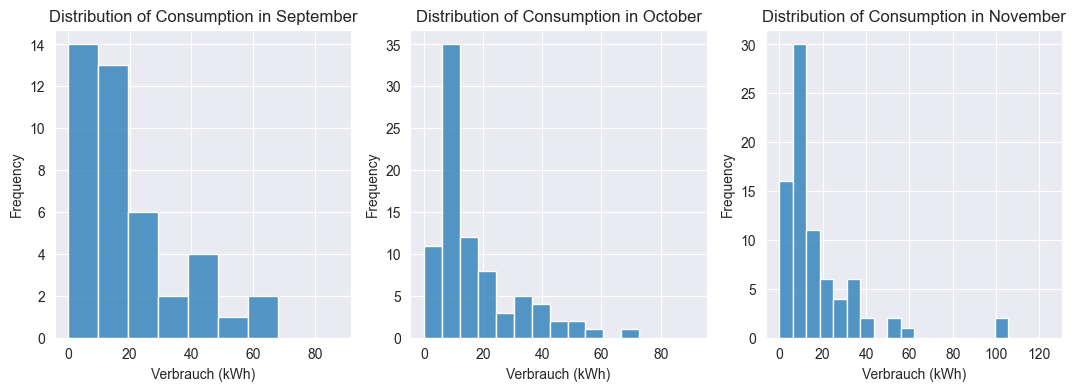

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Verbrauch (kWh)',
    ax=ax[0],
    binrange=(user_data_september['Verbrauch (kWh)'].min(), user_data_september['Verbrauch (kWh)'].max() + 20)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Verbrauch (kWh)')
ax[0].set_title('Distribution of Consumption in September')

# October
sns.histplot(
    data=user_data_october,
    x='Verbrauch (kWh)',
    ax=ax[1],
    binrange=(user_data_october['Verbrauch (kWh)'].min(), user_data_october['Verbrauch (kWh)'].max() + 20)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Verbrauch (kWh)')
ax[1].set_title('Distribution of Consumption in October')

# November
sns.histplot(
    data=user_data_november,
    x='Verbrauch (kWh)',
    ax=ax[2],
    binrange=(user_data_november['Verbrauch (kWh)'].min(), user_data_november['Verbrauch (kWh)'].max() + 20)
)
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Verbrauch (kWh)')
ax[2].set_title('Distribution of Consumption in November')

# Save figure
plt.savefig('../Images/Public/Redo/consumption-distribution-1', bbox_inches='tight')
plt.show()

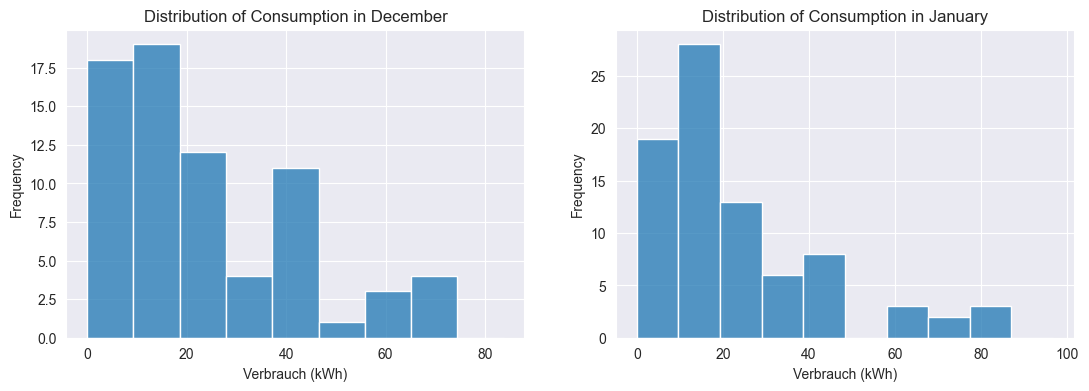

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.histplot(
    data=user_data_december,
    x='Verbrauch (kWh)',
    ax=ax[0],
    binrange=(user_data_december['Verbrauch (kWh)'].min(), user_data_december['Verbrauch (kWh)'].max() + 10)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Verbrauch (kWh)')
ax[0].set_title('Distribution of Consumption in December')

# January
sns.histplot(
    data=user_data_january,
    x='Verbrauch (kWh)',
    ax=ax[1],
    binrange=(user_data_january['Verbrauch (kWh)'].min(), user_data_january['Verbrauch (kWh)'].max() + 15)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Verbrauch (kWh)')
ax[1].set_title('Distribution of Consumption in January')

# Save figure
plt.savefig('../Images/Public/Redo/consumption-distribution-2', bbox_inches='tight')
plt.show()

### Correct outliers

#### November

In [81]:
user_data_november[user_data_november['Verbrauch (kWh)'] > 100]

Nutzergruppe  Kostenstelle  Nutzer/Fahrzeug    Ladekarte  \
166  Öffentliches Laden           NaN  eRoaming Nutzer  <unbekannt>   

             Eingesteckt am          Ausgesteckt am   Ladedauer  \
166 2023-11-13 19:18:42.059 2023-11-14 06:45:36.462  9h 34m 14s   

    Zeit angesteckt Standort   Ladestation    Anschluss       EVSE-ID  \
166     11h 26m 54s  Ulanweg  ABL_10332049  Ladepunkt 4  DE*ONE*EE94A   

     Kommentar  Preis pro kWh  Verbrauch (kWh)  Netto Kosten (kWh)  \
166        NaN         0.4952           104.36               43.43   

     Steuersatz (kWh)  Steuer Kosten (kWh)  Brutto Kosten (kWh)  \
166                19                 8.25                51.68   

     Parkgebühr Tarif (pro Minute)  Netto Kosten (Parkgebühr)  \
166                              0                          0   

     Steuersatz (Parkgebühr)  Steuer Kosten (Parkgebühr)  \
166                       19                           0   

     Brutto Kosten (Parkgebühr)  Kosten gesamt  Charge time  Blocking time  \
166                           0          51.68     9.570556      11.448333   

    Plugged_in_month Unplugged_month  Plugged_in_week  Unplugged_week  \
166         November        November               46              46   

     Plugged_in_day  Unplugged_day  Plugged_in_time   Unplugged_time  \
166              13             14  19:18:42.059000  06:45:36.462000   

    Plugged_in_dayname Unplugged_dayname Plugged_in_time_hour  \
166             Monday           Tuesday                   19   

    Unplugged_time_hour  Hogging time  
166                  06      1.877778

In [82]:
mean_consumption = user_data_november[(user_data_november['Blocking time'] >= 9) & (user_data_november['Blocking time'] <= 12)]['Verbrauch (kWh)'].mean()

user_data_november.loc[166, 'Verbrauch (kWh)'] = mean_consumption

In [83]:
user_data_november[user_data_november['Verbrauch (kWh)'] >= 80]

Nutzergruppe  Kostenstelle  Nutzer/Fahrzeug    Ladekarte  \
176  Öffentliches Laden           NaN  eRoaming Nutzer  <unbekannt>   

             Eingesteckt am          Ausgesteckt am   Ladedauer  \
176 2023-11-19 11:36:11.680 2023-11-19 20:45:09.629  9h 08m 13s   

    Zeit angesteckt Standort   Ladestation    Anschluss       EVSE-ID  \
176      9h 08m 58s  Ulanweg  ABL_10332049  Ladepunkt 1  DE*ONE*E7RVQ   

     Kommentar  Preis pro kWh  Verbrauch (kWh)  Netto Kosten (kWh)  \
176        NaN         0.4952           99.645               41.47   

     Steuersatz (kWh)  Steuer Kosten (kWh)  Brutto Kosten (kWh)  \
176                19                 7.87                49.34   

     Parkgebühr Tarif (pro Minute)  Netto Kosten (Parkgebühr)  \
176                              0                          0   

     Steuersatz (Parkgebühr)  Steuer Kosten (Parkgebühr)  \
176                       19                           0   

     Brutto Kosten (Parkgebühr)  Kosten gesamt  Charge time  Blocking time  \
176                           0          49.34     9.136944       9.149444   

    Plugged_in_month Unplugged_month  Plugged_in_week  Unplugged_week  \
176         November        November               46              46   

     Plugged_in_day  Unplugged_day  Plugged_in_time   Unplugged_time  \
176              19             19  11:36:11.680000  20:45:09.629000   

    Plugged_in_dayname Unplugged_dayname Plugged_in_time_hour  \
176             Sunday            Sunday                   11   

    Unplugged_time_hour  Hogging time  
176                  20        0.0125

In [84]:
mean_consumption = user_data_november[(user_data_november['Blocking time'] >= 9) & (user_data_november['Blocking time'] <= 10)]['Verbrauch (kWh)'].mean()

user_data_november.loc[176, 'Verbrauch (kWh)'] = mean_consumption

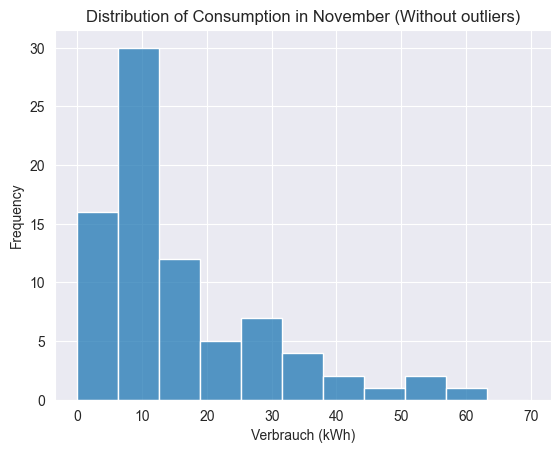

In [85]:
# November
sns.histplot(
    data=user_data_november,
    x='Verbrauch (kWh)',
    binrange=(user_data_november['Verbrauch (kWh)'].min(), user_data_november['Verbrauch (kWh)'].max() + 10)
)
plt.ylabel('Frequency')
plt.xlabel('Verbrauch (kWh)')
plt.title('Distribution of Consumption in November (Without outliers)')

# Save figure
plt.savefig('../Images/Public/Redo/consumption-distribution-1-without-outlier', bbox_inches='tight')
plt.show()

### Consumption (monthly)

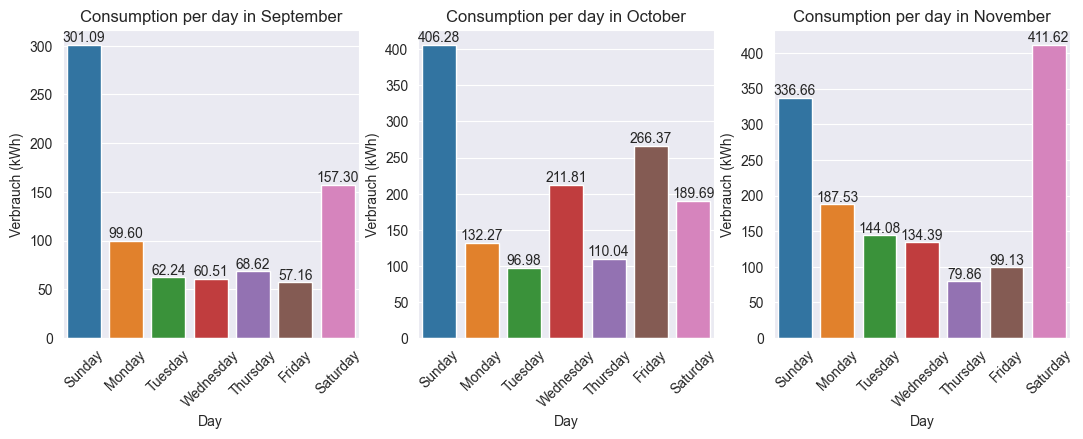

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.barplot(
    data=user_data_september.sort_values('Plugged_in_dayname'),
    y='Verbrauch (kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Consumption per day in September')
ax[0].set_ylabel('Verbrauch (kWh)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# October
sns.barplot(
    data=user_data_october.sort_values('Plugged_in_dayname'),
    y='Verbrauch (kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Consumption per day in October')
ax[1].set_ylabel('Verbrauch (kWh)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# November
sns.barplot(
    data=user_data_november.sort_values('Plugged_in_dayname'),
    y='Verbrauch (kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[2]
)
ax[2].set_title('Consumption per day in November')
ax[2].set_ylabel('Verbrauch (kWh)')
ax[2].set_xlabel('Day')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('../Images/Public/Redo/consumption-per-day-1', bbox_inches='tight')
plt.show()

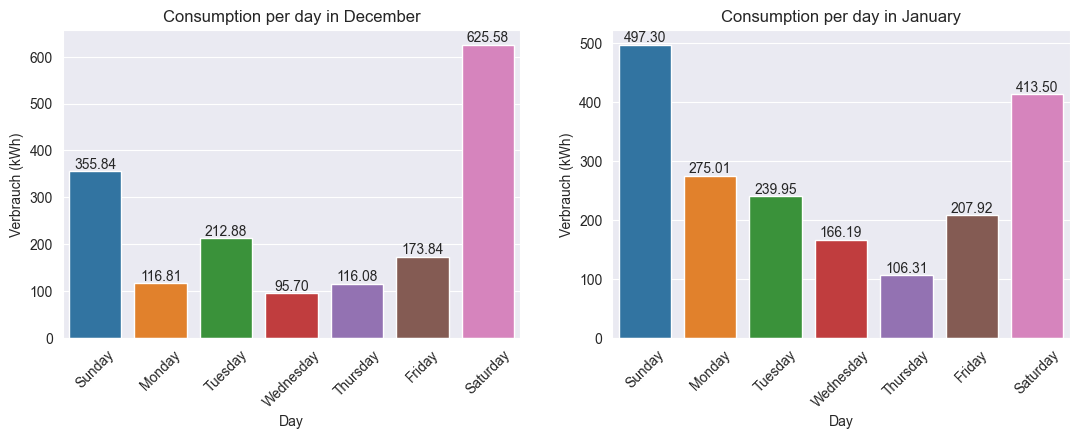

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# December
sns.barplot(
    data=user_data_december.sort_values('Plugged_in_dayname'),
    y='Verbrauch (kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[0]
)
ax[0].set_title('Consumption per day in December')
ax[0].set_ylabel('Verbrauch (kWh)')
ax[0].set_xlabel('Day')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.2f')

# January
sns.barplot(
    data=user_data_january.sort_values('Plugged_in_dayname'),
    y='Verbrauch (kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax[1]
)
ax[1].set_title('Consumption per day in January')
ax[1].set_ylabel('Verbrauch (kWh)')
ax[1].set_xlabel('Day')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('../Images/Public/Redo/consumption-per-day-2', bbox_inches='tight')
plt.show()

#### Without outliers

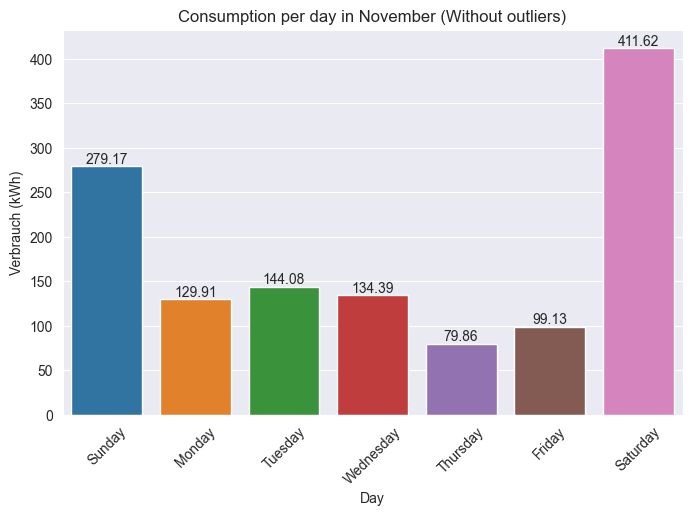

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

# November
sns.barplot(
    data=user_data_november.sort_values('Plugged_in_dayname'),
    y='Verbrauch (kWh)',
    x='Plugged_in_dayname',
    estimator='sum',
    errorbar=None,
    ax=ax
)
ax.set_title('Consumption per day in November (Without outliers)')
ax.set_ylabel('Verbrauch (kWh)')
ax.set_xlabel('Day')
ax.tick_params(axis='x', rotation=45)
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f')

# Save figure
plt.savefig('../Images/Public/Redo/consumption-per-day-1-without-outliers', bbox_inches='tight')
plt.show()

### Distribution of Hogging time

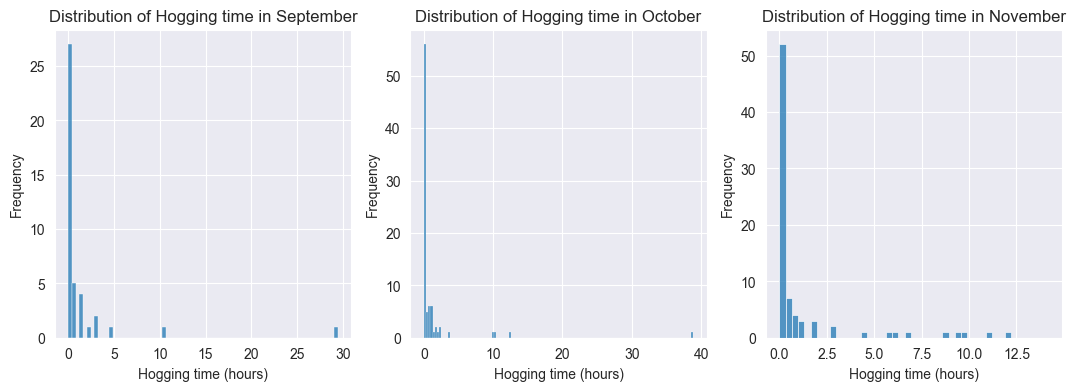

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Hogging time',
    ax=ax[0]
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in September')

# October
sns.histplot(
    data=user_data_october,
    x='Hogging time',
    ax=ax[1]
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in October')

# November
sns.histplot(
    data=user_data_november,
    x='Hogging time',
    ax=ax[2],
    binrange=(user_data_november['Hogging time'].min(), user_data_november['Hogging time'].max() + 2)
)
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Hogging time (hours)')
ax[2].set_title('Distribution of Hogging time in November')

# Save figure
plt.savefig('../Images/Public/Redo/hogging-time-distribution-1', bbox_inches='tight')
plt.show()

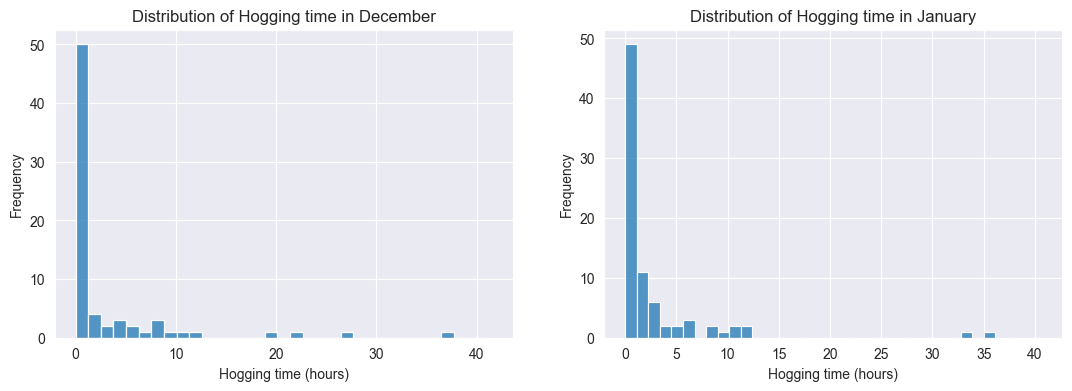

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_december,
    x='Hogging time',
    ax=ax[0],
    binrange=(user_data_december['Hogging time'].min(), user_data_december['Hogging time'].max() + 5)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in December')

# October
sns.histplot(
    data=user_data_january,
    x='Hogging time',
    ax=ax[1],
    binrange=(user_data_january['Hogging time'].min(), user_data_january['Hogging time'].max() + 5)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in January')

# Save figure
plt.savefig('../Images/Public/Redo/hogging-time-distribution-2', bbox_inches='tight')
plt.show()

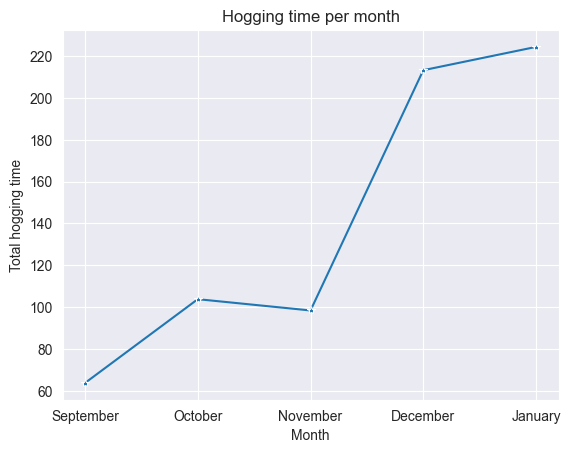

In [25]:
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Hogging time',
    estimator='sum',
    ci=None,
    marker='*'
)
plt.xlabel('Month')
plt.ylabel('Total hogging time')
plt.title('Hogging time per month')

# Save figure
plt.savefig('../Images/Public/Redo/hogging-time-per-month', bbox_inches='tight')
plt.show()

#### Calculating hogging time without outliers

In [87]:
# Obtain the hogging time for the corrected data
user_data_september['Hogging time'] = user_data_september['Blocking time'] - user_data_september['Charge time']
user_data_october['Hogging time'] = user_data_october['Blocking time'] - user_data_october['Charge time']
user_data_november['Hogging time'] = user_data_november['Blocking time'] - user_data_november['Charge time']
user_data_december['Hogging time'] = user_data_december['Blocking time'] - user_data_december['Charge time']
user_data_january['Hogging time'] = user_data_january['Blocking time'] - user_data_january['Charge time']

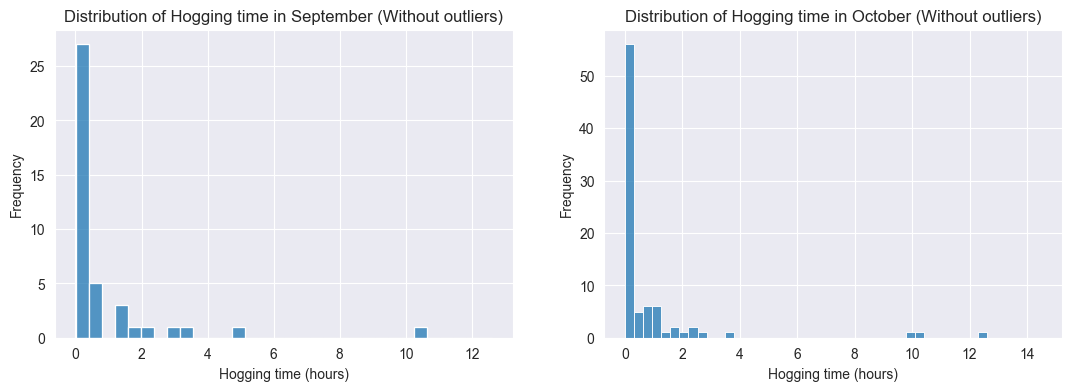

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_september,
    x='Hogging time',
    ax=ax[0],
    binrange=(user_data_september['Hogging time'].min(), user_data_september['Hogging time'].max() + 2)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in September (Without outliers)')

# October
sns.histplot(
    data=user_data_october,
    x='Hogging time',
    ax=ax[1],
    binrange=(user_data_october['Hogging time'].min(), user_data_october['Hogging time'].max() + 2)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in October (Without outliers)')

# Save figure
plt.savefig('../Images/Public/Redo/hogging-time-distribution-1-without-outlier', bbox_inches='tight')
plt.show()

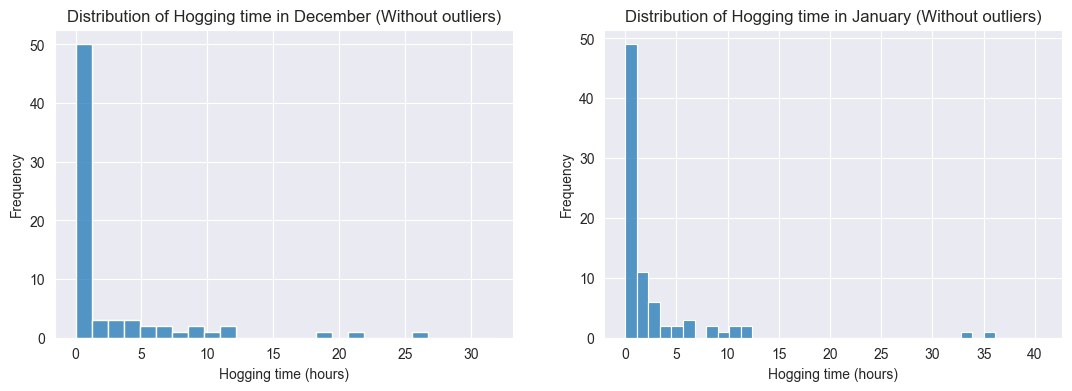

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

# September
sns.histplot(
    data=user_data_december,
    x='Hogging time',
    ax=ax[0],
    binrange=(user_data_december['Hogging time'].min(), user_data_december['Hogging time'].max() + 5)
)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Hogging time (hours)')
ax[0].set_title('Distribution of Hogging time in December (Without outliers)')

# October
sns.histplot(
    data=user_data_january,
    x='Hogging time',
    ax=ax[1],
    binrange=(user_data_january['Hogging time'].min(), user_data_january['Hogging time'].max() + 5)
)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Hogging time (hours)')
ax[1].set_title('Distribution of Hogging time in January (Without outliers)')

# Save figure
plt.savefig('../Images/Public/Redo/hogging-time-distribution-2-without-outlier', bbox_inches='tight')
plt.show()

### Connection and charge time (monthly)

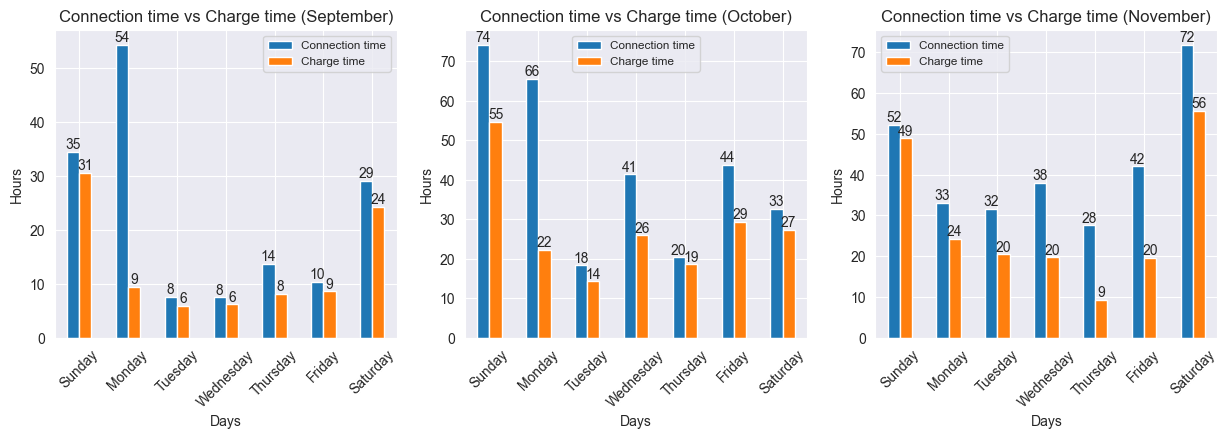

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# September
user_data_september.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Hours')
ax[0].legend(['Connection time', 'Charge time'], fontsize=8.5)
ax[0].set_title('Connection time vs Charge time (September)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
user_data_october.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Hours')
ax[1].legend(['Connection time', 'Charge time'], loc='upper center', fontsize=8.5)
ax[1].set_title('Connection time vs Charge time (October)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# November
user_data_november.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[2])
#ax[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Hours')
ax[2].legend(['Connection time', 'Charge time'], loc='upper left', fontsize=8.5)
ax[2].set_title('Connection time vs Charge time (November)')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.0f')
ax[2].bar_label(ax[2].containers[1], fontsize=10, fmt='%.0f')

# Save figure
plt.savefig('../Images/Public/Redo/average-connection-charge-time-per-day-1', bbox_inches='tight')
plt.show()

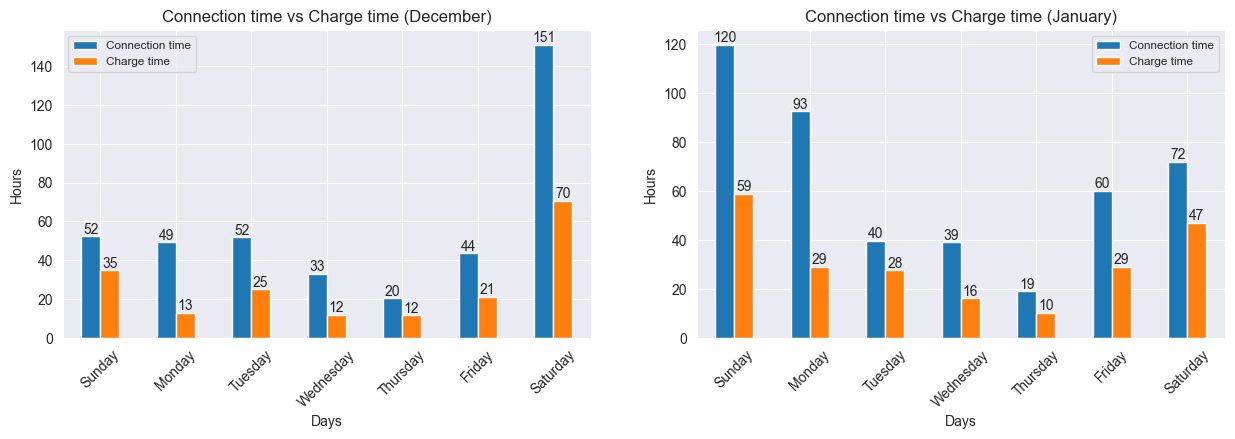

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# September
user_data_december.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Hours')
ax[0].legend(['Connection time', 'Charge time'], fontsize=8.5)
ax[0].set_title('Connection time vs Charge time (December)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
user_data_january.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Hours')
ax[1].legend(['Connection time', 'Charge time'], fontsize=8.5)
ax[1].set_title('Connection time vs Charge time (January)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# Save figure
plt.savefig('../Images/Public/Redo/average-connection-charge-time-2', bbox_inches='tight')
plt.show()

#### Without outliers

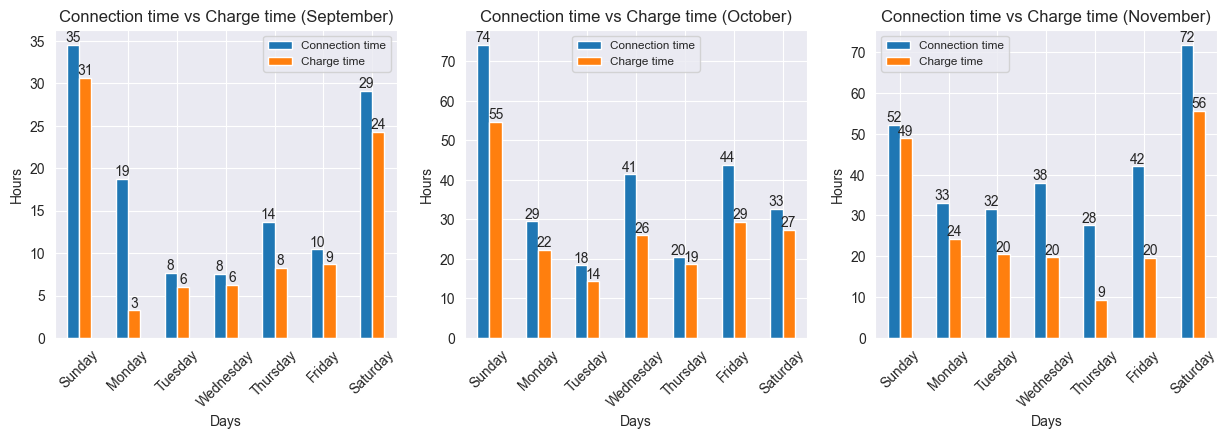

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# September
user_data_september.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Hours')
ax[0].legend(['Connection time', 'Charge time'], fontsize=8.5)
ax[0].set_title('Connection time vs Charge time (September)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
user_data_october.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Hours')
ax[1].legend(['Connection time', 'Charge time'], loc='upper center', fontsize=8.5)
ax[1].set_title('Connection time vs Charge time (October)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# November
user_data_november.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[2])
#ax[2].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], rotation=45)
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Hours')
ax[2].legend(['Connection time', 'Charge time'], loc='upper left', fontsize=8.5)
ax[2].set_title('Connection time vs Charge time (November)')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10, fmt='%.0f')
ax[2].bar_label(ax[2].containers[1], fontsize=10, fmt='%.0f')

# Save figure
plt.savefig('../Images/Public/Redo/average-connection-charge-time-per-day-1-without-outlier', bbox_inches='tight')
plt.show()

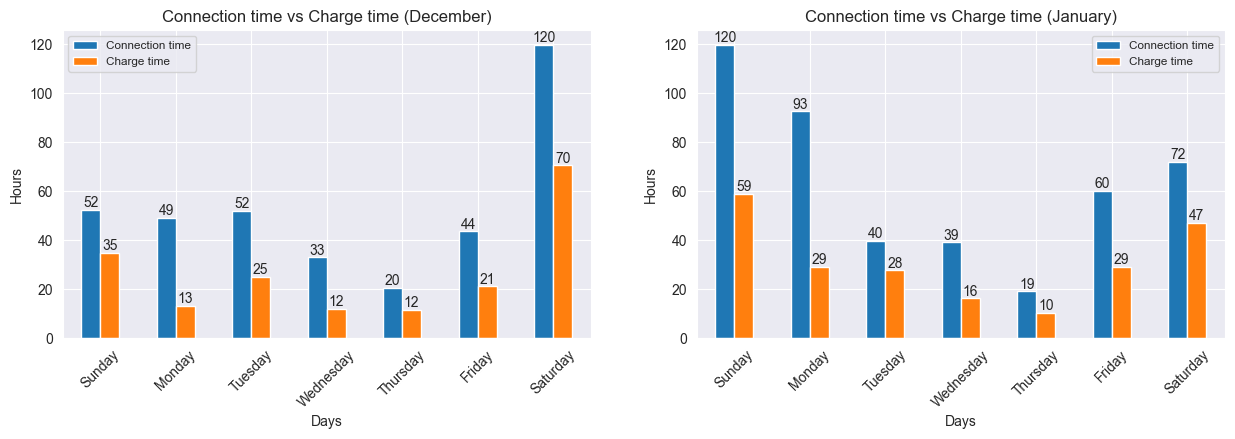

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# September
user_data_december.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[0])
#ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Hours')
ax[0].legend(['Connection time', 'Charge time'], fontsize=8.5)
ax[0].set_title('Connection time vs Charge time (December)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10, fmt='%.0f')
ax[0].bar_label(ax[0].containers[1], fontsize=10, fmt='%.0f')

# October
user_data_january.groupby('Plugged_in_dayname')[['Blocking time', 'Charge time']].sum().plot(kind='bar', ax=ax[1])
#ax[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Hours')
ax[1].legend(['Connection time', 'Charge time'], fontsize=8.5)
ax[1].set_title('Connection time vs Charge time (January)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10, fmt='%.0f')
ax[1].bar_label(ax[1].containers[1], fontsize=10, fmt='%.0f')

# Save figure
plt.savefig('../Images/Public/Redo/average-connection-charge-time-2-without-outlier', bbox_inches='tight')
plt.show()

### Number of charge sessions

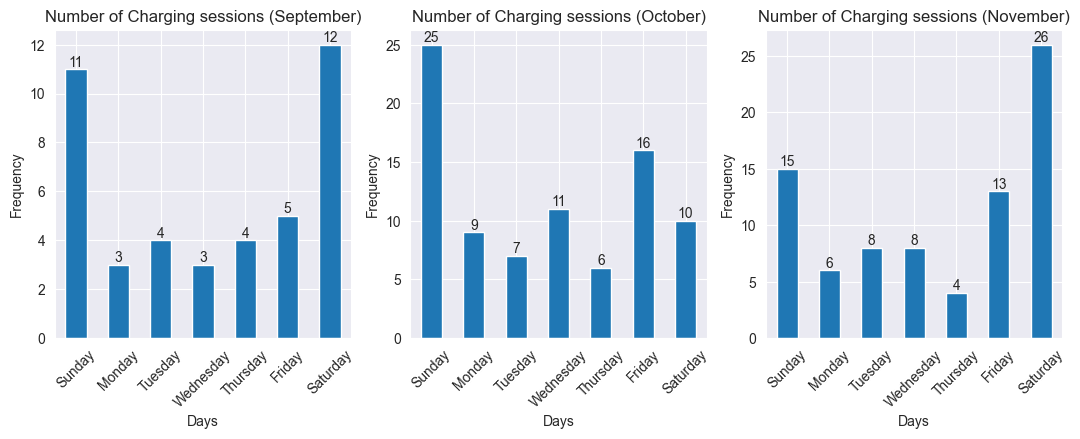

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))

# September
user_data_september.groupby('Plugged_in_dayname')['Charge time'].count().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Number of Charging sessions (September)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10)

# October
user_data_october.groupby('Plugged_in_dayname')['Charge time'].count().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Number of Charging sessions (October)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10)

# November
user_data_november.groupby('Plugged_in_dayname')['Charge time'].count().plot(kind='bar', ax=ax[2])
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Number of Charging sessions (November)')
ax[2].tick_params(axis='x', rotation=45)
ax[2].bar_label(ax[2].containers[0], fontsize=10)

# Save figure
plt.savefig('../Images/Public/Redo/charge-sessions-per-day-1', bbox_inches='tight')
plt.show()

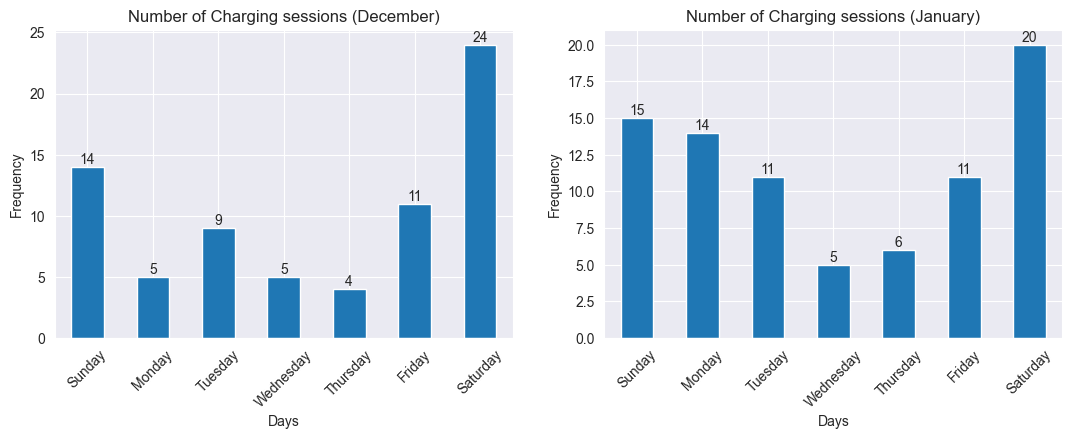

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# December
user_data_december.groupby('Plugged_in_dayname')['Charge time'].count().plot(kind='bar', ax=ax[0])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Number of Charging sessions (December)')
ax[0].tick_params(axis='x', rotation=45)
ax[0].bar_label(ax[0].containers[0], fontsize=10)

# January
user_data_january.groupby('Plugged_in_dayname')['Charge time'].count().plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Number of Charging sessions (January)')
ax[1].tick_params(axis='x', rotation=45)
ax[1].bar_label(ax[1].containers[0], fontsize=10)

# Save figure
plt.savefig('../Images/Public/Redo/charge-sessions-per-day-2', bbox_inches='tight')
plt.show()

### Plug-in and plug-out frequency

In [30]:
plug_in = user_data.groupby(['Plugged_in_time_hour'])['Plugged_in_time_hour'].value_counts(dropna=False).reset_index()
plug_out = user_data.groupby(['Unplugged_time_hour'])['Unplugged_time_hour'].value_counts(dropna=False).reset_index()

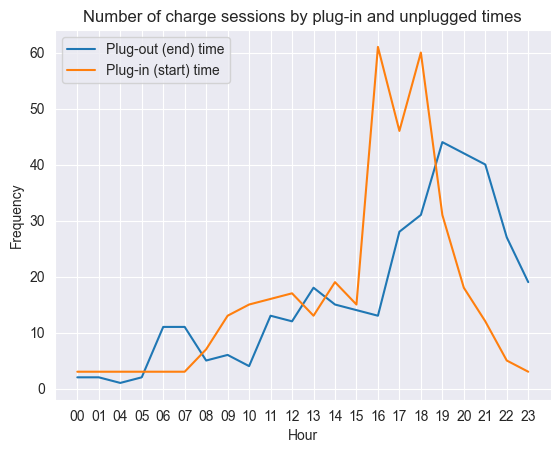

In [31]:
sns.lineplot(
    data=plug_out,
    x='Unplugged_time_hour',
    y='count',
    label='Plug-out (end) time',
)
sns.lineplot(
    data=plug_in,
    x='Plugged_in_time_hour',
    y='count',
    label='Plug-in (start) time',
)
plt.title('Number of charge sessions by plug-in and unplugged times')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.legend()

# Save figure
plt.savefig('../Images/Public/Redo/number-of-charge-sessions-per-plugin-unplugged-times', bbox_inches='tight')
plt.show()

### Connection time of each user

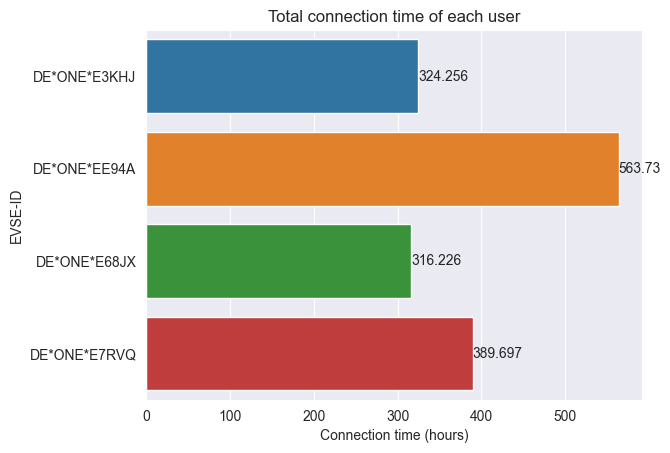

In [32]:
ax = sns.barplot(
    data=user_data,
    y='EVSE-ID',
    x='Blocking time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Connection time (hours)')
plt.title('Total connection time of each user')
plt.savefig('../Images/Public/Redo/blocking-time-user', bbox_inches='tight')
plt.show()

#### Without outlier

In [92]:
# Join the five months dataframes to a single one reflecting the corrected outliers
user_data_concat = pd.concat([
    user_data_september,
    user_data_october,
    user_data_november,
    user_data_december,
    user_data_january
], axis=0)

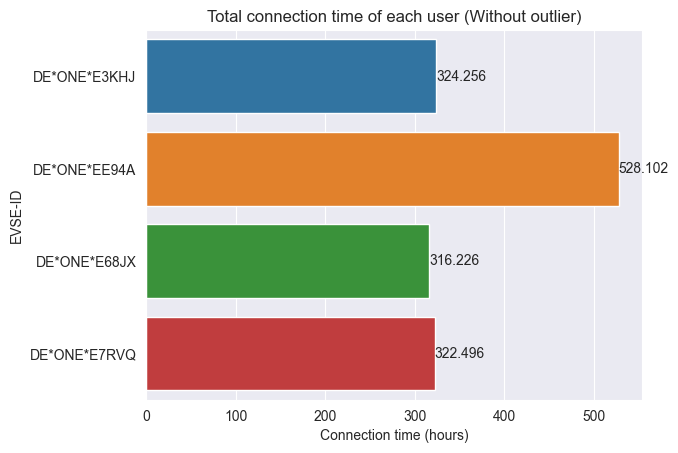

In [93]:
ax = sns.barplot(
    data=user_data_concat,
    y='EVSE-ID',
    x='Blocking time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Connection time (hours)')
plt.title('Total connection time of each user (Without outlier)')
plt.savefig('../Images/Public/Redo/blocking-time-user-without-outlier', bbox_inches='tight')
plt.show()

### Charge time of each user

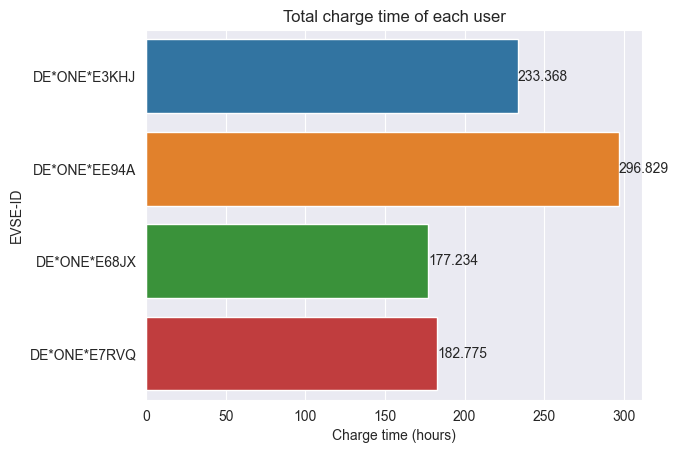

In [33]:
ax = sns.barplot(
    data=user_data,
    y='EVSE-ID',
    x='Charge time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Charge time (hours)')
plt.title('Total charge time of each user')
plt.savefig('../Images/Public/Redo/charge-session-user', bbox_inches='tight')
plt.show()

#### Without outlier

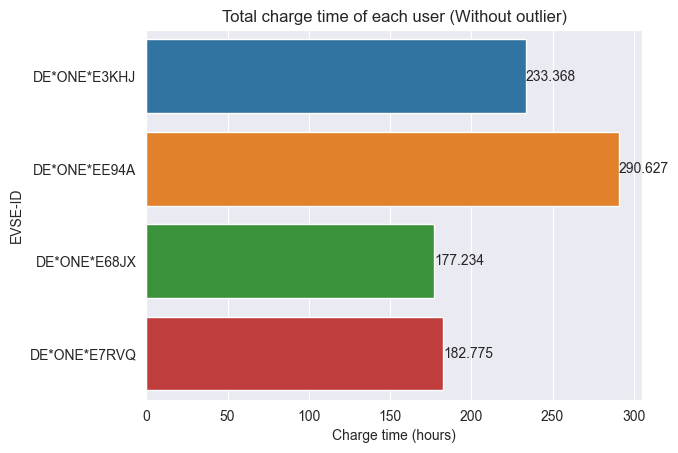

In [94]:
ax = sns.barplot(
    data=user_data_concat,
    y='EVSE-ID',
    x='Charge time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Charge time (hours)')
plt.title('Total charge time of each user (Without outlier)')
plt.savefig('../Images/Public/Redo/charge-session-user-without-outlier', bbox_inches='tight')
plt.show()

### Hogging time of each user

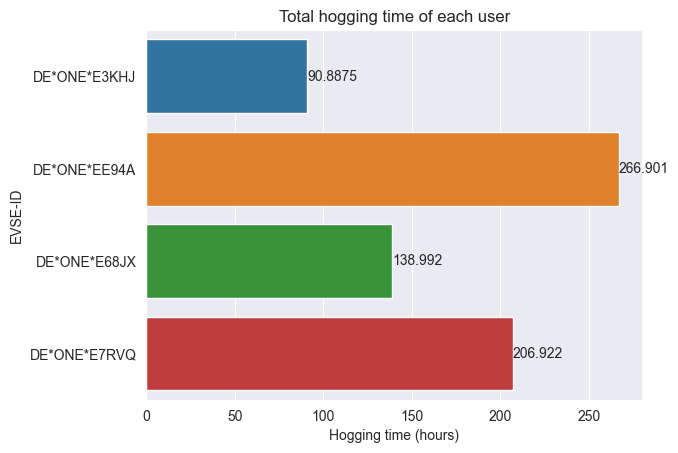

In [34]:
ax = sns.barplot(
    data=user_data,
    y='EVSE-ID',
    x='Hogging time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Hogging time (hours)')
plt.title('Total hogging time of each user')
plt.savefig('../Images/Public/Redo/hogging-time-user', bbox_inches='tight')
plt.show()

#### Without outlier

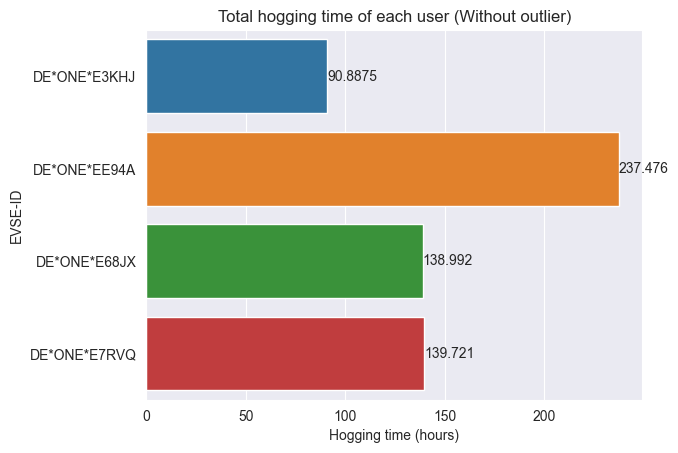

In [95]:
ax = sns.barplot(
    data=user_data_concat,
    y='EVSE-ID',
    x='Hogging time',
    estimator='sum',
    errorbar=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Hogging time (hours)')
plt.title('Total hogging time of each user (Without outlier)')
plt.savefig('../Images/Public/Redo/hogging-time-user-without-outlier', bbox_inches='tight')
plt.show()

### Charge utilization of vehicles

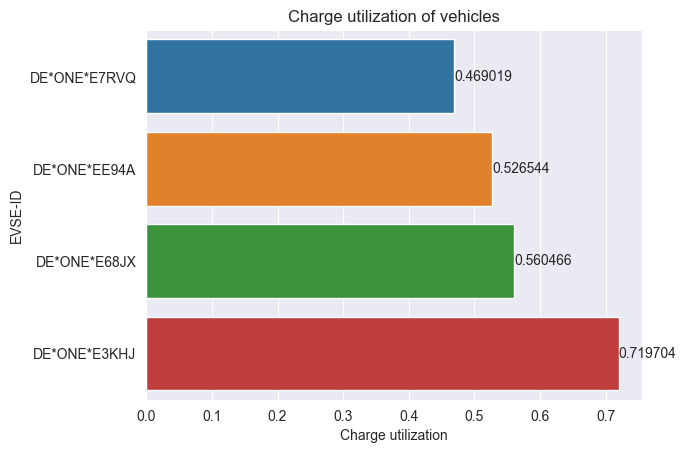

In [36]:
user_data_charge_util = user_data.groupby('EVSE-ID')[['Blocking time', 'Charge time']].sum().reset_index()
user_data_charge_util['Charge utilization'] = user_data_charge_util['Charge time'] / user_data_charge_util['Blocking time']
#fig, ax = plt.subplots(figsize=(10,4))
ax = sns.barplot(
    data=user_data_charge_util.sort_values(['Charge utilization']),
    x='Charge utilization',
    y='EVSE-ID'
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Charge utilization of vehicles')
plt.savefig('../Images/Public/Redo/charge-utilization-user', bbox_inches='tight')
plt.show()

#### Without outlier

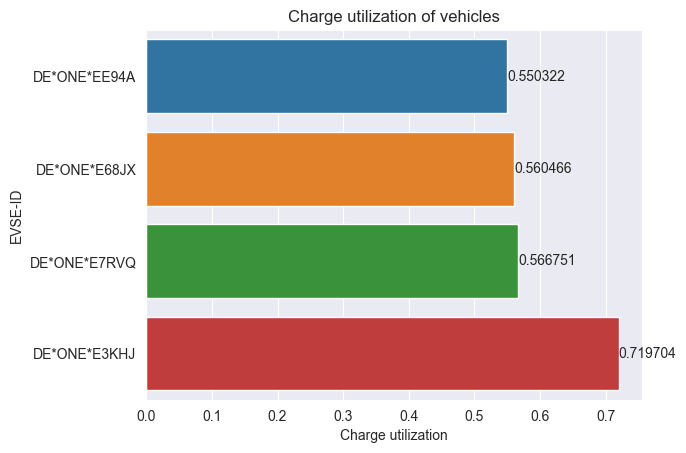

In [96]:
user_data_charge_util = user_data_concat.groupby('EVSE-ID')[['Blocking time', 'Charge time']].sum().reset_index()
user_data_charge_util['Charge utilization'] = user_data_charge_util['Charge time'] / user_data_charge_util['Blocking time']
#fig, ax = plt.subplots(figsize=(10,4))
ax = sns.barplot(
    data=user_data_charge_util.sort_values(['Charge utilization']),
    x='Charge utilization',
    y='EVSE-ID'
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Charge utilization of vehicles')
plt.savefig('../Images/Public/Redo/charge-utilization-user-without-outlier', bbox_inches='tight')
plt.show()

### Consumption per month

In [37]:
user_data.groupby(['Plugged_in_month'])['Verbrauch (kWh)'].sum()

Plugged_in_month
September     806.527
October      1413.450
November     1393.269
December     1696.735
January      1906.173
Name: Verbrauch (kWh), dtype: float64

In [97]:
user_data_concat.groupby(['Plugged_in_month'])['Verbrauch (kWh)'].sum()

Plugged_in_month
September     739.185000
October      1413.450000
November     1278.161857
December     1696.735000
January      1906.173000
Name: Verbrauch (kWh), dtype: float64

September has lower consumption because a session was dropped from the data.

In [38]:
user_data.groupby('Ladestation')['Anschluss'].value_counts()

Ladestation   Anschluss         
ABL_10332049  Ladepunkt 4           71
              Ladepunkt 2           67
              Ladepunkt 3           57
              Ladepunkt 1           39
              Ladepunkt 2 links     39
              Ladepunkt 1 links     34
              Ladepunkt 4 rechts    27
              Ladepunkt 3 rechts    26
Name: count, dtype: int64

In [39]:
# Map the charge points correctly
user_data['Anschluss'] = user_data['Anschluss'].map({
    'Ladepunkt 1': 'Ladepunkt 1',
    'Ladepunkt 1 links': 'Ladepunkt 1',
    'Ladepunkt 2': 'Ladepunkt 2',
    'Ladepunkt 2 links': 'Ladepunkt 2',
    'Ladepunkt 3': 'Ladepunkt 3',
    'Ladepunkt 3 rechts': 'Ladepunkt 3',
    'Ladepunkt 4': 'Ladepunkt 4',
    'Ladepunkt 4 rechts': 'Ladepunkt 4'
})

In [40]:
# Split the charge stations into two
def rename_charge_station(df):
    if df['Anschluss'] == 'Ladepunkt 1' or df['Anschluss'] == 'Ladepunkt 2':
        ladestation = 'ABL_10332049_A'
    else:
        ladestation = 'ABL_10332049_B'
    return ladestation

In [41]:
user_data['Ladestation'] = user_data.apply(rename_charge_station, axis=1)

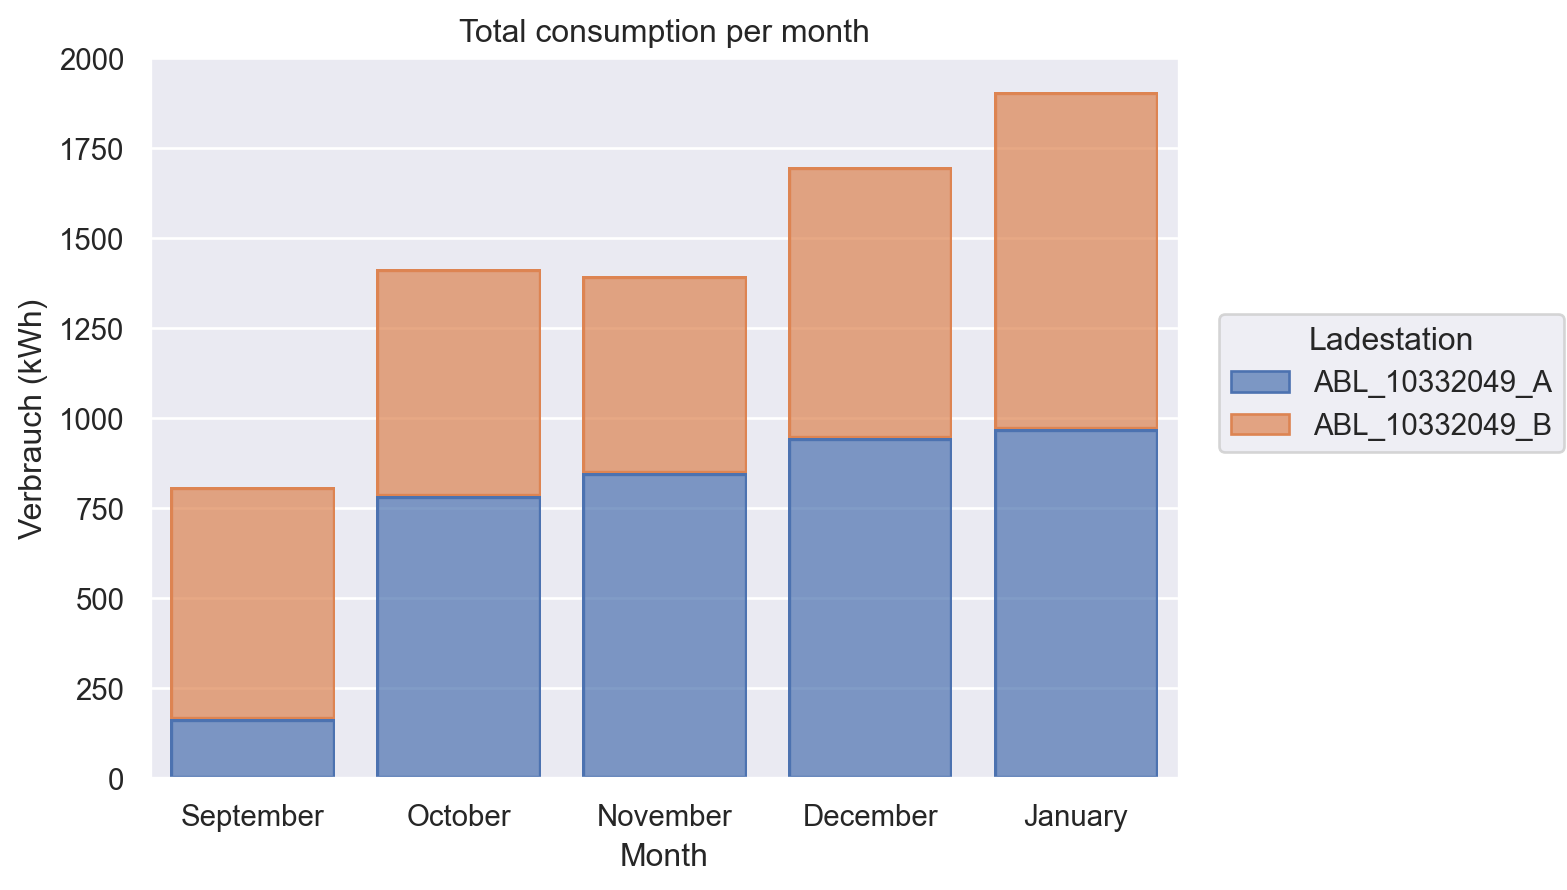

In [42]:
# Obtain consumption of each station per month
x = (
    so.Plot(user_data, x="Plugged_in_month", y='Verbrauch (kWh)', color='Ladestation')
    .add(so.Bar(), so.Agg('sum'), so.Stack())
    .label(y='Verbrauch (kWh)', x='Month', title='Total consumption per month')
)

# Save figure
x.save('../Images/Public/Redo/consumption-per-month')

#### Without outliers

In [98]:
# Map the charge points correctly
user_data_concat['Anschluss'] = user_data_concat['Anschluss'].map({
    'Ladepunkt 1': 'Ladepunkt 1',
    'Ladepunkt 1 links': 'Ladepunkt 1',
    'Ladepunkt 2': 'Ladepunkt 2',
    'Ladepunkt 2 links': 'Ladepunkt 2',
    'Ladepunkt 3': 'Ladepunkt 3',
    'Ladepunkt 3 rechts': 'Ladepunkt 3',
    'Ladepunkt 4': 'Ladepunkt 4',
    'Ladepunkt 4 rechts': 'Ladepunkt 4'
})

In [99]:
user_data_concat['Ladestation'] = user_data_concat.apply(rename_charge_station, axis=1)

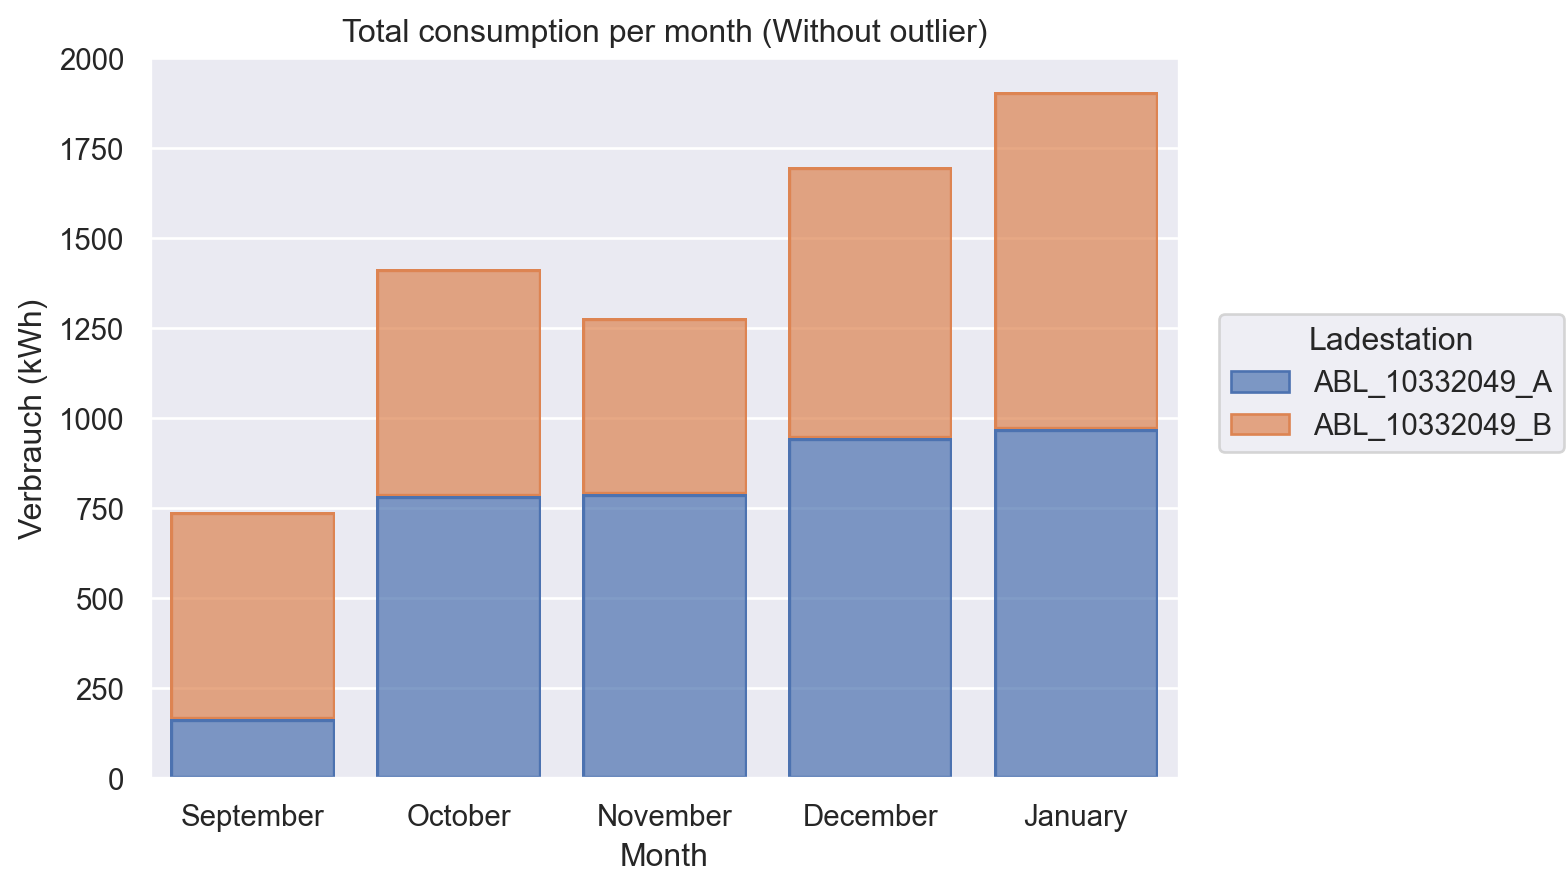

In [100]:
# Obtain consumption of each station per month
x = (
    so.Plot(user_data_concat, x="Plugged_in_month", y='Verbrauch (kWh)', color='Ladestation')
    .add(so.Bar(), so.Agg('sum'), so.Stack())
    .label(y='Verbrauch (kWh)', x='Month', title='Total consumption per month (Without outlier)')
)

# Save figure
x.save('../Images/Public/Redo/consumption-per-month-without-outlier')

In [101]:
user_data_concat.groupby('Plugged_in_month')['Verbrauch (kWh)'].sum()

Plugged_in_month
September     739.185000
October      1413.450000
November     1278.161857
December     1696.735000
January      1906.173000
Name: Verbrauch (kWh), dtype: float64

### Consumption per charge station

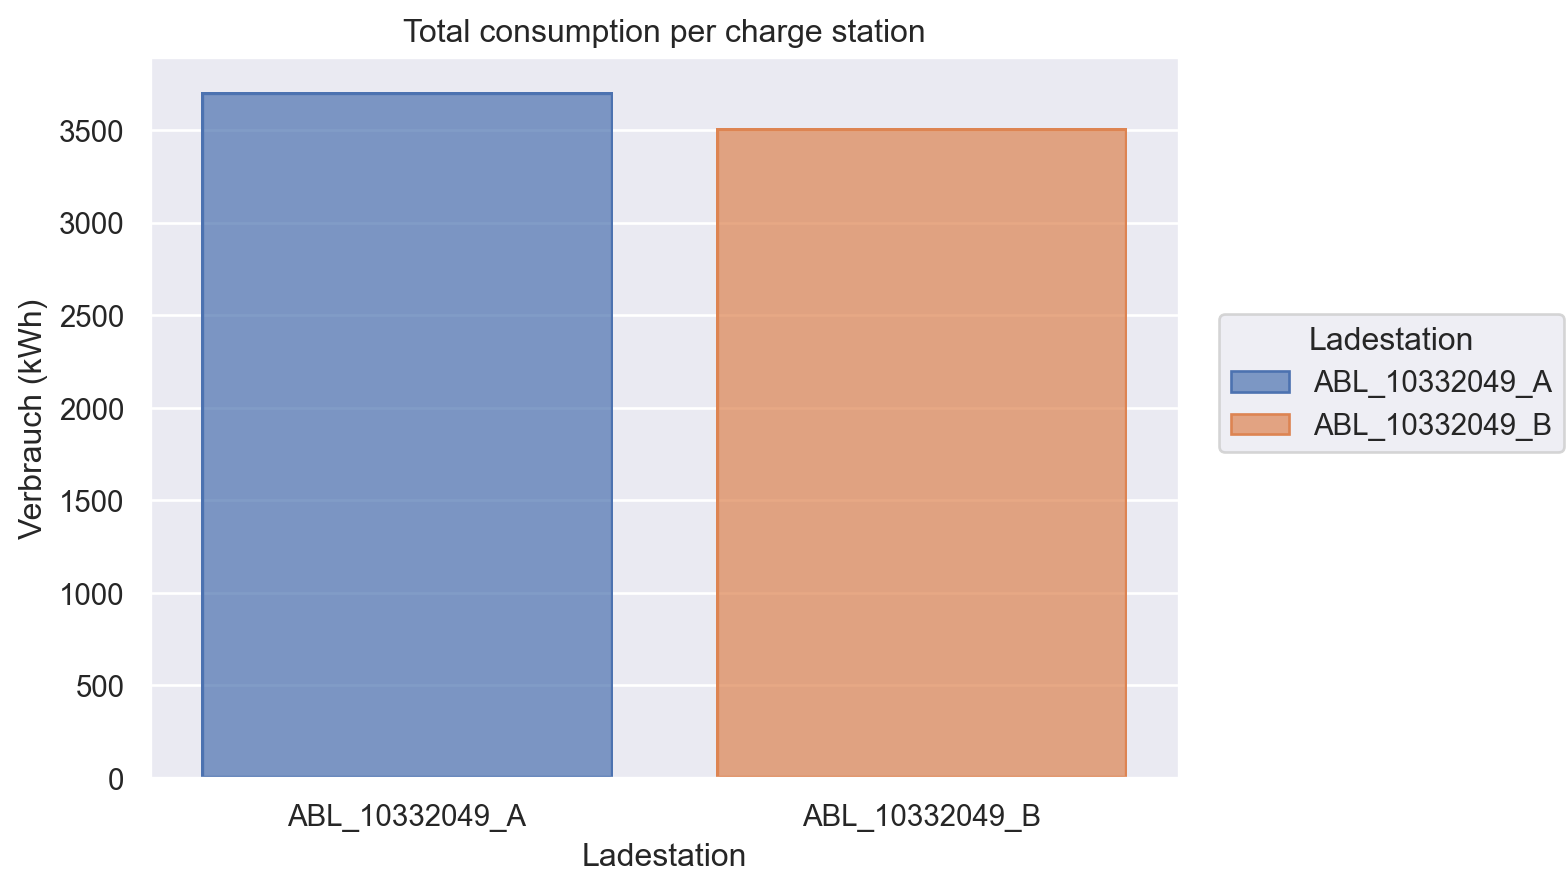

In [43]:
# Stack the consumption of each charge points
x = (
    so.Plot(user_data, x="Ladestation", y='Verbrauch (kWh)', color='Ladestation')
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Verbrauch (kWh)', title='Total consumption per charge station')
)

# Save figure
x.save('../Images/Public/Redo/consumption-per-charge-station')

#### Without outliers

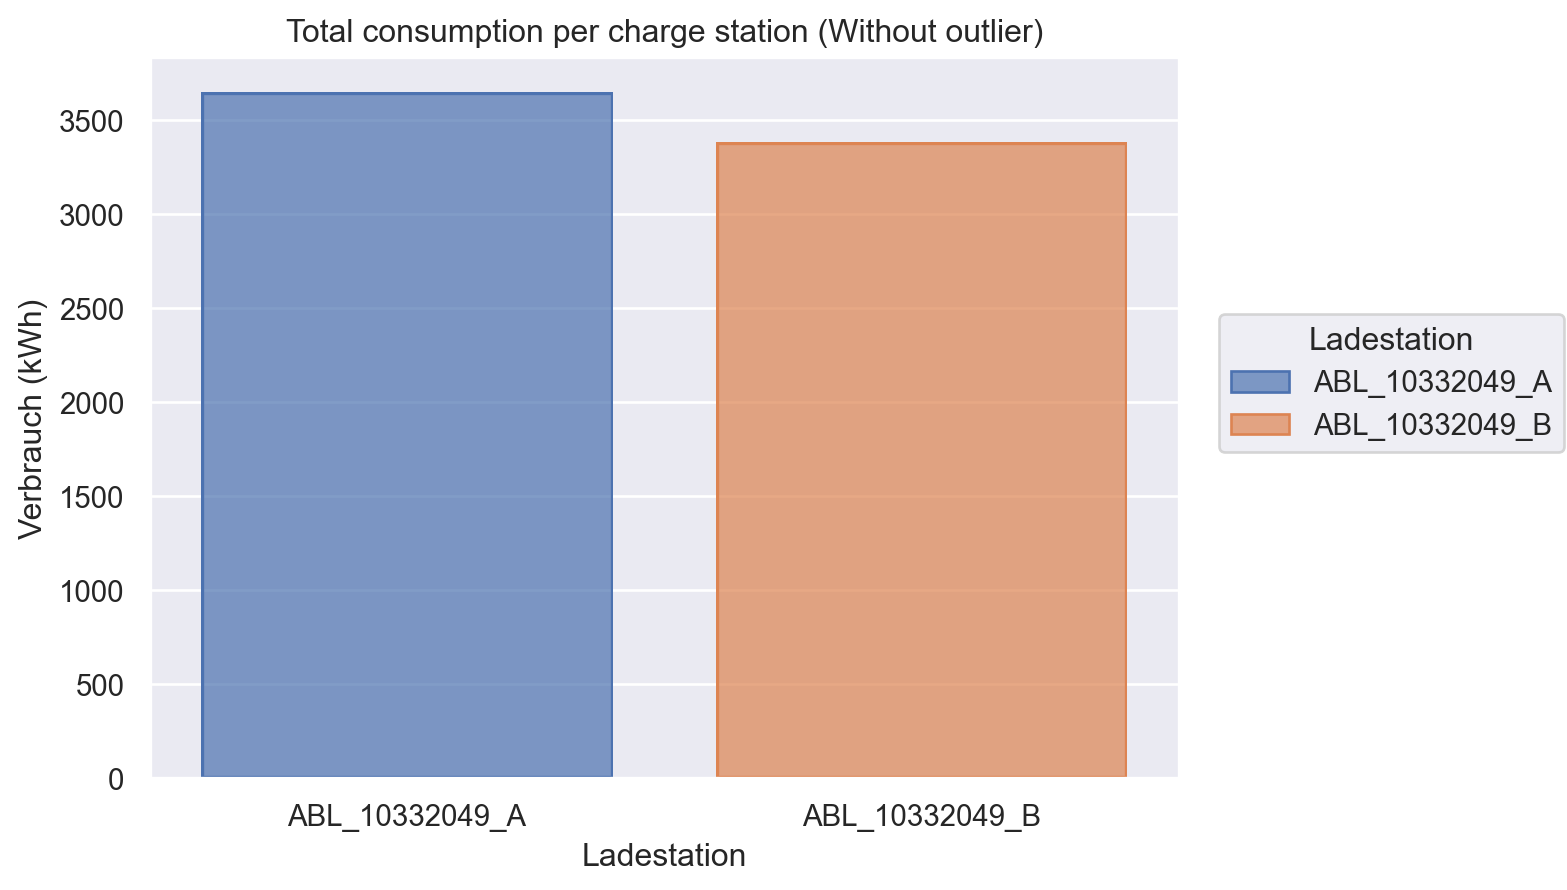

In [102]:
# Stack the consumption of each charge points
x = (
    so.Plot(user_data_concat, x="Ladestation", y='Verbrauch (kWh)', color='Ladestation')
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Verbrauch (kWh)', title='Total consumption per charge station (Without outlier)')
)

# Save figure
x.save('../Images/Public/Redo/consumption-per-charge-station-without-outlier')

### Consumption per charge point

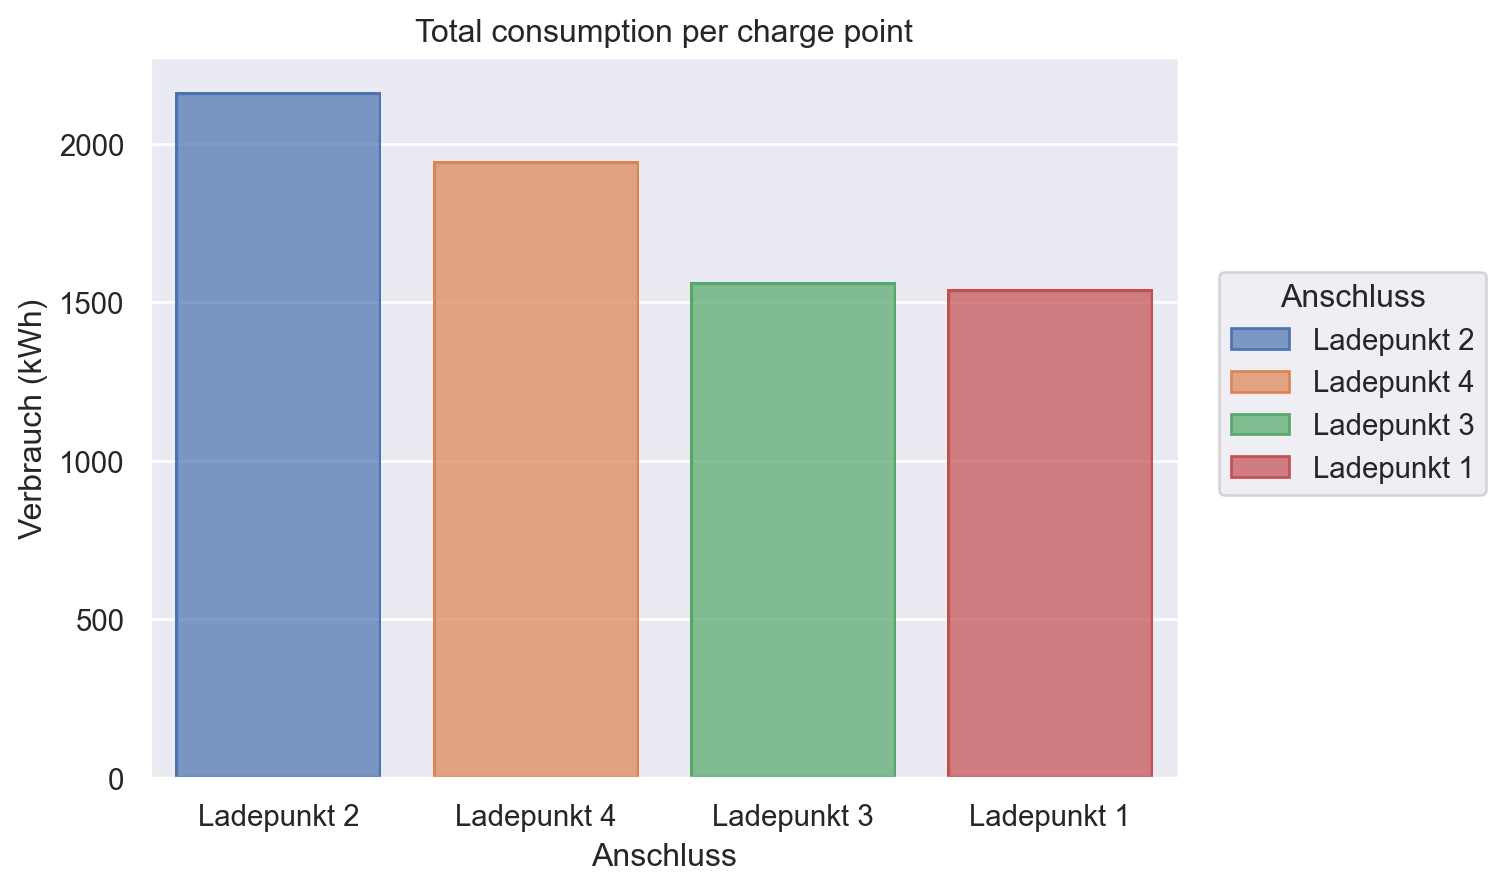

In [44]:
# Stack the consumption of each charge points
x = (
    so.Plot(user_data, x="Anschluss", y='Verbrauch (kWh)', color='Anschluss')
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Verbrauch (kWh)', title='Total consumption per charge point')
)

# Save figure
x.save('../Images/Public/Redo/consumption-per-charge-point')

In [103]:
user_data_concat.groupby(['Standort', 'Ladestation', 'Anschluss'])['Verbrauch (kWh)'].sum()

Standort  Ladestation     Anschluss  
Ulanweg   ABL_10332049_A  Ladepunkt 1    1485.560000
                          Ladepunkt 2    2164.218000
          ABL_10332049_B  Ladepunkt 3    1563.233000
                          Ladepunkt 4    1820.693857
Name: Verbrauch (kWh), dtype: float64

#### Without outliers

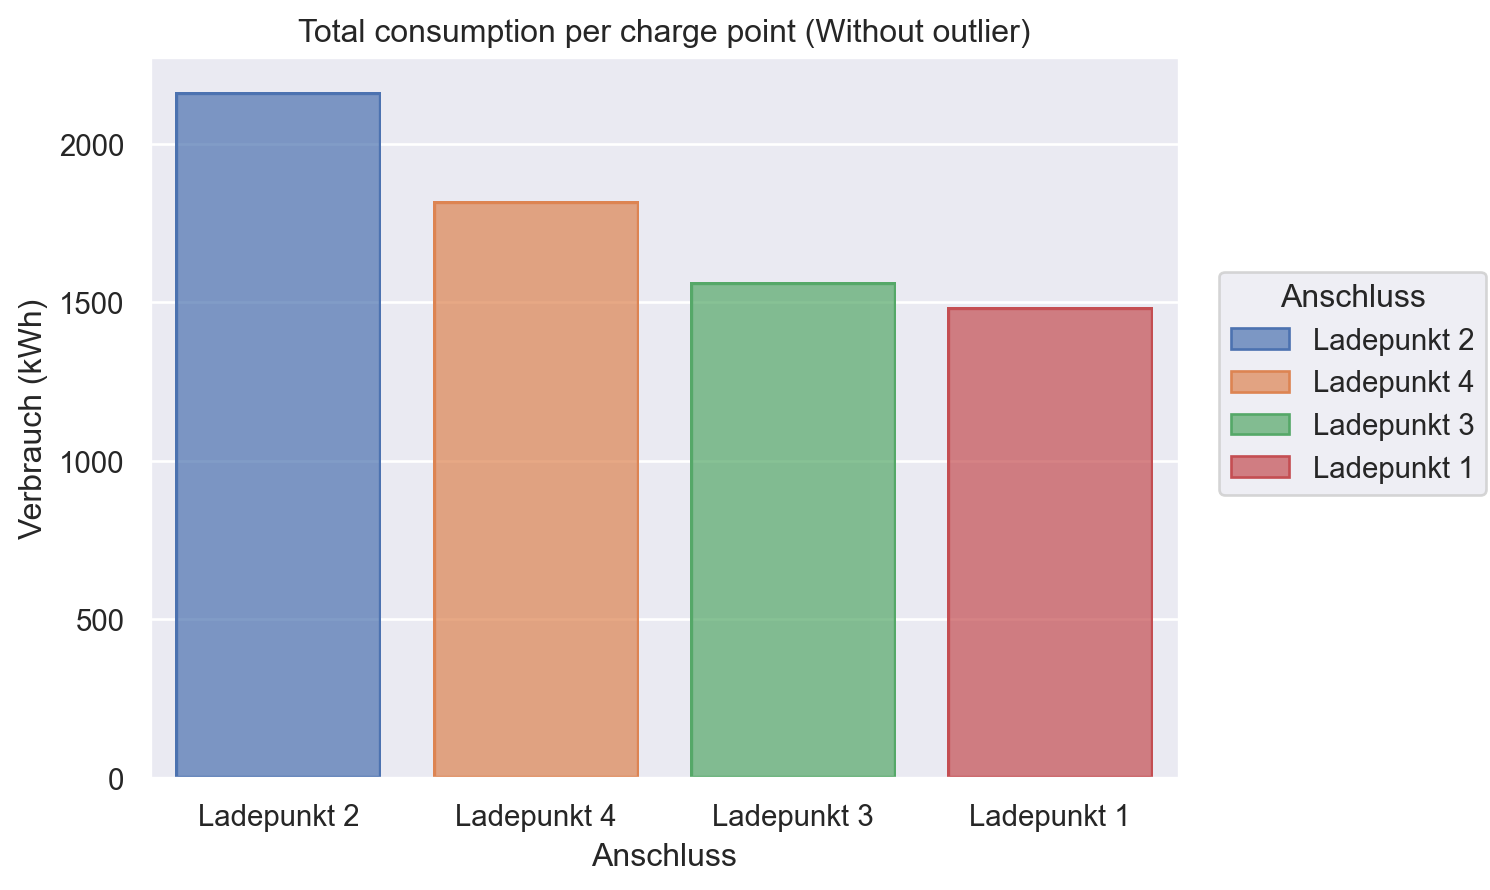

In [104]:
# Stack the consumption of each charge points
x = (
    so.Plot(user_data_concat, x="Anschluss", y='Verbrauch (kWh)', color='Anschluss')
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Verbrauch (kWh)', title='Total consumption per charge point (Without outlier)')
)

# Save figure
x.save('../Images/Public/Redo/consumption-per-charge-point-without-outlier')

### Connection time time per charge station

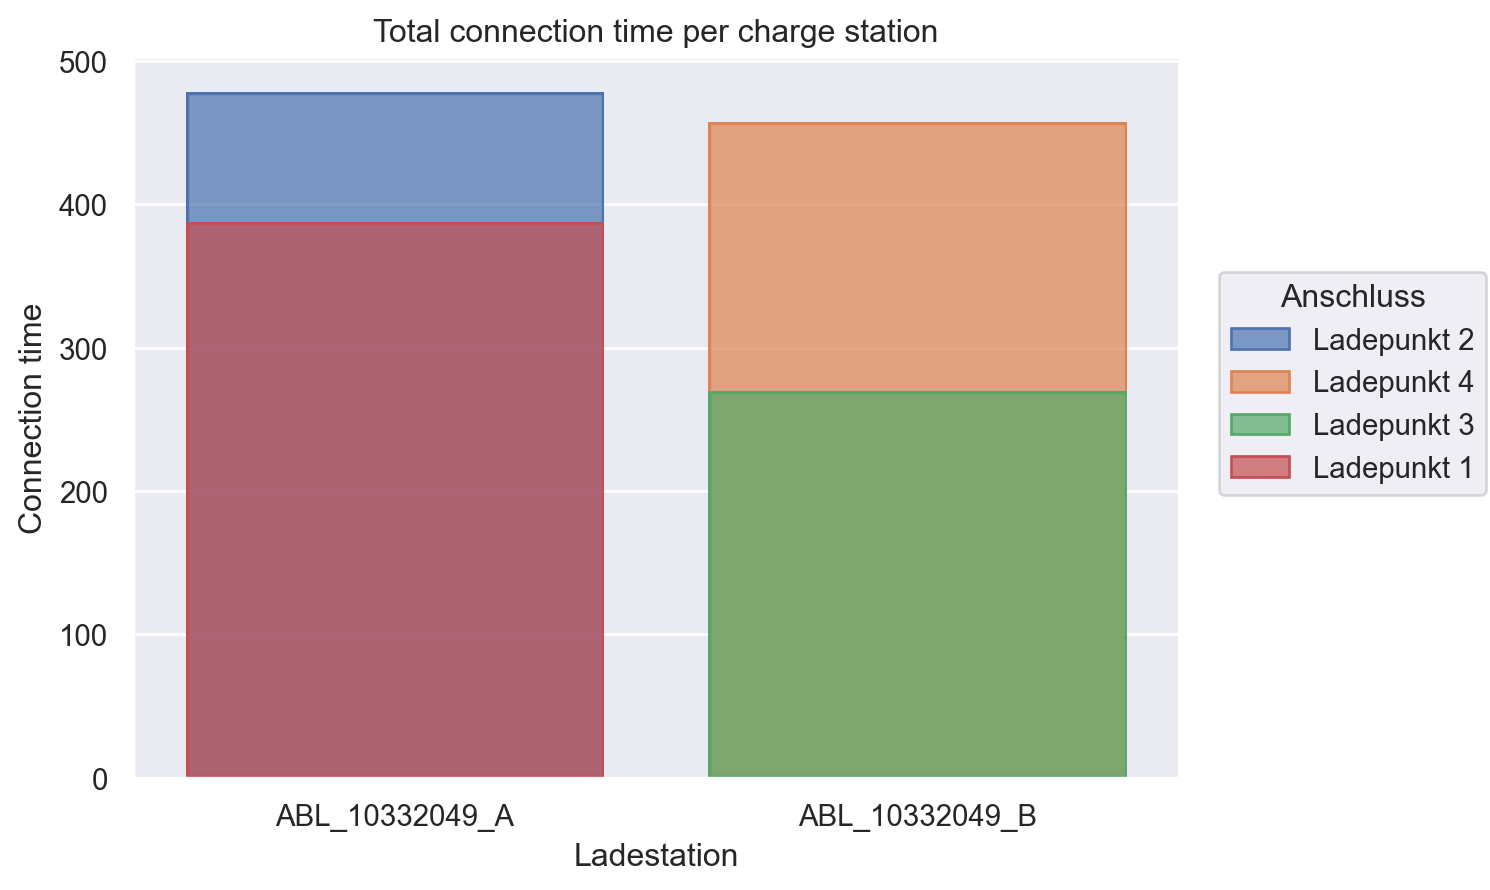

In [45]:
# Stack the connection time of each charge point per station
x = (
    so.Plot(user_data, x="Ladestation", y='Blocking time', color='Anschluss')
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Connection time', title='Total connection time per charge station')
)

# Save figure
x.save('../Images/Public/Redo/connection-time-per-charge-station')

In [46]:
user_data.groupby(['Standort', 'Ladestation'])['Blocking time'].sum()

Standort  Ladestation   
Ulanweg   ABL_10332049_A    866.541944
          ABL_10332049_B    727.366389
Name: Blocking time, dtype: float64

#### Without outliers

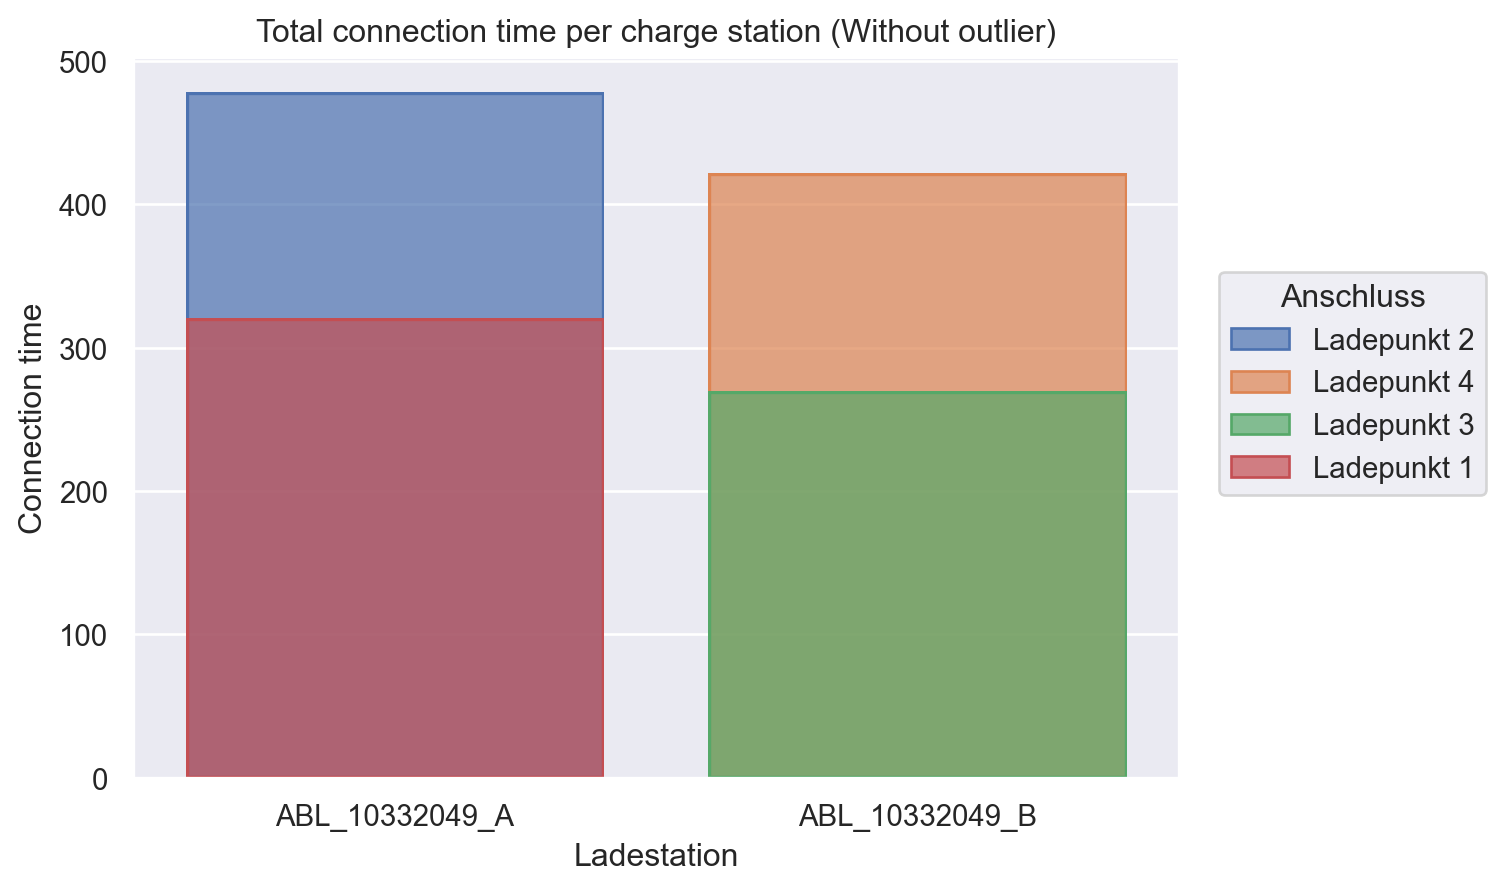

In [105]:
# Stack the connection time of each charge point per station
x = (
    so.Plot(user_data_concat, x="Ladestation", y='Blocking time', color='Anschluss')
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Connection time', title='Total connection time per charge station (Without outlier)')
)

# Save figure
x.save('../Images/Public/Redo/connection-time-per-charge-station-without-outlier')

### Charge time per charge station

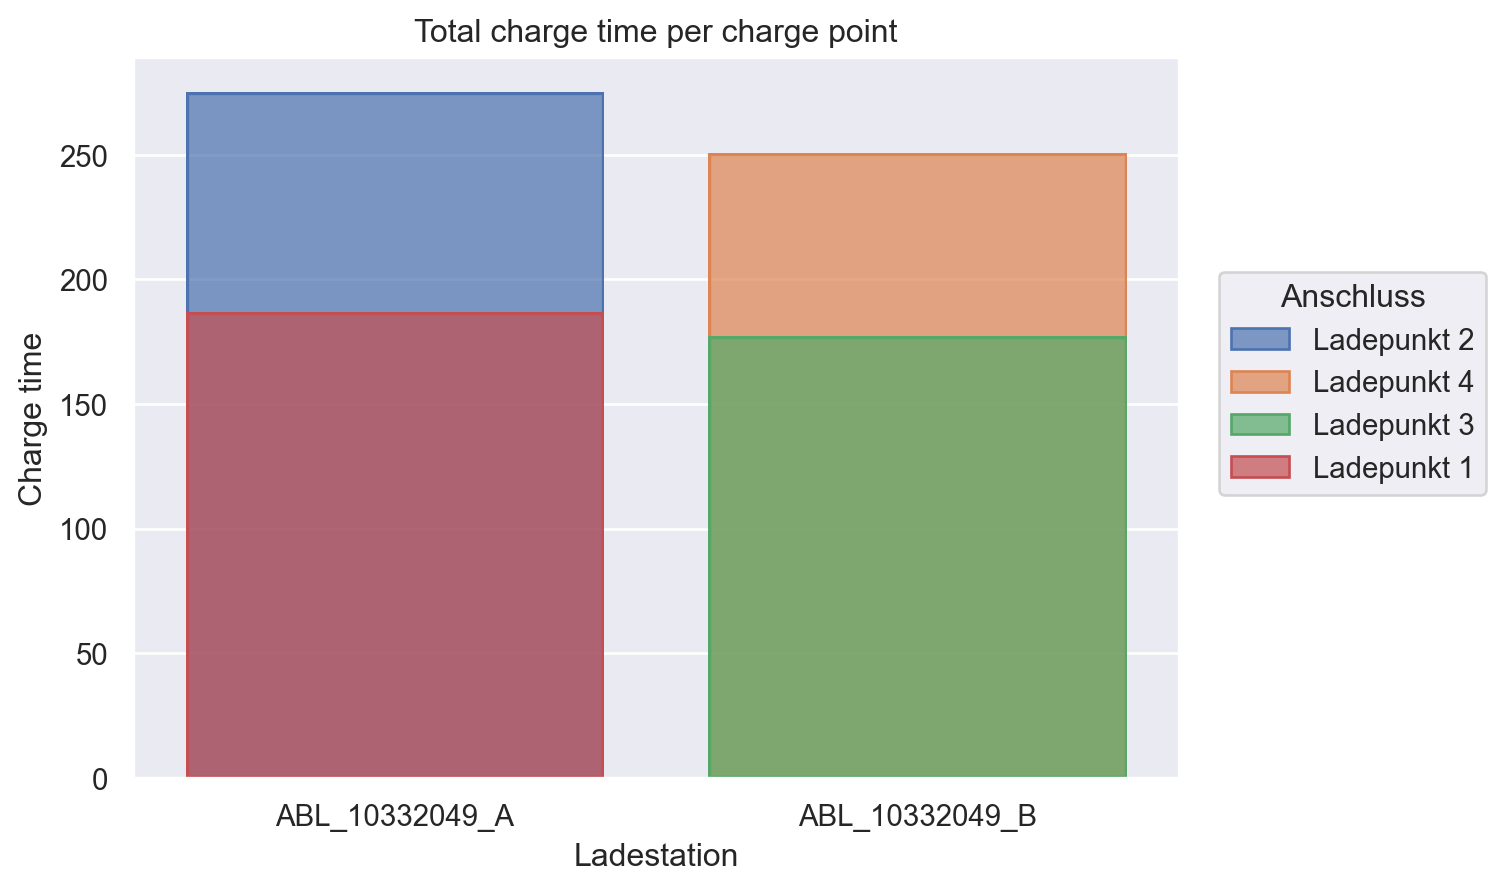

In [47]:
x = (
    so.Plot(user_data, x="Ladestation", y='Charge time', color='Anschluss')
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Charge time', title='Total charge time per charge point')
)
x.save('../Images/Public/Redo/charge-time-per-charge-point')

#### Without outlier

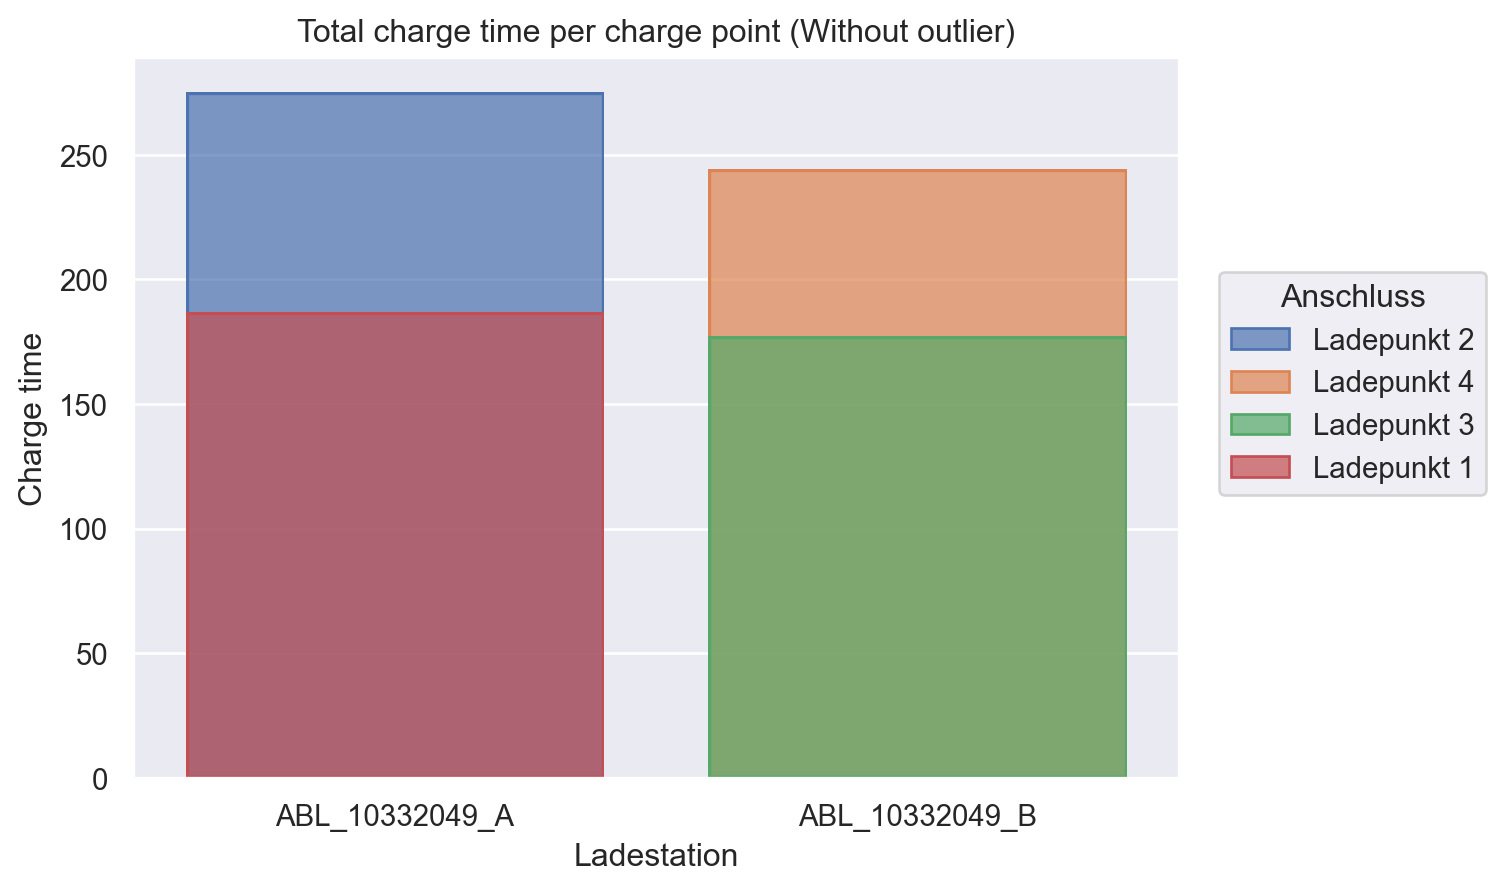

In [106]:
x = (
    so.Plot(user_data_concat, x="Ladestation", y='Charge time', color='Anschluss')
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Charge time', title='Total charge time per charge point (Without outlier)')
)
x.save('../Images/Public/Redo/charge-time-per-charge-point-without-outlier')

### Capacity utilization

In [48]:
# Create a pivot table that contains the total connection time in each month in the charge stations
user_data_blocking_time_sum = pd.pivot_table(user_data, values='Blocking time', columns=['Plugged_in_month'], index=['Ladestation'], aggfunc="sum")

In [49]:
user_data_blocking_time_sum

Plugged_in_month   September     October    November    December     January
Ladestation                                                                 
ABL_10332049_A     22.939167  181.893333  157.605556  246.198611  257.905278
ABL_10332049_B    134.383889  114.341389  138.912778  155.038333  184.690000

In [50]:
# Convert the pivot table to a long format
user_data_blocking_time_month = pd.melt(
    user_data_blocking_time_sum.reset_index(),
    id_vars=['Ladestation'],
    value_vars=['September', 'October', 'November', 'December', 'January'],
    var_name = 'Month',
    value_name = 'Blocking time'
)

In [51]:
user_data.groupby('Plugged_in_month')['Plugged_in_day'].nunique()

Plugged_in_month
September    19
October      27
November     27
December     28
January      29
Name: Plugged_in_day, dtype: int64

In [52]:
# Create a function that calculates capacity utilization for each month
def capacity_util(df):
    #months = df['Month'].values
    if df['Month'] == 9:
        capacity = (df['Blocking time'] / 456) * 100
    elif df['Month'] == 10:
        capacity = (df['Blocking time'] / 648) * 100
    elif df['Month'] == 11:
        capacity = (df['Blocking time'] / 648) * 100
    elif df['Month'] == 12:
        capacity = (df['Blocking time'] / 672) * 100
    else:
        capacity = (df['Blocking time'] / 696) * 100
    return capacity

In [53]:
# Create the capacity utilization column
user_data_blocking_time_month['Capacity utilization'] = user_data_blocking_time_month.apply(capacity_util, axis=1)

In [54]:
# Convert the months to a categorical variable in order to sort it
user_data_blocking_time_month['Month'] = pd.Categorical(
    user_data_blocking_time_month['Month'],
    categories=['September', 'October', 'November', 'December', 'January']
)

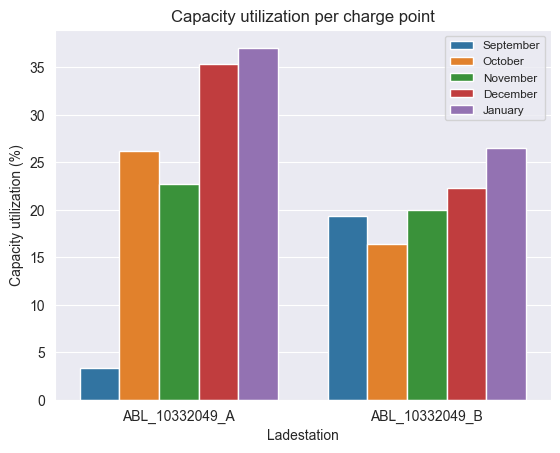

In [55]:
# Create a barplot of the capacity utilization of each month in each charge point
sns.barplot(
    data=user_data_blocking_time_month.sort_values('Capacity utilization'),
    x='Ladestation',
    y='Capacity utilization',
    hue='Month'
)
plt.ylabel('Capacity utilization (%)')
plt.title('Capacity utilization per charge point')
plt.legend(fontsize=8.5)
#plt.legend([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])

# Save figure
plt.savefig('../Images/Public/Redo/capacity-utilization-per-charge-station')
plt.show()

In [56]:
user_data_blocking_time_month.groupby('Ladestation')['Capacity utilization'].mean()

Ladestation
ABL_10332049_A    24.900631
ABL_10332049_B    20.901333
Name: Capacity utilization, dtype: float64

#### Without outliers

In [107]:
# Create a pivot table that contains the total connection time in each month in the charge stations
user_data_concat_blocking_time_sum = pd.pivot_table(user_data_concat, values='Blocking time', columns=['Plugged_in_month'], index=['Ladestation'], aggfunc="sum")

In [108]:
# Convert the pivot table to a long format
user_data_concat_blocking_time_month = pd.melt(
    user_data_concat_blocking_time_sum.reset_index(),
    id_vars=['Ladestation'],
    value_vars=['September', 'October', 'November', 'December', 'January'],
    var_name = 'Month',
    value_name = 'Blocking time'
)

In [109]:
user_data_concat.groupby('Plugged_in_month')['Plugged_in_day'].nunique()

Plugged_in_month
September    18
October      27
November     27
December     28
January      29
Name: Plugged_in_day, dtype: int64

In [110]:
# Create a function that calculates capacity utilization for each month
def capacity_util(df):
    #months = df['Month'].values
    if df['Month'] == 9:
        capacity = (df['Blocking time'] / 432) * 100
    elif df['Month'] == 10:
        capacity = (df['Blocking time'] / 648) * 100
    elif df['Month'] == 11:
        capacity = (df['Blocking time'] / 648) * 100
    elif df['Month'] == 12:
        capacity = (df['Blocking time'] / 672) * 100
    else:
        capacity = (df['Blocking time'] / 696) * 100
    return capacity

In [111]:
# Create the capacity utilization column
user_data_concat_blocking_time_month['Capacity utilization'] = user_data_concat_blocking_time_month.apply(capacity_util, axis=1)

In [112]:
# Convert the months to a categorical variable in order to sort it
user_data_concat_blocking_time_month['Month'] = pd.Categorical(
    user_data_concat_blocking_time_month['Month'],
    categories=['September', 'October', 'November', 'December', 'January']
)

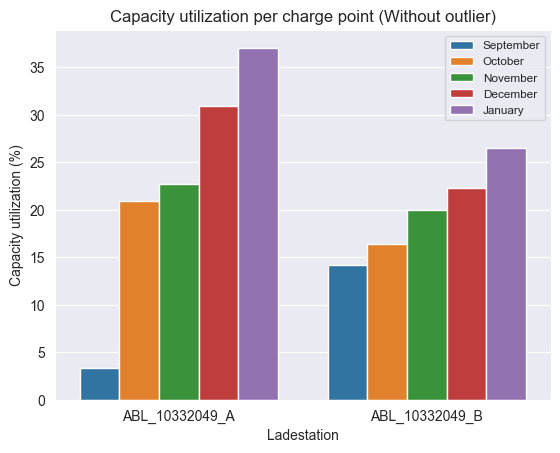

In [113]:
# Create a barplot of the capacity utilization of each month in each charge point
sns.barplot(
    data=user_data_concat_blocking_time_month.sort_values('Capacity utilization'),
    x='Ladestation',
    y='Capacity utilization',
    hue='Month'
)
plt.ylabel('Capacity utilization (%)')
plt.title('Capacity utilization per charge point (Without outlier)')
plt.legend(fontsize=8.5)
#plt.legend([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])

# Save figure
plt.savefig('../Images/Public/Redo/capacity-utilization-per-charge-station-without-outlier')
plt.show()

In [114]:
user_data_concat_blocking_time_month.groupby('Ladestation')['Capacity utilization'].mean()

Ladestation
ABL_10332049_A    22.969587
ABL_10332049_B    19.877554
Name: Capacity utilization, dtype: float64

### Daytime users Blocking time

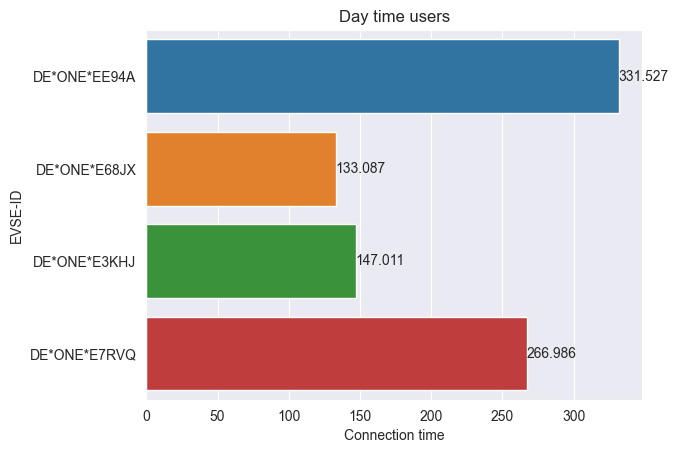

In [57]:
ax = sns.barplot(
    data=user_data_daytime,
    y='EVSE-ID',
    x='Blocking time',
    estimator='sum',
    ci=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Day time users')
plt.xlabel('Connection time')

# Save figure
plt.savefig('../Images/Public/Redo/day-time-users-blocking-time', bbox_inches='tight')
plt.show()

### Daytime users charge time

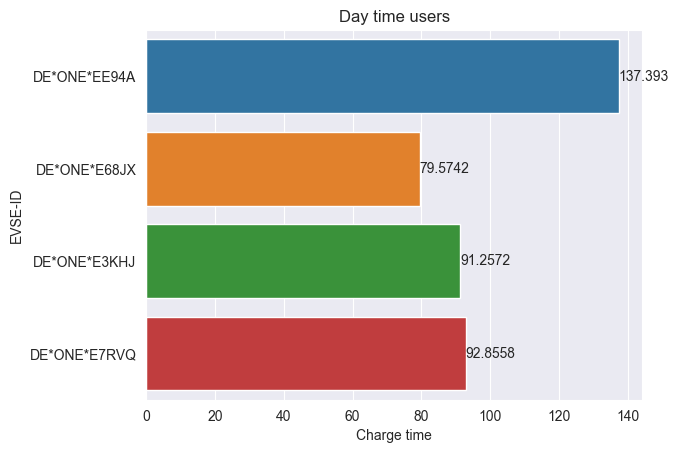

In [58]:
ax = sns.barplot(
    data=user_data_daytime,
    y='EVSE-ID',
    x='Charge time',
    estimator='sum',
    ci=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Day time users')
plt.xlabel('Charge time')

# Save figure
plt.savefig('../Images/Public/Redo/day-time-users-charge-time', bbox_inches='tight')
plt.show()

### Daytime and nighttime consumption

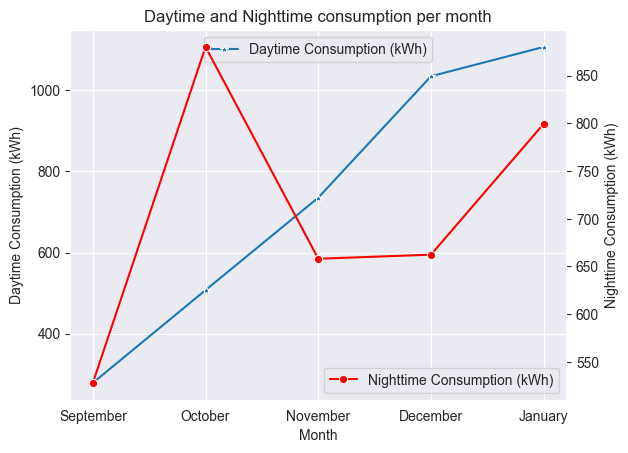

In [59]:
fig, ax = plt.subplots()

sns.lineplot(
    data=user_data_daytime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax,
    estimator='sum',
    ci=None,
    label='Daytime Consumption (kWh)',
    marker='*'
)
#ax.tick_params(axis='y', labelcolor='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Daytime Consumption (kWh)')

ax2 = ax.twinx()
ax2.grid(False)

sns.lineplot(
    data=user_data_nighttime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax2,
    estimator='sum',
    ci=None,
    color='red',
    label='Nighttime Consumption (kWh)',
    marker='o'
)
#plt.xticks([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
#ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Nighttime Consumption (kWh)')
ax.legend(loc='upper center')
ax2.legend(loc='lower right')
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)
plt.title('Daytime and Nighttime consumption per month')

# Save figure
plt.savefig('../Images/Public/Redo/daytime-nighttime-consumption-per-month')
plt.show()

#### Without outliers

In [115]:
# Extract daytime data
user_data_concat_daytime = user_data_concat.set_index('Ausgesteckt am').between_time('6:00', '18:00').reset_index()

# Extract nighttime data
user_data_concat_nighttime = user_data_concat.set_index('Ausgesteckt am').between_time('18:01', '5:59').reset_index()

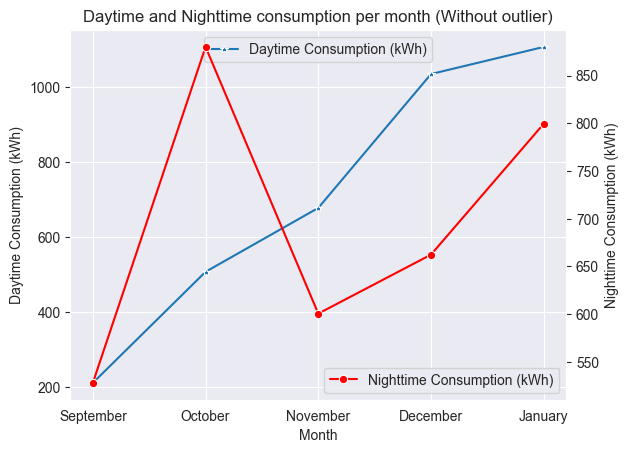

In [116]:
fig, ax = plt.subplots()

sns.lineplot(
    data=user_data_concat_daytime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax,
    estimator='sum',
    ci=None,
    label='Daytime Consumption (kWh)',
    marker='*'
)
#ax.tick_params(axis='y', labelcolor='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Daytime Consumption (kWh)')

ax2 = ax.twinx()
ax2.grid(False)

sns.lineplot(
    data=user_data_concat_nighttime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax2,
    estimator='sum',
    ci=None,
    color='red',
    label='Nighttime Consumption (kWh)',
    marker='o'
)
#plt.xticks([9, 10, 11, 12, 1], labels=['September', 'October', 'November', 'December', 'January'])
#ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Nighttime Consumption (kWh)')
ax.legend(loc='upper center')
ax2.legend(loc='lower right')
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)
plt.title('Daytime and Nighttime consumption per month (Without outlier)')

# Save figure
plt.savefig('../Images/Public/Redo/daytime-nighttime-consumption-per-month-without-outlier')
plt.show()

In [117]:
user_data_concat_nighttime.groupby('Plugged_in_month')['Verbrauch (kWh)'].sum()

Plugged_in_month
September    527.959
October      880.025
November     600.585
December     662.362
January      799.510
Name: Verbrauch (kWh), dtype: float64

### Charge sessions per month

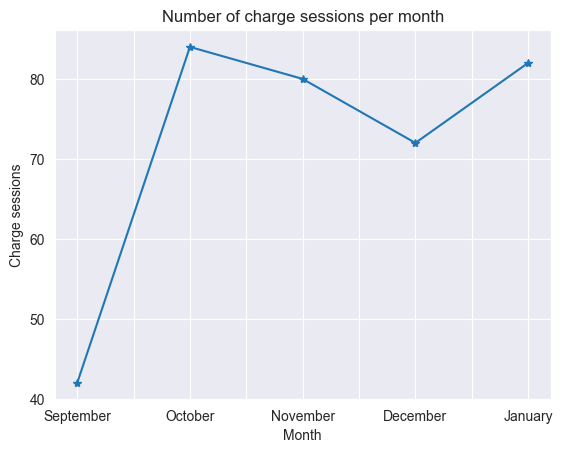

In [60]:
user_data.groupby('Plugged_in_month')['Charge time'].count().plot(kind='line', marker='*')
#plt.xticks([9,10,11], labels=['September', 'October', 'November'])
plt.xlabel('Month')
plt.ylabel('Charge sessions')
plt.title('Number of charge sessions per month')

# Save figure
plt.savefig('../Images/Public/Redo/charge-sessions-per-month')
plt.show()

### Charge sessions per point

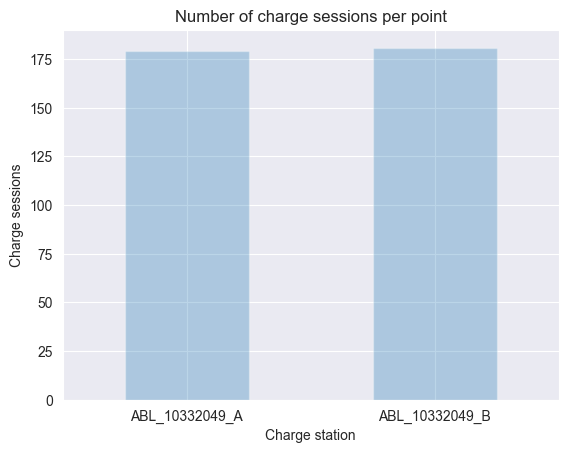

In [61]:
user_data.groupby('Ladestation')['Charge time'].count().plot(kind='bar', alpha=0.3)
#user_data.groupby('Anschluss')['Charge time'].count().plot(kind='line', marker='*')
plt.xlabel('Charge station')
plt.ylabel('Charge sessions')
plt.xticks(rotation=0)
plt.title('Number of charge sessions per point')

# Save figure
plt.savefig('../Images/Public/Redo/charge-sessions-per-charge-point')
plt.show()

### Consumption per session per month

In [62]:
amount_of_consumption = user_data.groupby('Plugged_in_month')['Verbrauch (kWh)'].sum()
num_of_sessions = user_data.groupby('Plugged_in_month')['Charge time'].count()

user_data_kwh_per_session = (amount_of_consumption / num_of_sessions).reset_index()

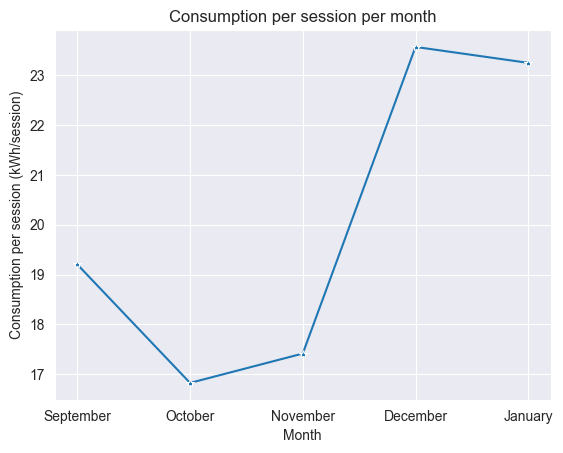

In [63]:
sns.lineplot(
    data=user_data_kwh_per_session,
    x='Plugged_in_month',
    y=0,
    marker='*'
)
plt.xlabel('Month')
plt.ylabel('Consumption per session (kWh/session)')
plt.title('Consumption per session per month')

# Save figure
plt.savefig('../Images/Public/Redo/consumption-per-session-per-month')
plt.show()

In [64]:
user_data_kwh_per_session[0].mean()

20.05148962156407

### Median connection time for each day in each month

In [65]:
# Create a pivot table that contains the median connection time for each day in each month
median_connection_time = pd.pivot_table(user_data, values='Blocking time', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="median")
median_connection_time

Plugged_in_dayname    Sunday     Monday   Tuesday  Wednesday  Thursday  \
Plugged_in_month                                                         
September           3.543333  12.576944  1.776389   2.491389  3.644722   
October             2.461667   3.313889  2.835000   2.213611  3.342361   
November            3.440556   3.821389  3.011250   3.703889  6.835694   
December            2.873611   3.632222  2.148056   4.291389  3.595556   
January             4.949444   3.062917  2.792778   4.238611  2.739028   

Plugged_in_dayname    Friday  Saturday  
Plugged_in_month                        
September           2.147500  2.616806  
October             1.647083  2.571667  
November            1.652500  2.531250  
December            2.320278  3.083472  
January             3.575000  3.301389

### Mean connection time for each day in each month

In [118]:
# Create a pivot table that contains the mean connection time for each day in each month in the corrected data
mean_connection_time = pd.pivot_table(user_data_concat, values='Blocking time', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="mean")
mean_connection_time

Plugged_in_dayname    Sunday    Monday   Tuesday  Wednesday  Thursday  \
Plugged_in_month                                                        
September           3.139015  9.370972  1.910347   2.516759  3.426389   
October             2.965900  3.275340  2.628730   3.762374  3.398148   
November            3.479648  5.516481  3.953056   4.757500  6.909236   
December            3.741984  9.830778  5.760802   6.603889  5.104028   
January             7.992111  6.621151  3.602576   7.823500  3.174352   

Plugged_in_dayname    Friday  Saturday  
Plugged_in_month                        
September           2.085056  2.425162  
October             2.733576  3.264056  
November            3.237350  2.762222  
December            3.955758  4.989756  
January             5.480429  3.597042

### Median energy consumption for each day in each month

In [66]:
# Create a pivot table that contains the total median consumption for each day in each month
median_energy = pd.pivot_table(user_data, values='Verbrauch (kWh)', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="median")
median_energy

Plugged_in_dayname   Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  \
Plugged_in_month                                                            
September           37.3320  16.400   15.273    24.9740   10.8240  10.293   
October             10.8010  10.641   10.098    17.9760   11.1420  11.114   
November            13.6890  15.801   13.254     9.9995   12.4265   8.659   
December            26.1545  13.674   18.171    14.8350   30.9280  12.095   
January             28.7420  20.344   18.083    15.5040   15.7660  15.443   

Plugged_in_dayname  Saturday  
Plugged_in_month              
September            10.1325  
October              11.0015  
November             12.1325  
December             19.6125  
January              12.6645

### Mean energy consumption for each day in each month

In [119]:
# Create a pivot table that contains the mean consumption for each day in each month in the corrected data
mean_energy = pd.pivot_table(user_data_concat, values='Verbrauch (kWh)', columns=['Plugged_in_dayname'], index=['Plugged_in_month'], aggfunc="mean")
mean_energy

Plugged_in_dayname     Sunday     Monday    Tuesday  Wednesday   Thursday  \
Plugged_in_month                                                            
September           27.372000  16.130500  15.561000  20.169000  17.156000   
October             16.251360  14.696222  13.854000  19.255909  18.340167   
November            18.611600  21.651643  18.009500  16.799000  19.964250   
December            25.417071  23.361600  23.653556  19.140800  29.020750   
January             33.153400  19.643357  21.813727  33.237200  17.718500   

Plugged_in_dayname     Friday   Saturday  
Plugged_in_month                          
September           11.432000  13.108083  
October             16.648312  18.969300  
November             7.625308  15.831692  
December            15.803909  26.065667  
January             18.902000  20.674750

### Average connection and charge time per month

In [67]:
# Create a pivot table that contains the median connection and charge times for each day in each month
avg_connection_time = pd.pivot_table(user_data, values=['Blocking time', 'Charge time'], index=['Plugged_in_month'], aggfunc="mean")
avg_connection_time

Blocking time  Charge time
Plugged_in_month                            
September              3.745787     2.227652
October                3.526604     2.290807
November               3.706479     2.476385
December               5.572735     2.610313
January                5.397503     2.660528

#### Without outliers

In [120]:
# Create a pivot table that contains the median connection time for each day in each month in the corrected data
avg_connection_time = pd.pivot_table(user_data_concat, values=['Blocking time', 'Charge time'], index=['Plugged_in_month'], aggfunc="mean")
avg_connection_time

Blocking time  Charge time
Plugged_in_month                            
September              2.968184     2.130718
October                3.097374     2.290807
November               3.706479     2.476385
December               5.140165     2.610313
January                5.397503     2.660528

## Forecasting

In [254]:
user_data_concat_copy = user_data_concat.copy()

In [255]:
user_data_concat_copy.drop([278], inplace=True)

In [256]:
user_data_concat_copy['Plugged_in_month'] = user_data_concat_copy['Plugged_in_month'].map({
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12,
    'January': 1
})

In [257]:
user_data_concat_copy['Plugged_in_month'] = user_data_concat_copy['Plugged_in_month'].astype(int)

In [258]:
user_data_concat_copy['Ladestation'] = user_data_concat_copy['Ladestation'].map({
    'ABL_10332049_A': 0,
    'ABL_10332049_B': 1
})
user_data_concat_copy['Ladestation'] = user_data_concat_copy['Ladestation'].astype(int)

In [259]:
user_data_concat_copy['Anschluss'] = user_data_concat_copy['Anschluss'].map({
    'Ladepunkt 1': 0,
    'Ladepunkt 2': 1,
    'Ladepunkt 3': 2,
    'Ladepunkt 4': 3
})
user_data_concat_copy['Anschluss'] = user_data_concat_copy['Anschluss'].astype(int)

In [260]:
user_data_concat_copy['EVSE-ID'].unique()

array(['DE*ONE*E3KHJ', 'DE*ONE*EE94A', 'DE*ONE*E68JX', 'DE*ONE*E7RVQ'],
      dtype=object)

In [261]:
user_data_concat_copy['EVSE-ID'] = user_data_concat_copy['EVSE-ID'].map({
    'DE*ONE*E3KHJ': 0,
    'DE*ONE*EE94A': 1,
    'DE*ONE*E68JX': 2,
    'DE*ONE*E7RVQ': 3
})

In [263]:
user_data_concat_copy['Eingesteckt am'] = user_data_concat_copy['Eingesteckt am'].dt.date

In [264]:
user_data_concat_copy.set_index('Eingesteckt am', inplace=True)

In [265]:
user_data_concat_copy

Nutzergruppe  Kostenstelle  Nutzer/Fahrzeug  \
Eingesteckt am                                                      
2023-09-01      Öffentliches Laden           NaN  eRoaming Nutzer   
2023-09-02      Öffentliches Laden           NaN  eRoaming Nutzer   
2023-09-02      Öffentliches Laden           NaN  eRoaming Nutzer   
2023-09-02      Öffentliches Laden           NaN  eRoaming Nutzer   
2023-09-03      Öffentliches Laden           NaN  eRoaming Nutzer   
...                            ...           ...              ...   
2024-01-28      Öffentliches Laden           NaN  eRoaming Nutzer   
2024-01-29      Öffentliches Laden           NaN  eRoaming Nutzer   
2024-01-30      Öffentliches Laden           NaN  eRoaming Nutzer   
2024-01-30      Öffentliches Laden           NaN  eRoaming Nutzer   
2024-01-30      Öffentliches Laden           NaN  eRoaming Nutzer   

                  Ladekarte          Ausgesteckt am   Ladedauer  \
Eingesteckt am                                                    
2023-09-01      <unbekannt> 2023-09-01 19:34:58.064  2h 49m 45s   
2023-09-02      <unbekannt> 2023-09-02 11:05:53.221  1h 27m 26s   
2023-09-02      <unbekannt> 2023-09-02 13:56:01.025  2h 25m 35s   
2023-09-02      <unbekannt> 2023-09-02 13:07:01.016  0h 42m 26s   
2023-09-03      <unbekannt> 2023-09-03 05:54:16.109  4h 39m 45s   
...                     ...                     ...         ...   
2024-01-28      <unbekannt> 2024-01-28 16:29:30.756  3h 30m 35s   
2024-01-29      <unbekannt> 2024-01-29 19:47:00.651  1h 47m 06s   
2024-01-30      <unbekannt> 2024-01-30 19:12:10.334  1h 22m 58s   
2024-01-30      <unbekannt> 2024-01-30 22:25:16.971  3h 44m 02s   
2024-01-30      <unbekannt> 2024-01-31 07:16:51.333  8h 25m 37s   

               Zeit angesteckt Standort  Ladestation  Anschluss  EVSE-ID  \
Eingesteckt am                                                             
2023-09-01          3h 19m 16s  Ulanweg            0          1        0   
2023-09-02          1h 27m 44s  Ulanweg            1          3        1   
2023-09-02          2h 44m 53s  Ulanweg            1          3        1   
2023-09-02          0h 43m 02s  Ulanweg            1          2        2   
2023-09-03          4h 53m 43s  Ulanweg            1          3        1   
...                        ...      ...          ...        ...      ...   
2024-01-28          3h 31m 40s  Ulanweg            1          3        3   
2024-01-29          3h 16m 58s  Ulanweg            1          2        0   
2024-01-30          2h 50m 46s  Ulanweg            1          2        0   
2024-01-30          3h 44m 45s  Ulanweg            0          1        1   
2024-01-30         12h 25m 25s  Ulanweg            0          0        2   

                Kommentar  Preis pro kWh  Verbrauch (kWh)  Netto Kosten (kWh)  \
Eingesteckt am                                                                  
2023-09-01            NaN         0.4952           10.293                4.28   
2023-09-02            NaN         0.4952            5.035                2.10   
2023-09-02            NaN         0.4952            8.325                3.46   
2023-09-02            NaN         0.4952            7.598                3.16   
2023-09-03            NaN         0.4952           51.301               21.35   
...                   ...            ...              ...                 ...   
2024-01-28            NaN         0.4952           38.056               15.84   
2024-01-29            NaN         0.4952           11.237                4.68   
2024-01-30            NaN         0.4952           10.049                4.18   
2024-01-30            NaN         0.4952           28.906               12.03   
2024-01-30            NaN         0.4952           81.095               33.75   

                Steuersatz (kWh)  Steuer Kosten (kWh)  Brutto Kosten (kWh)  \
Eingesteckt am                                                               
2023-09-01                  19.0                 0.82

In [433]:
train = user_data_concat_copy[user_data_concat_copy.index <= pd.to_datetime("2023-12-31", format='%Y-%m-%d').date()]
test = user_data_concat_copy[user_data_concat_copy.index > pd.to_datetime("2023-12-31", format='%Y-%m-%d').date()]

In [266]:
X = user_data_concat_copy[['EVSE-ID', 'Ladestation', 'Anschluss', 'Blocking time', 'Charge time', 'Plugged_in_month',  'Plugged_in_day', 'Plugged_in_week']]
y = user_data_concat_copy['Verbrauch (kWh)']

In [855]:
Z = pd.concat([X, y], axis=1)

In [270]:
X.corr()

EVSE-ID  Ladestation  Anschluss  Blocking time  \
EVSE-ID           1.000000     0.103683  -0.113701       0.065475   
Ladestation       0.103683     1.000000   0.891497      -0.047605   
Anschluss        -0.113701     0.891497   1.000000      -0.019379   
Blocking time     0.065475    -0.047605  -0.019379       1.000000   
Charge time      -0.015231    -0.067487  -0.033064       0.576284   
Plugged_in_month -0.016407     0.030393   0.092657      -0.075199   
Plugged_in_day   -0.022396    -0.087997  -0.022356      -0.003368   
Plugged_in_week  -0.017730     0.023837   0.090432      -0.074343   

                  Charge time  Plugged_in_month  Plugged_in_day  \
EVSE-ID             -0.015231         -0.016407       -0.022396   
Ladestation         -0.067487          0.030393       -0.087997   
Anschluss           -0.033064          0.092657       -0.022356   
Blocking time        0.576284         -0.075199       -0.003368   
Charge time          1.000000         -0.034250       -0.016379   
Plugged_in_month    -0.034250          1.000000       -0.064326   
Plugged_in_day      -0.016379         -0.064326        1.000000   
Plugged_in_week     -0.036308          0.997390        0.006067   

                  Plugged_in_week  
EVSE-ID                 -0.017730  
Ladestation              0.023837  
Anschluss                0.090432  
Blocking time           -0.074343  
Charge time             -0.036308  
Plugged_in_month         0.997390  
Plugged_in_day           0.006067  
Plugged_in_week          1.000000

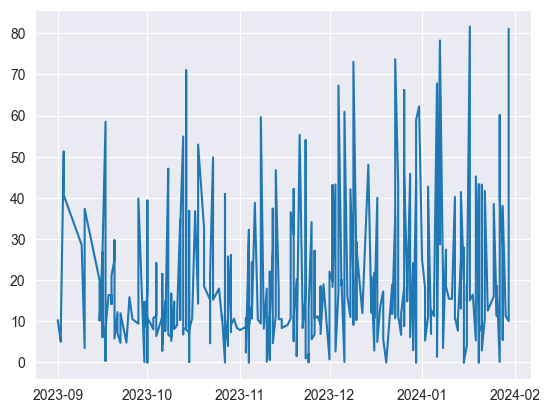

In [273]:
plt.plot(X.index, y)
plt.show()

In [681]:
#y = user_data_concat_copy['Verbrauch (kWh)']
X_train = X[0:277]
X_test = X[277:]

y_train = y[0:277]
y_test = y[277:]

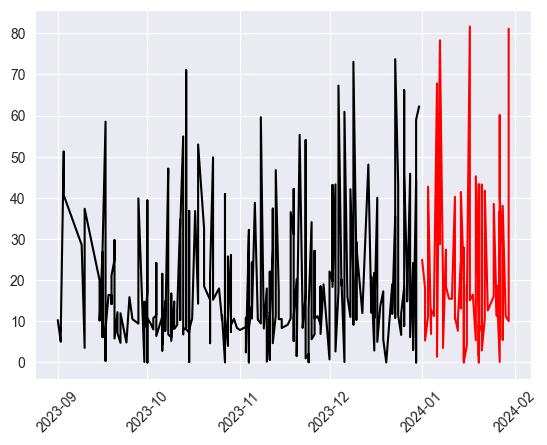

In [298]:
plt.plot(X_train.index, y_train, color='black')
plt.xticks(rotation=45)
plt.plot(X_test.index, y_test, color='red')
plt.show()

In [854]:
user_data_concat_copy.to_csv('../Data/user_data.csv', index=False)

OSError: Cannot save file into a non-existent directory: '..\Public\data'

### Auto ARIMA

In [738]:
auto_arima = pm.auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model = auto_arima.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2479.254, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2423.111, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2477.276, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2389.088, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2364.993, Time=0.31 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2360.229, Time=0.44 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2350.695, Time=0.49 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2348.767, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2358.316, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2319.614, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2318.092, T

In [739]:
forecast = model.predict(n_periods=len(X_test))
df = pd.DataFrame(forecast)
df = df.set_index(X_test.index)

In [741]:
df

0
Eingesteckt am           
2024-01-01      21.631758
2024-01-02      19.474375
2024-01-02      23.112617
2024-01-03      23.477710
2024-01-03      23.159509
...                   ...
2024-01-28      23.141466
2024-01-29      23.141466
2024-01-30      23.141466
2024-01-30      23.141466
2024-01-30      23.141466

[81 rows x 1 columns]

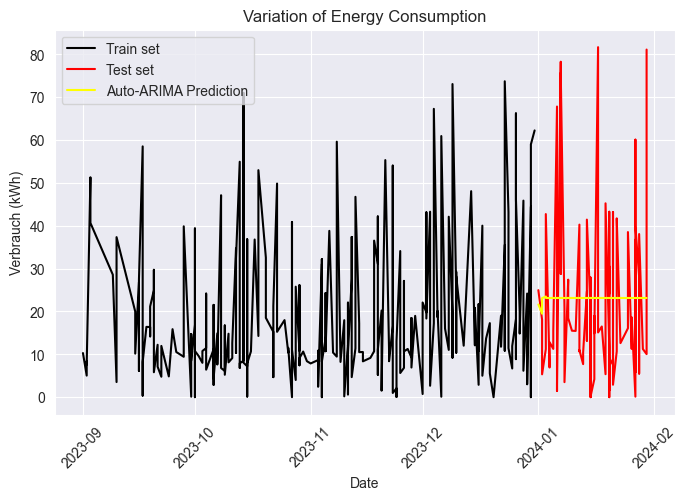

In [742]:
plt.figure(figsize=(8, 5))
plt.plot(X_train.index, y_train, color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(X_test.index, y_test, color='red', label='Test set')
plt.plot(df, color='Yellow', label='Auto-ARIMA Prediction')
plt.xlabel('Date')
plt.ylabel('Verbrauch (kWh)')
plt.title('Variation of Energy Consumption')
plt.legend()
plt.show()

In [743]:
rmse = np.sqrt(mean_squared_error(y_test, df[0]))
print(rmse)

19.74014291034889


### ARIMA

In [479]:
ARIMAmodel = ARIMA(y_train, order=(3,1,2))
#ARIMAmodel = ARIMA(y_train, order=(4,2,4))
ARIMAmodel = ARIMAmodel.fit()

In [448]:
y_pred = ARIMAmodel.get_forecast(len(X_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = X_test.index
y_pred_out = y_pred_df["Predictions"] 

### SARIMAX

In [606]:
#Generate all different combinations of p, d, q and s triplets
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [615]:
def objective_sarimax(trial):
    order=trial.suggest_categorical('order', pdq)
    seasonal_order=trial.suggest_categorical('seasonal_order', pdqs)
    model=SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
    nodel_fit = model.fit()
    predictions = model_fit.forecast(len(X_test))
    predictions = pd.Series(predictions, index=X_test.index)
    y_pred = model_fit.forecast(len(X_test))
    res = pd.DataFrame(y_pred)
    res = res.set_index(X_test.index)
    rmse = np.sqrt(mean_squared_error(y_test, res))
#     residuals = test_data - predictions
#     mse=np.sqrt(np.mean(residuals**2))
#     accuracy=mse
    return rmse

In [616]:
study=optuna.create_study(direction="minimize")
study.optimize(objective_sarimax,n_trials=10)

[I 2024-02-19 22:36:05,050] A new study created in memory with name: no-name-7760f845-c516-4ce0-b380-b261e59b713f
[I 2024-02-19 22:36:08,478] Trial 0 finished with value: 60.710000469516636 and parameters: {'order': (0, 1, 0), 'seasonal_order': (0, 2, 3, 12)}. Best is trial 0 with value: 60.710000469516636.
[I 2024-02-19 22:36:14,174] Trial 1 finished with value: 60.710000469516636 and parameters: {'order': (0, 0, 2), 'seasonal_order': (1, 2, 2, 12)}. Best is trial 0 with value: 60.710000469516636.
[I 2024-02-19 22:36:15,579] Trial 2 finished with value: 60.710000469516636 and parameters: {'order': (1, 0, 0), 'seasonal_order': (3, 1, 0, 12)}. Best is trial 0 with value: 60.710000469516636.
[I 2024-02-19 22:36:25,242] Trial 3 finished with value: 60.710000469516636 and parameters: {'order': (0, 2, 2), 'seasonal_order': (0, 2, 2, 12)}. Best is trial 0 with value: 60.710000469516636.
[I 2024-02-19 22:36:31,608] Trial 4 finished with value: 60.710000469516636 and parameters: {'order': (1, 

In [617]:
print(study.best_params)

{'order': (0, 1, 0), 'seasonal_order': (0, 2, 3, 12)}


In [842]:
SARIMAXmodel = SARIMAX(y_train, order=(1,0,0), seasonal_order=(2,1,0,12))
#SARIMAXmodel = SARIMAX(y_train, **study.best_params)
model_fit = SARIMAXmodel.fit()

In [843]:
y_pred = model_fit.forecast(len(X_test))
res = pd.DataFrame(y_pred, index=X_test.index)

In [844]:
s = pd.DataFrame(y_pred)
s = s.set_index(X_test.index)

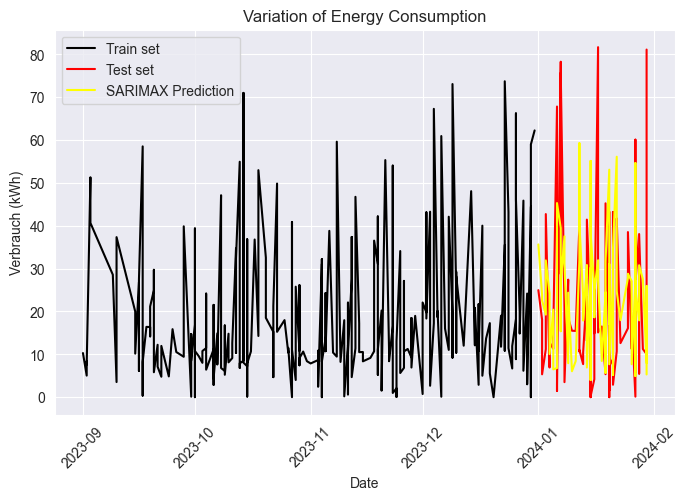

In [845]:
plt.figure(figsize=(8, 5))
plt.plot(X_train.index, y_train, color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(X_test.index, y_test, color='red', label='Test set')
plt.plot(s, color='Yellow', label='SARIMAX Prediction')
plt.xlabel('Date')
plt.ylabel('Verbrauch (kWh)')
plt.title('Variation of Energy Consumption')
plt.legend()
plt.show()

In [846]:
rmse = np.sqrt(mean_squared_error(y_test, s))
print(rmse)

25.137212347227212


### Predict energy consumption for the next 3 months

In [847]:
next_three_months = model_fit.forecast(steps=91)

In [848]:
next_three_months

277    35.634174
278    23.886574
279    22.547750
280    19.258197
281    31.904303
         ...    
363    17.666139
364    27.490205
365    30.120109
366    27.622630
367     7.754338
Name: predicted_mean, Length: 91, dtype: float64

In [849]:
forecast_dates = pd.date_range(start=X_test.index[-1] + pd.DateOffset(day=1), periods=91, freq='D')
forecast_df = pd.DataFrame(next_three_months)
forecast_df = forecast_df.set_index(forecast_dates)

In [850]:
forecast_df

predicted_mean
2024-01-01       35.634174
2024-01-02       23.886574
2024-01-03       22.547750
2024-01-04       19.258197
2024-01-05       31.904303
...                    ...
2024-03-27       17.666139
2024-03-28       27.490205
2024-03-29       30.120109
2024-03-30       27.622630
2024-03-31        7.754338

[91 rows x 1 columns]

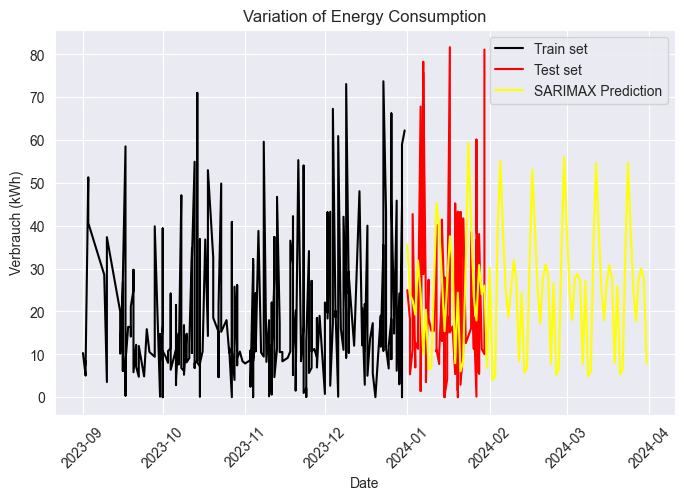

In [851]:
plt.figure(figsize=(8, 5))
plt.plot(X_train.index, y_train, color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(X_test.index, y_test, color='red', label='Test set')
plt.plot(forecast_df, color='Yellow', label='SARIMAX Prediction')
plt.xlabel('Date')
plt.ylabel('Verbrauch (kWh)')
plt.title('Variation of Energy Consumption')
plt.legend()
plt.show()

### ARIMA

In [765]:
#ARIMAmodel = ARIMA(y_train, order=(1,1,1))
ARIMAmodel = ARIMA(y_train, order=(4,0,4))
ARIMAmodel = ARIMAmodel.fit()

In [766]:
y_pred = ARIMAmodel.forecast(len(X_test))
#res = pd.DataFrame(y_pred, index=X_test.index)

In [767]:
s = pd.DataFrame(y_pred)
s = s.set_index(X_test.index)

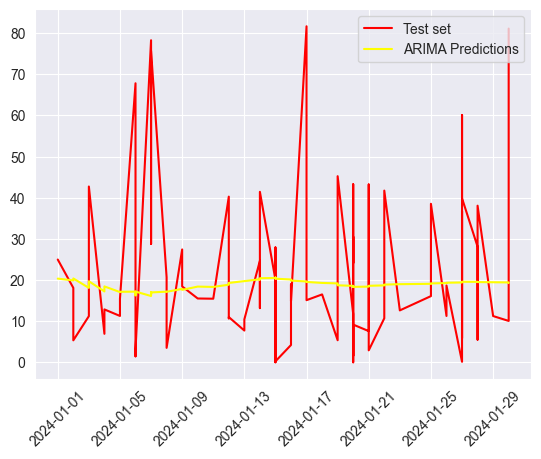

In [768]:
#plt.plot(X_train.index, y_train, color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(X_test.index, y_test, color='red', label='Test set')
plt.plot(s, color='Yellow', label='ARIMA Predictions')
plt.legend()
plt.show()

In [769]:
rmse = np.sqrt(mean_squared_error(y_test, s['predicted_mean']))
print(rmse)

20.314854047244342


#### Next three months

In [770]:
next_three_months = ARIMAmodel.forecast(steps=91)

In [771]:
forecast_dates = pd.date_range(start=X_test.index[-1] + pd.DateOffset(day=1), periods=91, freq='D')
forecast_df = pd.DataFrame(next_three_months)
forecast_df = forecast_df.set_index(forecast_dates)

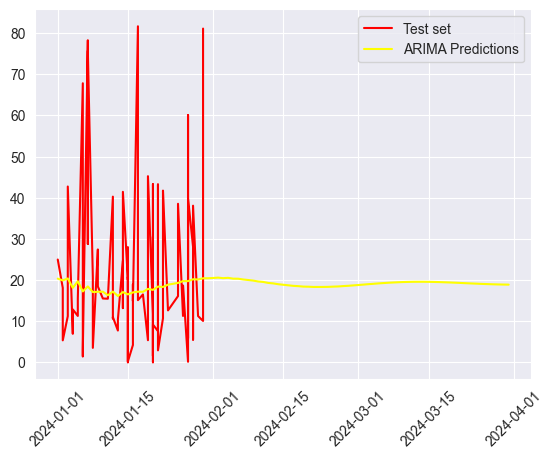

In [772]:
#plt.plot(X_train.index, y_train, color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(X_test.index, y_test, color='red', label='Test set')
plt.plot(forecast_df, color='Yellow', label='ARIMA Predictions')
plt.legend()
plt.show()

### Extra tests

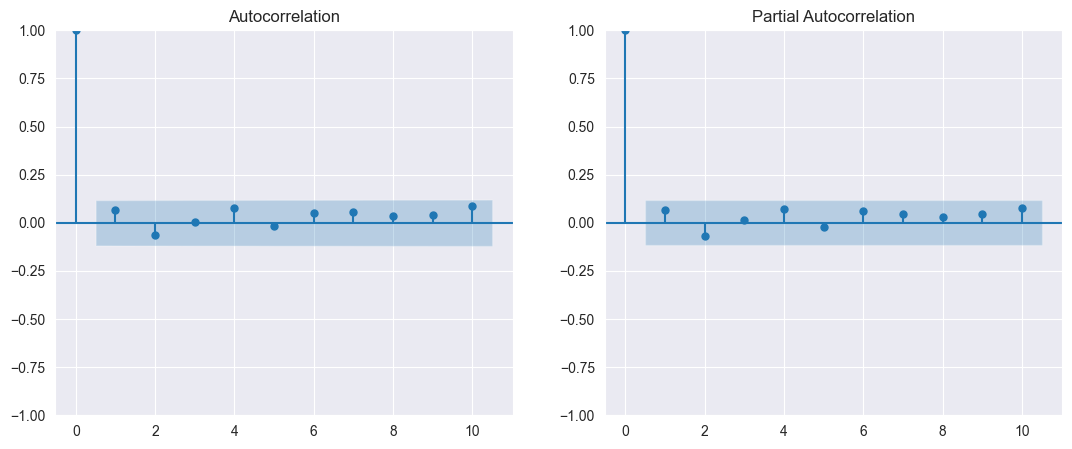

In [316]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
tsaplots.plot_acf(y_train, lags=10, ax=ax[0])
tsaplots.plot_pacf(y_train, lags=10, ax=ax[1])
plt.show()

lag-1 is greater than 0. Difference the series to reduce lag-1

In [317]:
differenced_y_train = y_train.diff(periods=1)
differenced_y_train = differenced_y_train.dropna()

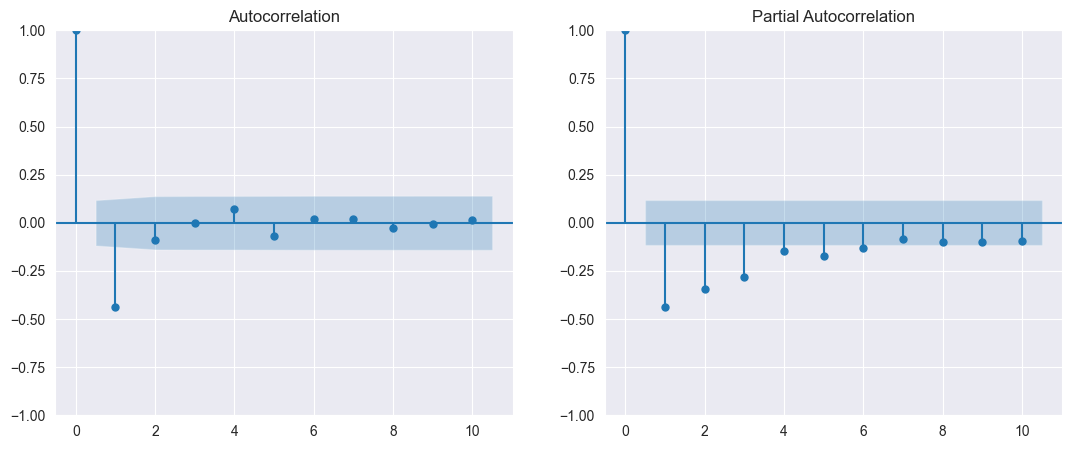

In [318]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
tsaplots.plot_acf(differenced_y_train, lags=10, ax=ax[0])
tsaplots.plot_pacf(differenced_y_train, lags=10, ax=ax[1])
plt.show()

In [383]:
ARIMAmodel = ARIMA(differenced_y_train, order=(4,2,4))
ARIMAmodel = ARIMAmodel.fit()

In [384]:
y_pred = ARIMAmodel.get_forecast(len(X_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = X_test.index
y_pred_out = y_pred_df["Predictions"] 

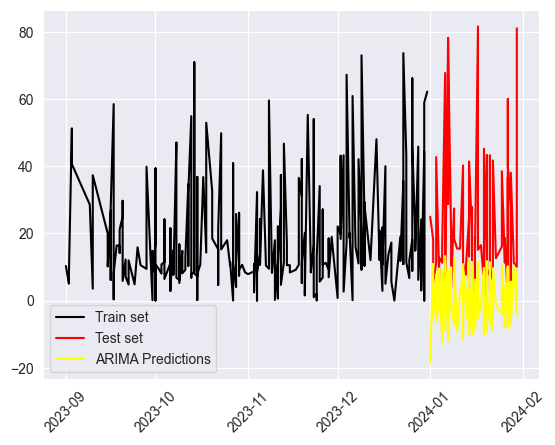

In [385]:
plt.plot(X_train.index, y_train, color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(X_test.index, y_test, color='red', label='Test set')
plt.plot(y_pred_out, color='Yellow', label='ARIMA Predictions')
plt.legend()
plt.show()

In [330]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_df['Predictions']))
print(rmse)

30.996633200207388


In [232]:
ARIMAmodel = ARIMA(endog=y, order=(3,1,2))
ARIMAmodel = ARIMAmodel.fit()

In [ ]:
y_pred = ARIMAmodel.get_forecast(len(X_test))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = X_test['Eingesteckt am']
y_pred_out = y_pred_df["Predictions"] 

In [ ]:
plt.plot(X_train['Eingesteckt am'], y_train, color='black', label='Train set')
plt.xticks(rotation=45)
plt.plot(X_test['Eingesteckt am'], y_test, color='red', label='Test set')
plt.plot(y_pred_out, color='Yellow', label='ARIMA Predictions')
plt.legend()
plt.show()

# Excesses

In [18]:
user_data_copy = user_data.copy()
user_data_copy['Plugged_in_month'] = user_data_copy['Plugged_in_month'].map({
    9: 'September',
    10: 'October',
    11: 'November'
})

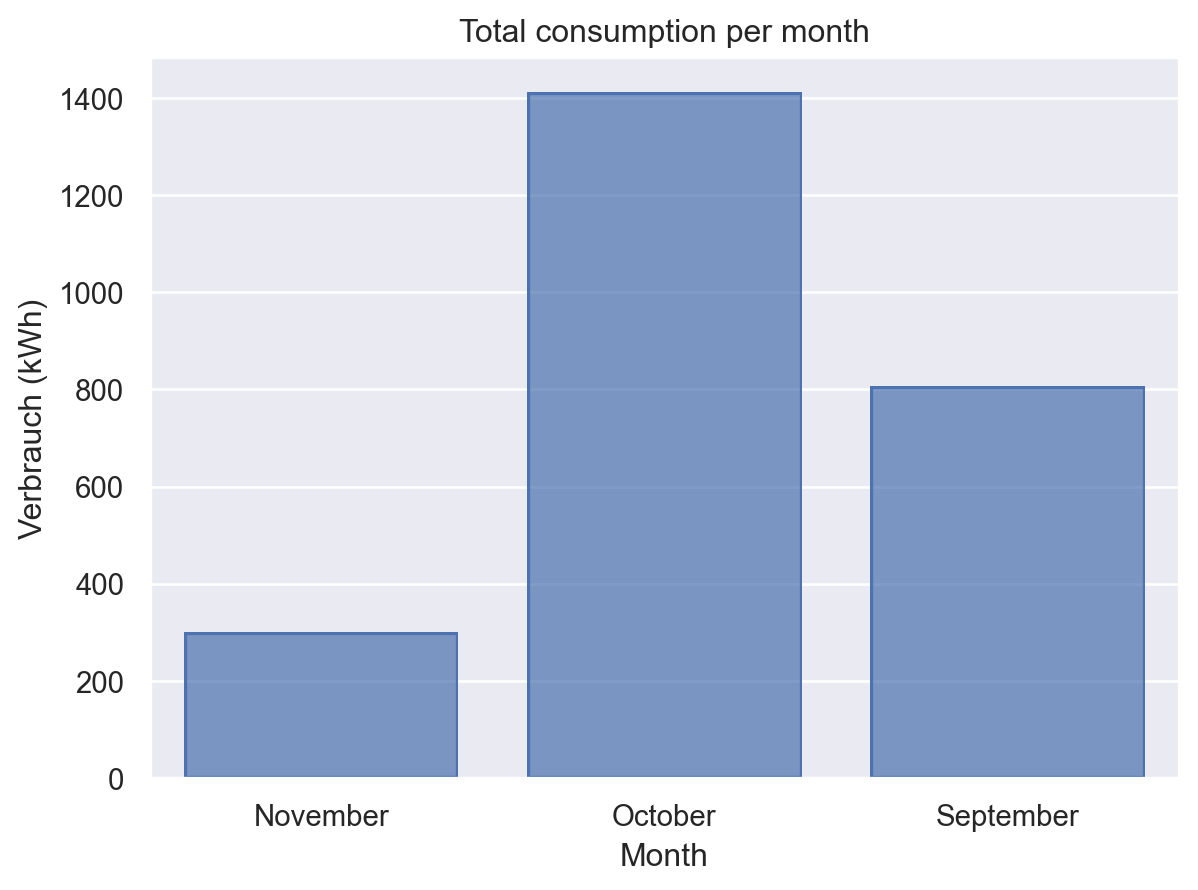

In [70]:
x = (
    so.Plot(user_data_copy, x="Plugged_in_month", y='Verbrauch (kWh)')
    .add(so.Bar(), so.Agg('sum'), so.Stack())
    .label(y='Verbrauch (kWh)', x='Month', title='Total consumption per month')
)
x.save('../Images/Public/Redo/consumption-per-month')

In [21]:
user_data.groupby(['Plugged_in_month'])['Verbrauch (kWh)'].sum()

Plugged_in_month
9      806.527
10    1413.450
11     299.619
Name: Verbrauch (kWh), dtype: float64

Only 7 days were recorded in November. This is why the consumption is much lower compared to other months.

In [22]:
user_data['Anschluss'] = user_data['Anschluss'].map({
    '1': 'Ladepunkt 1',
    'Ladepunkt 1': 'Ladepunkt 1',
    '2': 'Ladepunkt 2',
    'Ladepunkt 2': 'Ladepunkt 2',
    '3': 'Ladepunkt 3',
    'Ladepunkt 3': 'Ladepunkt 3',
    '4': 'Ladepunkt 4',
    'Ladepunkt 4': 'Ladepunkt 4'
})

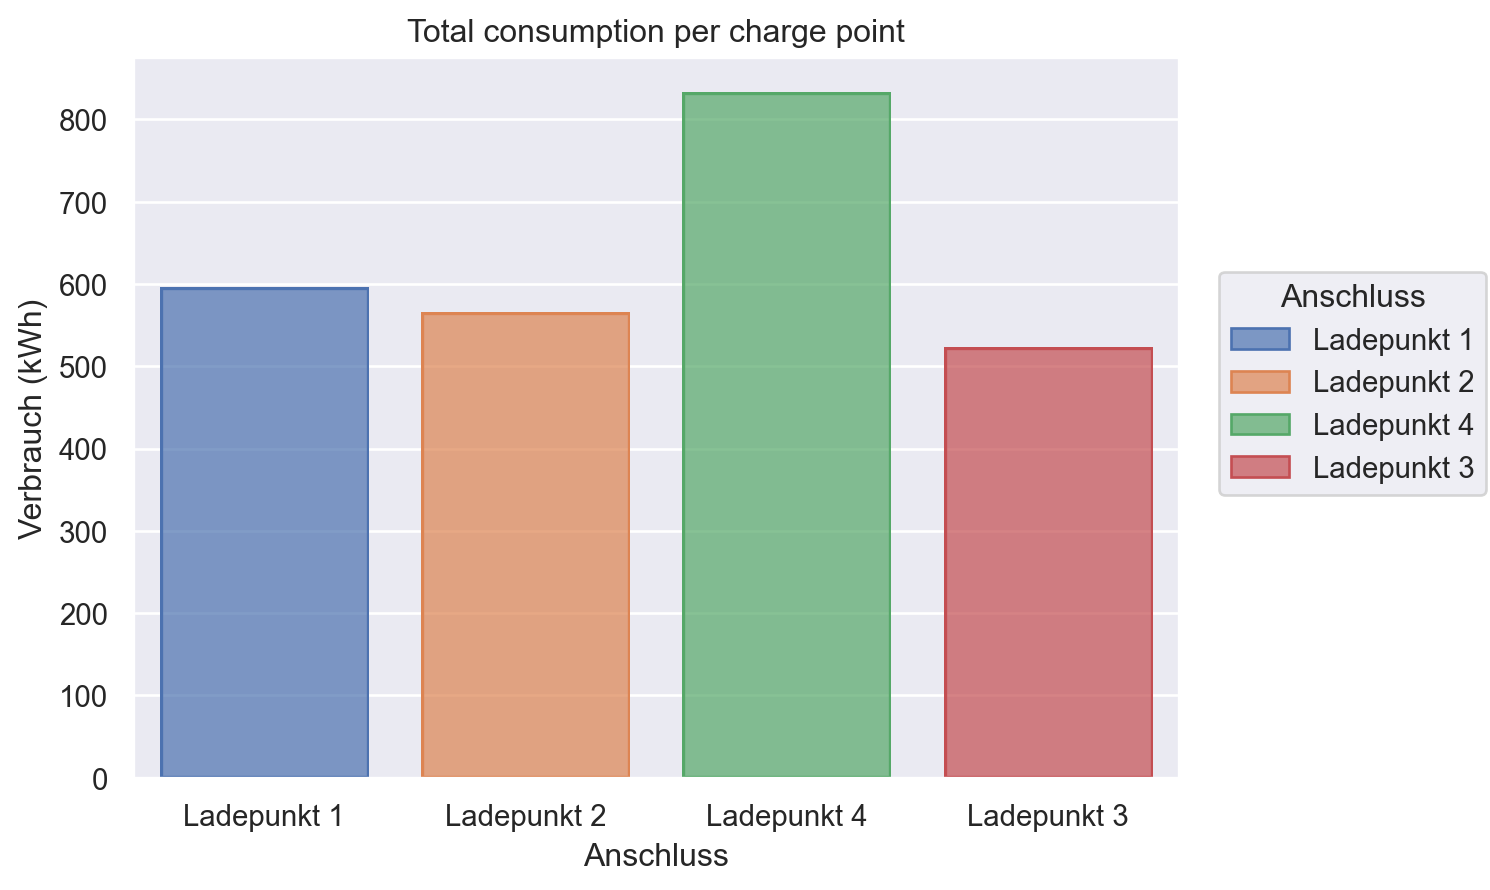

In [81]:
x = (
    so.Plot(user_data, x="Anschluss", y='Verbrauch (kWh)', color="Anschluss")
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Verbrauch (kWh)', title='Total consumption per charge point')
)
x.save('../Images/Public/Redo/consumption-per-charge-point')

In [25]:
user_data.groupby(['Standort', 'Ladestation'])['Verbrauch (kWh)'].sum()

Standort  Ladestation 
Ulanweg   ABL_10332049    2519.596
Name: Verbrauch (kWh), dtype: float64

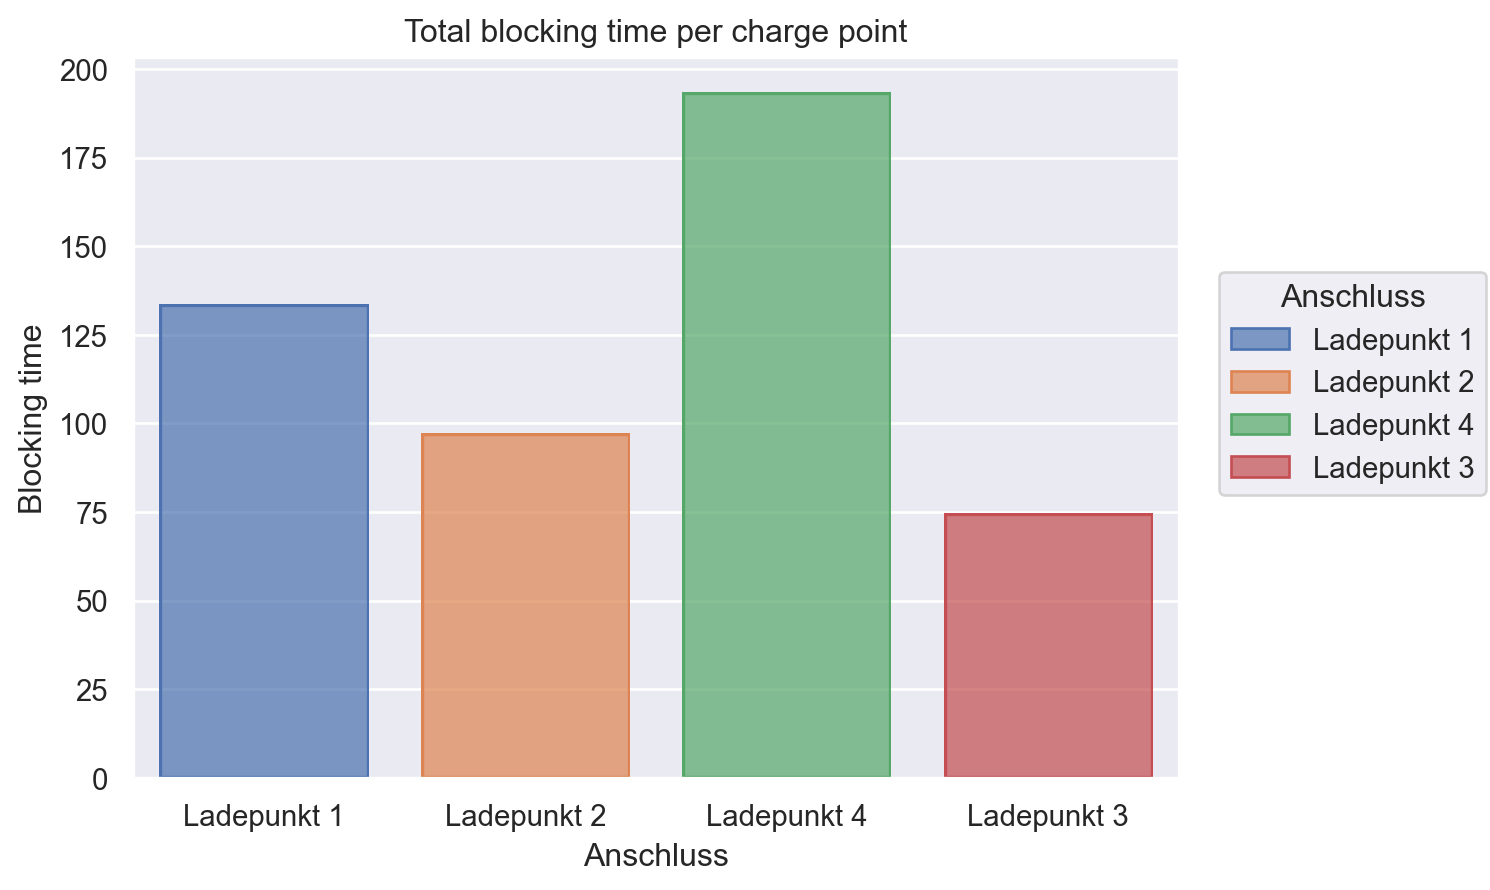

In [82]:
x = (
    so.Plot(user_data, x="Anschluss", y='Blocking time', color="Anschluss")
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Blocking time', title='Total blocking time per charge point')
)
x.save('../Images/Public/Redo/blocking-time-per-charge-point')

In [27]:
user_data.groupby(['Standort', 'Ladestation'])['Blocking time'].sum()

Standort  Ladestation 
Ulanweg   ABL_10332049    499.101944
Name: Blocking time, dtype: float64

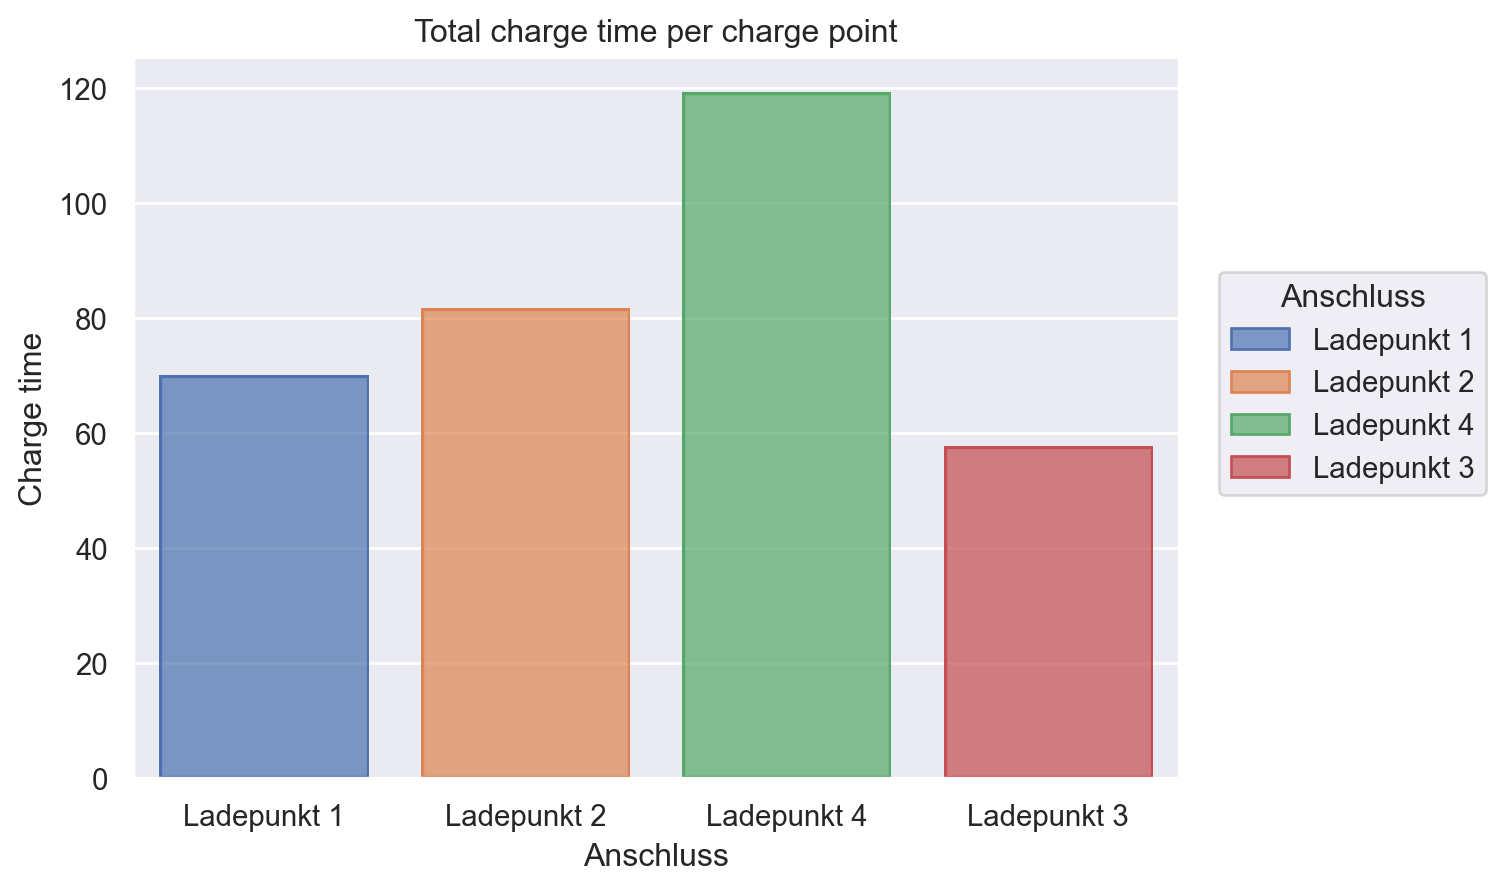

In [83]:
x = (
    so.Plot(user_data, x="Anschluss", y='Charge time', color="Anschluss")
    .add(so.Bar(), so.Agg('sum'))
    .label(y='Charge time', title='Total charge time per charge point')
)
x.save('../Images/Public/Redo/charge-time-per-charge-point')

In [93]:
user_data_blocking_time_sum = pd.pivot_table(user_data, values='Blocking time', columns=['Plugged_in_month'], index=['Anschluss'], aggfunc="sum")

In [94]:
user_data_blocking_time_month = pd.melt(
    user_data_blocking_time_sum.reset_index(),
    id_vars=['Anschluss'],
    value_vars=[9, 10, 11],
    var_name = 'Month',
    value_name = 'Blocking time'
)

In [69]:
#user_data.groupby('Plugged_in_month')['Plugged_in_day'].nunique()

In [95]:
def capacity_util(df):
    #months = df['Month'].values
    if df['Month'] == 9:
        capacity = df['Blocking time'] / 456
    elif df['Month'] == 10:
        capacity = df['Blocking time'] / 648
    else:
        capacity = df['Blocking time'] / 120
    return capacity

In [96]:
user_data_blocking_time_month['Capacity utilization'] = user_data_blocking_time_month.apply(capacity_util, axis=1)

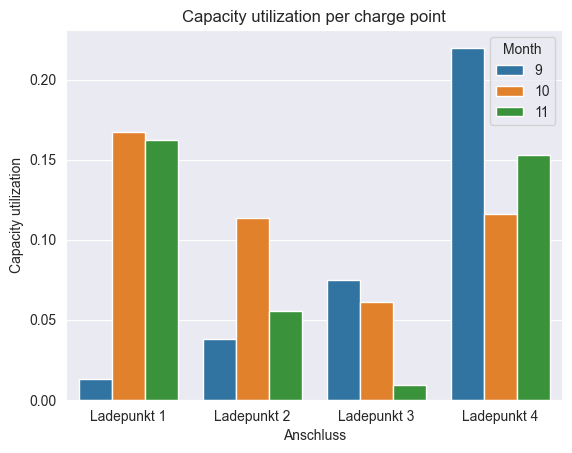

In [100]:
sns.barplot(
    data=user_data_blocking_time_month,
    x='Anschluss',
    y='Capacity utilization',
    hue='Month'
)
plt.title('Capacity utilization per charge point')
plt.savefig('../Images/Public/Redo/capacity-utilization-per-charge-point')
plt.show()

In [99]:
user_data_blocking_time_month.groupby('Anschluss')['Capacity utilization'].mean()

Anschluss
Ladepunkt 1    0.114134
Ladepunkt 2    0.068720
Ladepunkt 3    0.048257
Ladepunkt 4    0.162786
Name: Capacity utilization, dtype: float64

In [37]:
user_data_blocking_time_month.groupby('Ladestation')['Capacity utilization'].mean()

Ladestation
ABL_10332049    0.295922
Name: Capacity utilization, dtype: float64

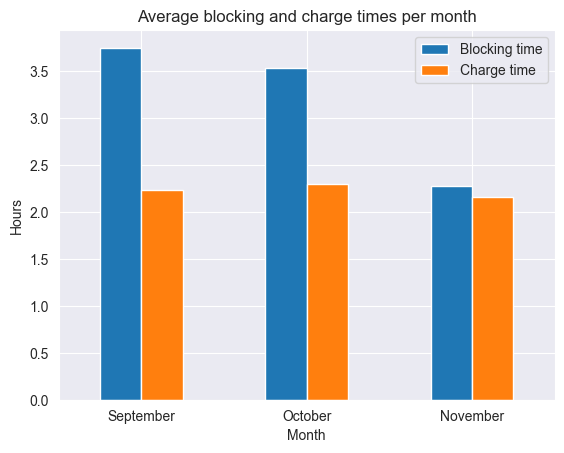

In [38]:
ax = user_data.groupby('Plugged_in_month')[['Blocking time', 'Charge time']].mean().plot(kind='bar')
ax.set_xticklabels(['September', 'October', 'November'])
plt.xlabel('Month')
plt.ylabel('Hours')
plt.xticks(rotation=0)
plt.title('Average blocking and charge times per month')
plt.savefig('../Images/Public/Redo/average-blocking-charge-time-per-month')
plt.show()

In [102]:
user_data['Charge time'].mean()

2.25402397260274

In [103]:
user_data.groupby('Anschluss')['EVSE-ID'].unique()

Anschluss
Ladepunkt 1    [DE*ONE*E7RVQ]
Ladepunkt 2    [DE*ONE*E3KHJ]
Ladepunkt 3    [DE*ONE*E68JX]
Ladepunkt 4    [DE*ONE*EE94A]
Name: EVSE-ID, dtype: object

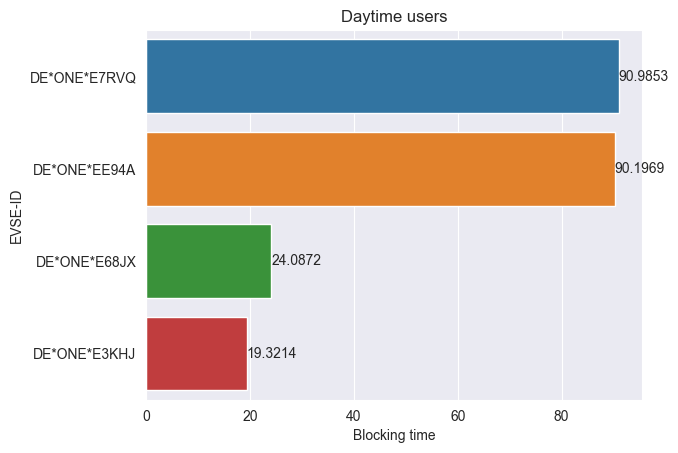

In [104]:
ax = sns.barplot(
    data=user_data_daytime,
    y='EVSE-ID',
    x='Blocking time',
    estimator='sum',
    ci=None
)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Daytime users')
plt.savefig('../Images/Public/Redo/daytime-users', bbox_inches='tight')
plt.show()

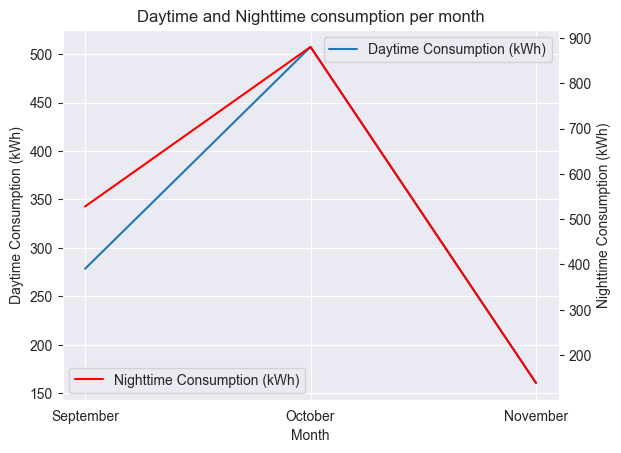

In [42]:
fig, ax = plt.subplots()

sns.lineplot(
    data=user_data_daytime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax,
    estimator='sum',
    ci=None,
    label='Daytime Consumption (kWh)'
)
#ax.tick_params(axis='y', labelcolor='blue')
ax.set_xlabel('Month')
ax.set_ylabel('Daytime Consumption (kWh)')

ax2 = ax.twinx()
ax2.grid(False)

sns.lineplot(
    data=user_data_nighttime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax2,
    estimator='sum',
    ci=None,
    color='red',
    label='Nighttime Consumption (kWh)'
)
plt.xticks([9, 10, 11], labels=['September', 'October', 'November'])
#ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Nighttime Consumption (kWh)')
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)
plt.title('Daytime and Nighttime consumption per month')
plt.savefig('../Images/Public/Redo/daytime-nighttime-consumption-per-month')
plt.show()

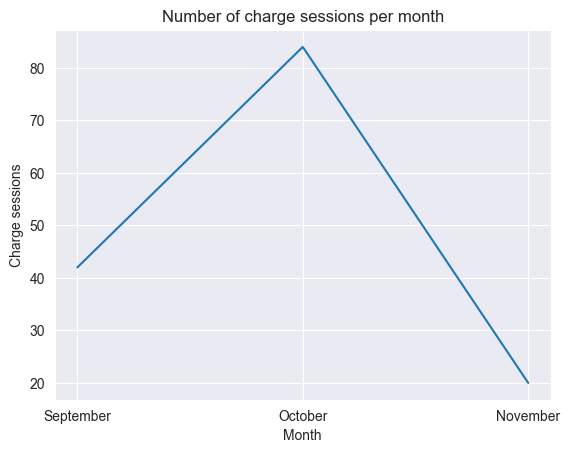

In [44]:
user_data.groupby('Plugged_in_month')['Charge time'].count().plot(kind='line')
plt.xticks([9,10,11], labels=['September', 'October', 'November'])
plt.xlabel('Month')
plt.ylabel('Charge sessions')
plt.title('Number of charge sessions per month')
plt.savefig('../Images/Public/Redo/charge-sessions-per-month')
plt.show()

In [45]:
user_data_daytime.groupby('Plugged_in_month')['Verbrauch (kWh)'].sum()

Plugged_in_month
9     278.568
10    507.301
11    160.891
Name: Verbrauch (kWh), dtype: float64

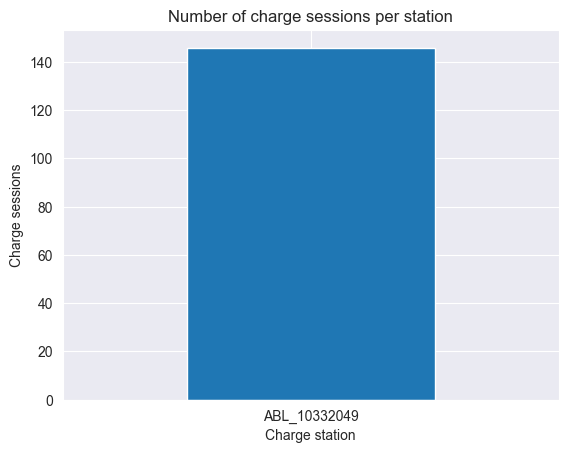

In [51]:
user_data.groupby('Ladestation')['Charge time'].count().plot(kind='bar')
#user_data.groupby('Ladestation')['Charge time'].count().plot(kind='line')
plt.xlabel('Charge station')
plt.ylabel('Charge sessions')
plt.xticks(rotation=0)
plt.title('Number of charge sessions per station')
plt.savefig('../Images/Public/Redo/charge-sessions-per-station')
plt.show()

In [53]:
user_data['Blocking time'].sum()

499.1019444444445

In [56]:
amount_of_consumption = user_data.groupby('Plugged_in_month')['Verbrauch (kWh)'].sum()
num_of_sessions = user_data.groupby('Plugged_in_month')['Charge time'].count()

user_data_kwh_per_session = (amount_of_consumption / num_of_sessions).reset_index()

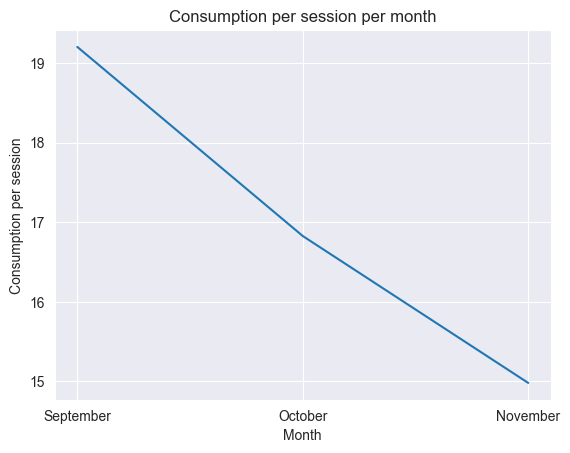

In [57]:
sns.lineplot(
    data=user_data_kwh_per_session,
    x='Plugged_in_month',
    y=0
)
plt.xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.xlabel('Month')
plt.ylabel('Consumption per session')
plt.title('Consumption per session per month')
plt.savefig('../Images/Public/Redo/consumption-per-session-per-month')
plt.show()

In [123]:
user_data_kwh_per_session[0].mean()

17.003586507936507

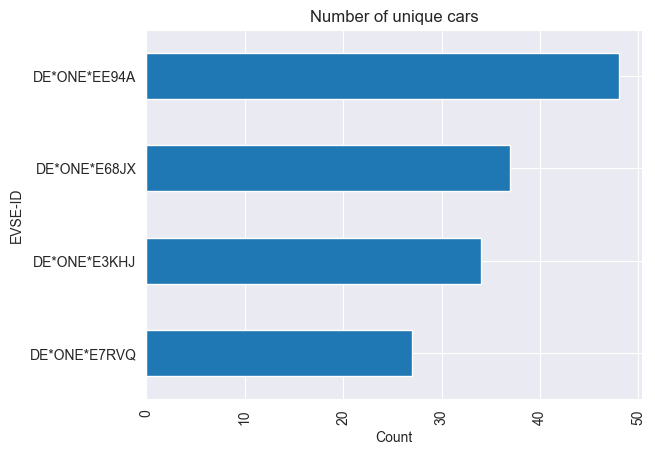

In [100]:
user_data['EVSE-ID'].value_counts(ascending=True).plot(kind='barh')
plt.xlabel('Count')
plt.xticks(rotation=90)
plt.title('Number of unique cars')
plt.savefig('Images/Public/unique-public-users.png', dpi=300, bbox_inches='tight')
plt.show()

### Rate/frequency of charge per user

<Axes: xlabel='Plugged_in_hour', ylabel='Charge time'>

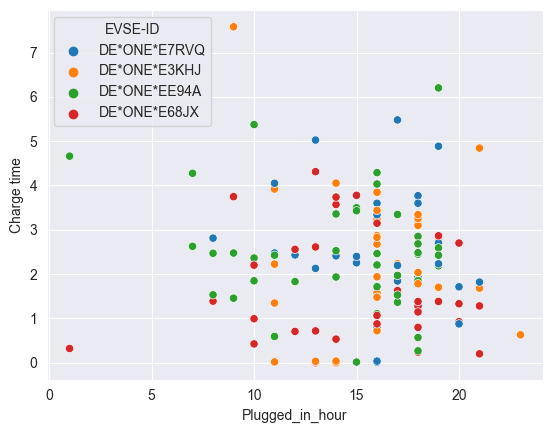

In [105]:
sns.scatterplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Charge time',
    hue='EVSE-ID',
 )

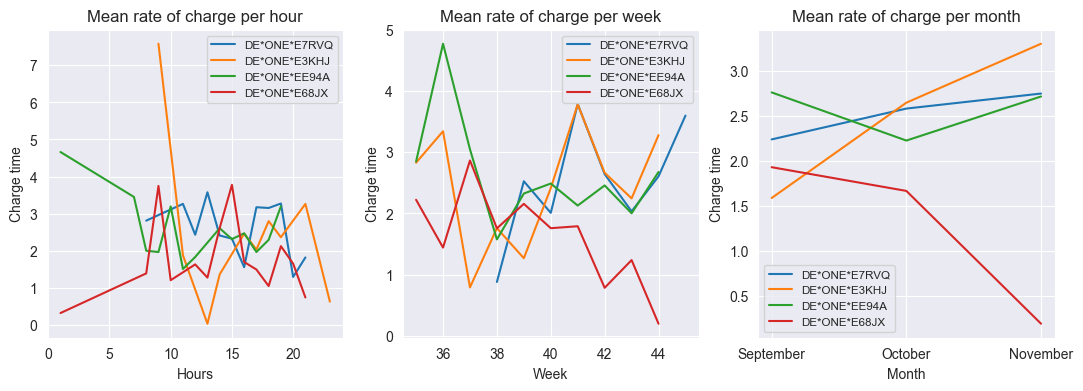

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
# Rate of charge (hourly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Charge time',
    hue='EVSE-ID',
    ci=None,
    ax=ax[0]
)
ax[0].legend(fontsize='small')
ax[0].set_title('Mean rate of charge per hour')
ax[0].set_xlabel('Hours')

# Rate of charge (weekly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_week',
    y='Charge time',
    hue='EVSE-ID',
    ci=None,
    ax=ax[1]
)
ax[1].set_title('Mean rate of charge per week')
ax[1].set_xlabel('Week')
ax[1].legend(fontsize='small')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Charge time',
    hue='EVSE-ID',
    ci=None,
    ax=ax[2]
)
ax[2].set_title('Mean rate of charge per month')
ax[2].set_xlabel('Month')
ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.legend(fontsize='small')
plt.savefig('Images/Public/rate-of-charge-of-users')
plt.show()

In [109]:
user_data_weekend = user_data[user_data['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]
user_data_weekend['Weekend'] = user_data['Eingesteckt am'].dt.day_name()

In [110]:
user_data_weekend['Weekend'] = user_data_weekend['Weekend'].map({
    'Saturday': 6,
    'Sunday': 7
})

In [23]:
#user_data_weekend[['EVSE-ID', 'Weekend', 'Eingesteckt am', 'Ausgesteckt am', 'Zeit angesteckt', 'Ladedauer', 'Standort', 'Ladestation', 'Charge time']]

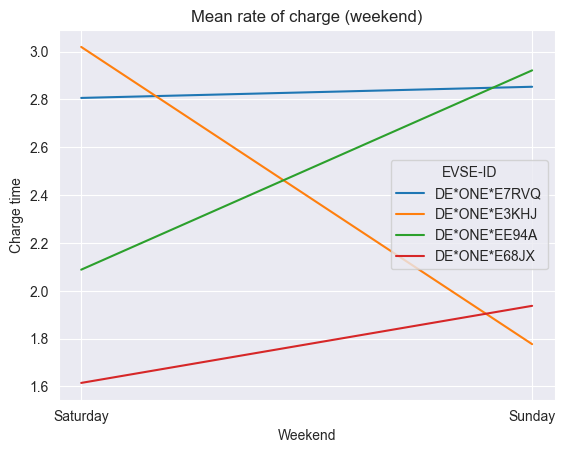

In [111]:
# Rate of charge (weekend)
sns.lineplot(
    data=user_data_weekend,
    x='Weekend',
    y='Charge time',
    hue='EVSE-ID',
    ci=None
)
plt.title('Mean rate of charge (weekend)')
plt.xlabel('Weekend')
plt.xticks([6, 7], labels=['Saturday', 'Sunday'])
plt.savefig('Images/Public/rate-of-charge-of-users-weekend')
plt.show()

### Rate of charge over the weekend

In [105]:
user_data_weekend = user_data[user_data['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]
user_data_weekend['Weekend'] = user_data['Eingesteckt am'].dt.day_name()

In [106]:
user_data_weekend['Weekend'] = user_data_weekend['Weekend'].map({
    'Saturday': 6,
    'Sunday': 7
})

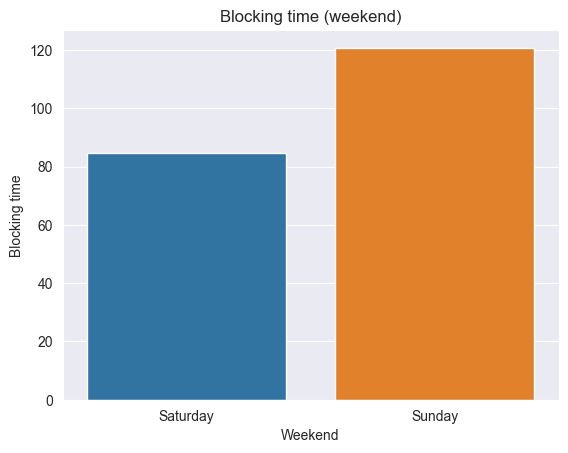

In [115]:
# Rate of charge (weekend)
ax = sns.barplot(
    data=user_data_weekend,
    x='Weekend',
    y='Blocking time',
    ci=None,
    estimator='sum'
)
plt.title('Blocking time (weekend)')
plt.xlabel('Weekend')
ax.set_xticklabels(['Saturday', 'Sunday'])
plt.savefig('../Images/Public/Redo/blocking-time-weekend')
plt.show()

### Usage occupancy of charge points

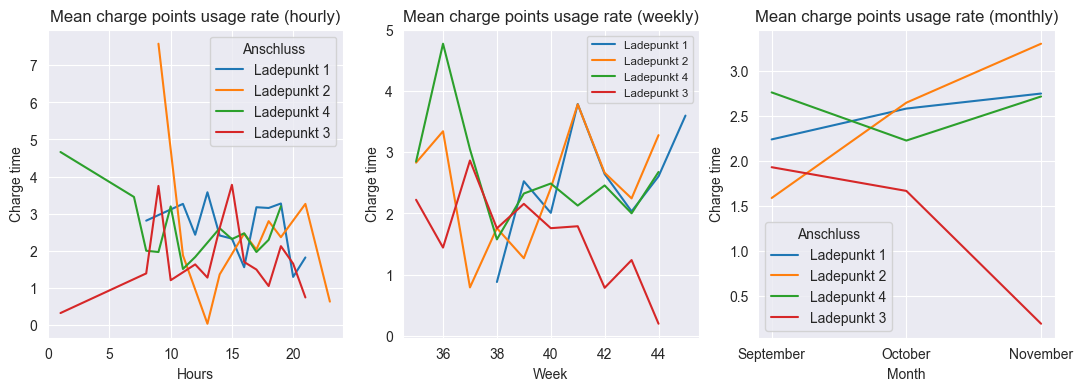

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
# Rate of charge (hourly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Charge time',
    hue='Anschluss',
    ci=None,
    ax=ax[0]
)
ax[0].set_title('Mean charge points usage rate (hourly)')
ax[0].set_xlabel('Hours')

# Rate of charge (weekly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_week',
    y='Charge time',
    hue='Anschluss',
    ci=None,
    ax=ax[1]
)
ax[1].set_title('Mean charge points usage rate (weekly)')
ax[1].set_xlabel('Week')
ax[1].legend(fontsize='small', loc='upper right')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Charge time',
    hue='Anschluss',
    ci=None,
    ax=ax[2]
)
ax[2].set_title('Mean charge points usage rate (monthly)')
ax[2].set_xlabel('Month')
ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.savefig('Images/Public/usage-occupancy-of-charge-points')
plt.show()

### Blocking time

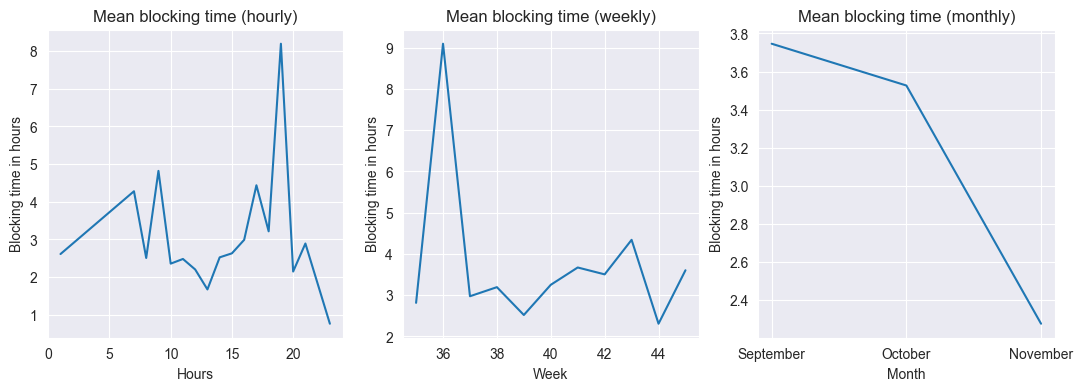

In [120]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
# Rate of charge (hourly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Blocking time',
    ci=None,
    ax=ax[0]
)
ax[0].set_title('Mean blocking time (hourly)')
ax[0].set_ylabel('Blocking time in hours')
ax[0].set_xlabel('Hours')

# Rate of charge (weekly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_week',
    y='Blocking time',
    ci=None,
    ax=ax[1]
)
ax[1].set_title('Mean blocking time (weekly)')
ax[1].set_xlabel('Week')
ax[1].set_ylabel('Blocking time in hours')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Blocking time',
    ci=None,
    ax=ax[2]
)
ax[2].set_title('Mean blocking time (monthly)')
ax[2].set_xlabel('Month')
ax[2].set_ylabel('Blocking time in hours')
ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.savefig('Images/Public/blocking-time')
plt.show()

### Hogging time

In [115]:
user_data['Hogging time'] = user_data['Blocking time'] - user_data['Charge time']

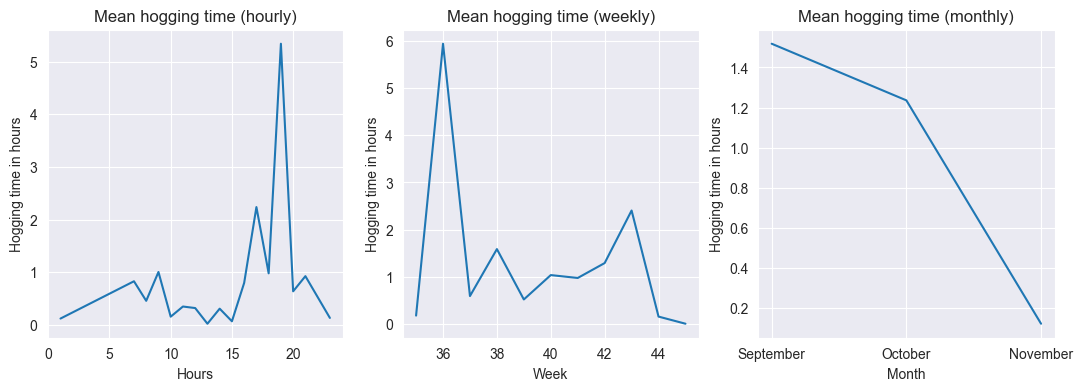

In [121]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
# Rate of charge (hourly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_hour',
    y='Hogging time',
    ci=None,
    ax=ax[0]
)
ax[0].set_title('Mean hogging time (hourly)')
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Hogging time in hours')

# Rate of charge (weekly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_week',
    y='Hogging time',
    ci=None,
    ax=ax[1]
)
ax[1].set_title('Mean hogging time (weekly)')
ax[1].set_xlabel('Week')
ax[1].set_ylabel('Hogging time in hours')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data,
    x='Plugged_in_month',
    y='Hogging time',
    ci=None,
    ax=ax[2]
)
ax[2].set_title('Mean hogging time (monthly)')
ax[2].set_xlabel('Month')
ax[2].set_ylabel('Hogging time in hours')
ax[2].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
plt.savefig('Images/Public/hogging-time')
plt.show()

### Day-time demand profile

In [122]:
user_data_daytime_weekend = user_data_daytime[user_data_daytime['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]
user_data_daytime_weekend['Weekend'] = user_data_daytime['Eingesteckt am'].dt.day_name()

In [124]:
user_data_daytime_weekend['Weekend'] = user_data_daytime_weekend['Weekend'].map({
    'Saturday': 6,
    'Sunday': 7
})

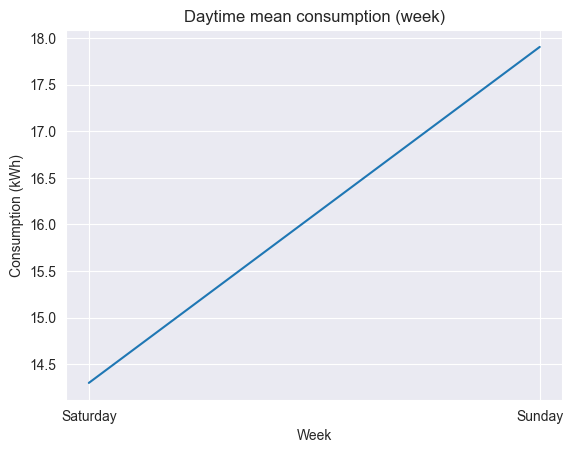

In [125]:
sns.lineplot(
    data=user_data_daytime_weekend,
    x='Weekend',
    y='Verbrauch (kWh)',
    ci=None
)
plt.xlabel('Week')
plt.ylabel('Consumption (kWh)')
plt.title('Daytime mean consumption (week)')
plt.xticks([6, 7], labels=['Saturday', 'Sunday'])
plt.savefig('Images/Public/daytime-demand-profile-weekend')
plt.show()

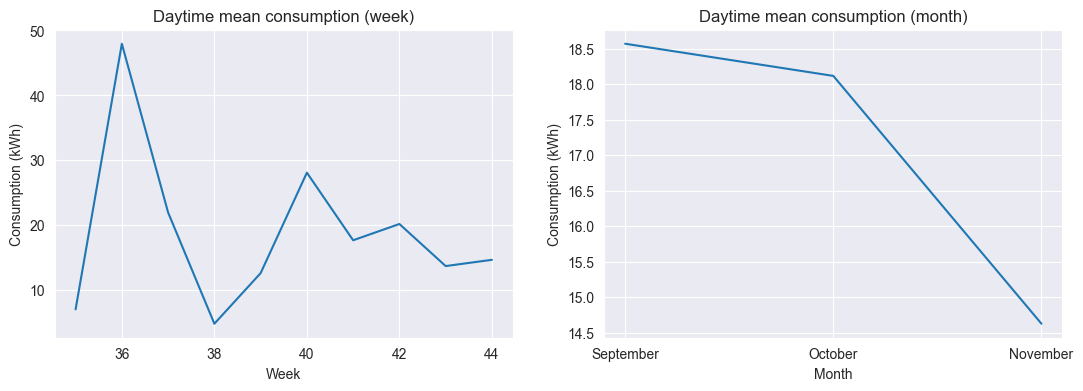

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# Rate of charge (weekly)
sns.lineplot(
    data=user_data_daytime,
    x='Plugged_in_week',
    y='Verbrauch (kWh)',
    ax=ax[0],
    ci=None
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Consumption (kWh)')
ax[0].set_title('Daytime mean consumption (week)')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data_daytime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax[1],
    ci=None
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Consumption (kWh)')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Daytime mean consumption (month)')
plt.savefig('Images/Public/daytime-demand-profile')
plt.show()

### Nighttime demand profile

In [126]:
user_data_nighttime_weekend = user_data_nighttime[user_data_nighttime['Eingesteckt am'].dt.day_name().isin(['Saturday', 'Sunday'])]
user_data_nighttime_weekend['Weekend'] = user_data_nighttime['Eingesteckt am'].dt.day_name()

In [127]:
user_data_nighttime_weekend['Weekend'] = user_data_nighttime_weekend['Weekend'].map({
    'Saturday': 6,
    'Sunday': 7
})

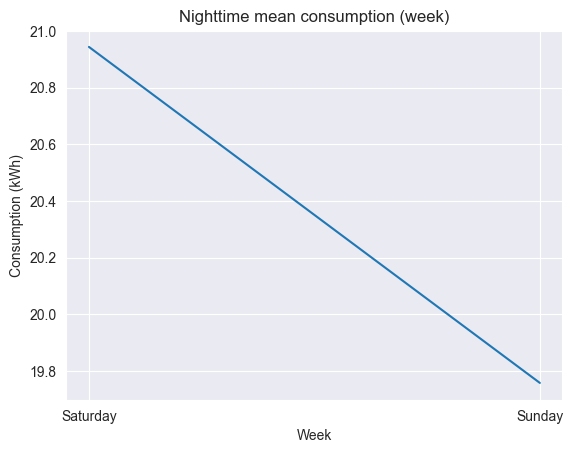

In [129]:
sns.lineplot(
    data=user_data_nighttime_weekend,
    x='Weekend',
    y='Verbrauch (kWh)',
    ci=None
)
plt.xlabel('Week')
plt.ylabel('Consumption (kWh)')
plt.title('Nighttime mean consumption (week)')
plt.xticks([6, 7], labels=['Saturday', 'Sunday'])
plt.savefig('Images/Public/nighttime-demand-profile-weekend')
plt.show()

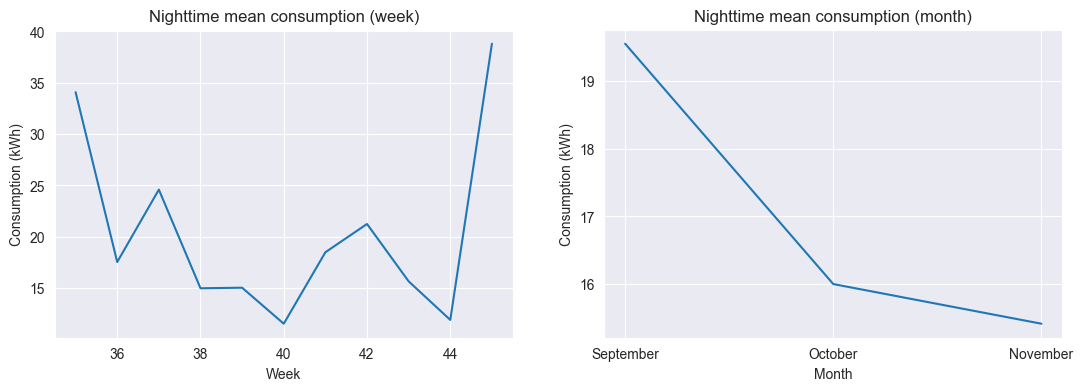

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(13,4))

# Rate of charge (weekly)
sns.lineplot(
    data=user_data_nighttime,
    x='Plugged_in_week',
    y='Verbrauch (kWh)',
    ax=ax[0],
    ci=None
)
ax[0].set_xlabel('Week')
ax[0].set_ylabel('Consumption (kWh)')
ax[0].set_title('Nighttime mean consumption (week)')

# Rate of charge (monthly)
sns.lineplot(
    data=user_data_nighttime,
    x='Plugged_in_month',
    y='Verbrauch (kWh)',
    ax=ax[1],
    ci=None
)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Consumption (kWh)')
ax[1].set_xticks([9, 10, 11], labels=['September', 'October', 'November'])
ax[1].set_title('Nighttime mean consumption (month)')
plt.savefig('Images/Public/nighttime-demand-profile')
plt.show()